# Deloitte's Quantum Climate Challenge 2023

The challenge focuses on CO2 captuere in MOFs (Metal Organic Frameworks) ans is dvided in two principal tasks

## Task 1: Calculate the minimum of the potential energy surface of combinations gas molecules and metallic ions

### Task 1A: Build a quantum/quantum-hybrid algorithm. Run simulations and on real quantum devices

Pick at least one metallic ion from the list:
* __Mg2+ (2p6 - 10 e-)__
* Mn2+ (3d5 - 23 e-)
* Fe2+ (3d6 - 24 e-)
* Co2+ (3d7 - 25 e-)
* Ni2+ (3d8 - 26 e-)
* Cu2+ (3d9 - 27 e-)
* __Zn2+ (3d10 - 28 e-)__

And study the composite system with CO2 and another gas molecule:
* __CO2 (22 e-)__
* __H2O (10 e-)__
* __N2 (14e-)__


### Task 1B: Compare those results to classical simulations

For the purpose of this notebook we will focus on Task 1A. There is another book focused on 1B, building classical benchmarks with PySCF.

### Imports and Helper Functions

In [2]:
from qiskit.algorithms import VQE, NumPyMinimumEigensolver, NumPyEigensolver #Algorithms

#Qiskit odds and ends
from qiskit.circuit.library import EfficientSU2, EvolvedOperatorAnsatz
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP, L_BFGS_B
from qiskit.opflow import Z2Symmetries, X, Y, Z, I, PauliSumOp, Gradient, NaturalGradient
from qiskit import IBMQ, BasicAer, Aer, transpile
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.utils.mitigation import CompleteMeasFitter #Measurement error mitigatioin
from qiskit.tools.visualization import circuit_drawer
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.algorithms.minimum_eigensolvers import VQE, AdaptVQE, MinimumEigensolverResult
from qiskit.primitives import Estimator
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit.quantum_info import SparsePauliOp

#qiskit_nature
from qiskit_nature.second_q.drivers import PySCFDriver, MethodType
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.circuit.library import UCCSD, PUCCD, SUCCD, HartreeFock, CHC, VSCF
from qiskit_nature.second_q.operators.fermionic_op import FermionicOp
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer , FreezeCoreTransformer
from qiskit_nature.second_q.problems import ElectronicStructureProblem, EigenstateResult
from qiskit_nature.second_q.mappers import QubitConverter, ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.second_q.algorithms.ground_state_solvers.minimum_eigensolver_factories.vqe_ucc_factory import VQEUCCFactory
from qiskit_nature.second_q.algorithms.ground_state_solvers.minimum_eigensolver_factories.numpy_minimum_eigensolver_factory import NumPyMinimumEigensolverFactory
from qiskit_nature.second_q.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit_nature.second_q.algorithms.excited_states_solvers.eigensolver_factories.numpy_eigensolver_factory import NumPyEigensolverFactory
from qiskit_nature.second_q.algorithms.excited_states_solvers import QEOM, ExcitedStatesEigensolver

#Runtime
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator)
from qiskit_ibm_runtime.options import Options, ResilienceOptions, SimulatorOptions, TranspilationOptions, ExecutionOptions

#PySCF
from functools import reduce
import scipy.linalg
from pyscf import scf
from pyscf import gto, dft
from pyscf import mcscf, fci
from functools import reduce
from pyscf.mcscf import avas, dmet_cas

#Python odds and ends
import matplotlib
import matplotlib.pyplot as plt
import pylab
import numpy as np
import os
import pyscf
from IPython.display import display, clear_output
import mapomatic as mm

from datetime import datetime
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

IBMQ.load_account()
provider = IBMQ.get_provider(group='deployed')
service = QiskitRuntimeService(channel='ibm_quantum')
#set Backends
#simulators
backend_stv = Aer.get_backend('aer_simulator_statevector')
#Real Devices
backend_nair= provider.get_backend('ibm_nairobi')
backend_manil = provider.get_backend('ibmq_manila')
backend_qsm_ibm=provider.get_backend('ibmq_qasm_simulator')
seed=42

#solvers
npme = NumPyMinimumEigensolver()
npe=NumPyEigensolver()

/var/folders/ts/54g0mcnn4glc0n7qph2hqb2c0000gn/T/ipykernel_80115/4269044919.py:61: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  IBMQ.load_account()
/var/folders/ts/54g0mcnn4glc0n7qph2hqb2c0000gn/T/ipykernel_80115/4269044919.py:61: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


Helper functions to save and read results

In [3]:
## Python program to store list to file using pickle module
import pickle

# write list to binary file
def write_list(a_list,filename):
    # store list in binary file so 'wb' mode
    with open(filename, 'wb') as fp:
        pickle.dump(a_list, fp)
        print('Done writing list into a binary file')
        
def write_dict(a_dict,filename):
    # store list in binary file so 'wb' mode
    with open(filename, 'wb') as fp:
        pickle.dump(a_dict, fp,protocol=pickle.HIGHEST_PROTOCOL)
        print('Done writing dict into a binary file')

# Read list to memory
def read(filename):
    # for reading also binary mode is important
    with open(filename, 'rb') as fp:
        n_list = pickle.load(fp)
        return n_list

Optional Custom VQE class

In [4]:
#Create a custoom VQE Program
from qiskit.algorithms.minimum_eigensolvers import MinimumEigensolver, VQEResult

class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        self._eval_count=0
        
    def compute_minimum_eigenvalue(self, operators,initial_point, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x])
            # Get results from jobs
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            std=est_result.metadata[0]
            self._eval_count+=1
            # Save result information using callback function
            if self._callback is not None:
                self._callback(self._eval_count, value, std)
            return value    
        # Select an initial point for the ansatzs' parameters
        x0 =initial_point
        #x0=0*np.random.rand(self._circuit.num_parameters)
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result
    

Callback function to get intermediate info about the calculation

In [5]:
counts = []
values = []
params = []
meta_dicts=[]
def callback(eval_count, param, val,meta):  
    # Overwrites the same line when printing
    counts.append(eval_count)
    values.append(val)
    params.append(param)
    meta_dicts.append(meta)
    mean=np.mean(values)
    std=np.std(values)
    display("Evaluation: {}, Energy: {}, Mean: {}, STD: {}, Metadata: {}".format(eval_count, val,mean,std, meta))
    clear_output(wait=True)

Solver functions. local_RYRZ, local_UCCSD and adapt_solver work locally while sim_solver and real_solver leverage Qiskit runtime to run on the cloud.

In [6]:
def exact_solver(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

def local_RYRZ_solver(distances,mapper,optimizer,freeze_core):
    
    dists=[]
    results=[]
    problems=[]
    hf_energies=[]
    initial_points=[]
    ops=[]
    for dist in distances:
        #Driver
        driver,og_problem=make_driver(dist)
        #Qubit_Op
        qubit_op, problem, converter,hf_energy = make_qubit_op(dist,og_problem,mapper,freeze_core)
        ops.append(qubit_op)
        problems.append(problem)
        #Initial State
        init_state = HartreeFock(problem.num_spatial_orbitals, problem.num_particles, converter)
        #ansatz = UCCSD(num_spatial_orbitals=problem.num_spatial_orbitals,num_particles=problem.num_particles,qubit_converter=converter,initial_state=init_state)
        ansatz = EfficientSU2(num_qubits=qubit_op.num_qubits,su2_gates=['ry','rz'], entanglement='linear', reps=3, initial_state=init_state)
        # Set initial parameters of the ansatz
        if len(initial_points)!=0 and ops[-1].num_qubits==ops[-2].num_qubits:
            initial_point=initial_points[-1]
        elif len(initial_points)!=0:
            old_ans=EfficientSU2(num_qubits=ops[-2].num_qubits,su2_gates=['ry','rz'], entanglement='linear', reps=3)
            if ansatz.num_parameters>old_ans.num_parameters:
                initial_point=np.append(initial_points[-1],np.pi/4 * np.random.rand(ansatz.num_parameters - old_ans.num_parameters))
            else:
                to_remove=old_ans.num_parameters-ansatz.num_parameters
                initial_point=np.delete(initial_points[-1],np.arange(-1,-to_remove-1,-1))
        else:
            #initial_point = np.pi/4 * np.random.rand(ansatz.num_parameters)
            initial_point= np.zeros(ansatz.num_parameters)
        
        bck_opt={'method':'statevector',
         'device':'CPU',
         'precision':'double',
         'extended_stabilizer_sampling_method':'resampled_metropolis'
                }
        run_opt={'shots':32,
                }
        #estimator = AerEstimator([ansatz], [fz_qubit_op],backend_options=bck_opt,run_options=run_opt)
        estimator= Estimator ([ansatz],[qubit_op])
    
        counts = []
        values = []
        deviation = []
    
        vqe = VQE(estimator, ansatz, optimizer,initial_point=initial_point, callback=callback)

        result = vqe.compute_minimum_eigenvalue(qubit_op)
        
        initial_points.append(result.optimal_point)
        results.append(result)
        dists.append(dist)
        hf_energies.append(hf_energy)
    
    return results, problems ,distances, hf_energies

def local_UCCSD_solver(distances,mapper,optimizer,freeze_core):
    
    dists=[]
    results=[]
    problems=[]
    hf_energies=[]
    initial_points=[]
    ops=[]
    for dist in distances:
        #Driver
        driver,og_problem=make_driver(dist)
        #Qubit_Op
        qubit_op, problem, converter,hf_energy = make_qubit_op(dist,og_problem,mapper,freeze_core)
        ops.append(qubit_op)
        problems.append(problem)
        #Initial State
        init_state = HartreeFock(problem.num_spatial_orbitals, problem.num_particles, converter)
        ansatz = UCCSD(num_spatial_orbitals=problem.num_spatial_orbitals,num_particles=problem.num_particles,qubit_converter=converter,initial_state=init_state)
        #ansatz = EfficientSU2(num_qubits=qubit_op.num_qubits,su2_gates=['ry','rz'], entanglement='linear', reps=3, initial_state=init_state)
        # Set initial parameters of the ansatz
        
        #initial_point = np.pi/4 * np.random.rand(ansatz.num_parameters)
        initial_point= np.zeros(ansatz.num_parameters)
        
        bck_opt={'method':'statevector',
         'device':'CPU',
         'precision':'double',
         'extended_stabilizer_sampling_method':'resampled_metropolis'
                }
        run_opt={'shots':32,
                }
        #estimator = AerEstimator([ansatz], [fz_qubit_op],backend_options=bck_opt,run_options=run_opt)
        estimator= Estimator ([ansatz],[qubit_op])
    
        counts = []
        values = []
        deviation = []
    
        vqe = VQE(estimator, ansatz, optimizer,initial_point=initial_point, callback=callback)

        result = vqe.compute_minimum_eigenvalue(qubit_op)
        
        initial_points.append(result.optimal_point)
        results.append(result)
        dists.append(dist)
        hf_energies.append(hf_energy)
    
    return results, problems ,distances, hf_energies


def adapt_solver(distances,mapper,optimizer,freeze_core):
    
    dists=[]
    results=[]
    problems=[]
    hf_energies=[]
    initial_points=[]
    ops=[]
    ansatze=[]
    for dist in distances:
        #Driver
        driver,og_problem=make_driver(dist)
        #Qubit_Op
        qubit_op, problem, converter,hf_energy = make_qubit_op(dist,og_problem,mapper,freeze_core)
        ops.append(qubit_op)
        problems.append(problem)
        #Initial State
        init_state = HartreeFock(problem.num_spatial_orbitals, problem.num_particles, converter)
        
        #ansatz
        ansatz = UCCSD(num_spatial_orbitals=problem.num_spatial_orbitals,num_particles=problem.num_particles,qubit_converter=converter,initial_state=init_state)

        operator_pool = []
        for op in ansatz.operators:
            sop = op.primitive
            for pauli, coeff in zip(sop.paulis, sop.coeffs):
                if sum(pauli.x & pauli.z) % 2 == 0:
                    continue
            operator_pool.append(PauliSumOp(coeff * SparsePauliOp(pauli)))

        ansatz = EvolvedOperatorAnsatz(
        operators=operator_pool,
        initial_state=init_state,
        )
        ansatze.append(ansatz)
        
        
        # Set initial parameters of the ansatz
        initial_point= np.zeros(ansatz.num_parameters)
        
        estimator = Estimator([ansatz], [qubit_op])
    
        counts = []
        values = []
        deviation = []
    
        custom_vqe =VQE(estimator=estimator, ansatz=ansatz, optimizer=optimizer,initial_point=initial_point, callback=callback)
        
        adapt_vqe=AdaptVQE(custom_vqe)
        adapt_vqe.supports_aux_operators = lambda: True
        adapt_vqe.threshold=1e-3
        adapt_vqe.max_iterations=4
        adapt_vqe.delta=1e-4
        
        solver = GroundStateEigensolver(converter, adapt_vqe)
        result = solver.solve(problem)
        
        initial_points.append(result.raw_result.optimal_point)
        results.append(result)
        dists.append(dist)
        hf_energies.append(hf_energy)
    
    return results, problems ,distances, hf_energies


def sim_solver(distances, mapper, optimizer,freeze_core,est_options,mapomatic,device):
    
    dists=[]
    results=[]
    problems=[]
    hf_energies=[]
    initial_points=[]
    ops=[]
    ansatze=[]
    
    for dist in distances:
        #Driver
        driver,og_problem=make_driver(dist)
        #Qubit_Op
        qubit_op, problem, converter,hf_energy = make_qubit_op(dist,og_problem,mapper,freeze_core)
        ops.append(qubit_op)
        problems.append(problem)
        #Initial State
        init_state = HartreeFock(problem.num_spatial_orbitals, problem.num_particles, converter)
        #ansatz
        #ansatz = EfficientSU2(num_qubits=qubit_op.num_qubits,su2_gates=['ry','rz'], entanglement='linear', reps=3, initial_state=init_state)
        ansatz = UCCSD(num_spatial_orbitals=problem.num_spatial_orbitals,num_particles=problem.num_particles,qubit_converter=converter,initial_state=init_state)

        operator_pool = []
        for op in ansatz.operators:
            sop = op.primitive
            for pauli, coeff in zip(sop.paulis, sop.coeffs):
                if sum(pauli.x & pauli.z) % 2 == 0:
                    continue
            operator_pool.append(PauliSumOp(coeff * SparsePauliOp(pauli)))

        ansatz = EvolvedOperatorAnsatz(
        operators=operator_pool,
        initial_state=init_state,
        )
        ansatze.append(ansatz)
        
        #ansatz = EfficientSU2(num_qubits=qubit_op.num_qubits,su2_gates='ry', entanglement='linear', reps=3, initial_state=init_state)
        if mapomatic==True:
            ansatz_opt = transpile(ansatz, backend=provider.get_backend(device),optimization_level=3,routing_method='sabre')
            small_qc = mm.deflate_circuit(ansatz_opt)
            layouts = mm.matching_layouts(small_qc, provider.get_backend(device))
            scores = mm.evaluate_layouts(small_qc, layouts, provider.get_backend(device))
            ansatz = transpile(small_qc, backend=provider.get_backend(device),initial_layout=scores[0][0],optimization_level=3,routing_method='sabre')
            
            
        # Set initial parameters of the ansatz
        if len(initial_points)!=0 and ops[-1].num_qubits==ops[-2].num_qubits:
            initial_point=initial_points[-1]
        elif len(initial_points)!=0:
            old_ans=ansatze[-1]
            if ansatz.num_parameters>old_ans.num_parameters:
                initial_point=np.append(initial_points[-1],np.zeros(ansatz.num_parameters - old_ans.num_parameters))
            else:
                to_remove=old_ans.num_parameters-ansatz.num_parameters
                initial_point=np.delete(initial_points[-1],np.arange(-1,-to_remove-1,-1))
        else:
            #initial_point = np.pi/4 * np.random.rand(ansatz.num_parameters)
            initial_point= np.zeros(ansatz.num_parameters)
            
        counts = []
        values = []
        deviation = []
        
        with Session(service=service, backend='ibmq_qasm_simulator') as session:
            # Prepare primitive
            rt_estimator = RuntimeEstimator(session=session,options=est_options)
            # Set up algorithm
            custom_vqe = CustomVQE(rt_estimator, ansatz, optimizer,initial_point=initial_point, callback=callback,max_retries=6)
            adapt_vqe=AdaptVQE(custom_vqe)
            adapt_vqe.supports_aux_operators = lambda: True
            adapt_vqe.threshold=1e-3
            adapt_vqe.max_iterations=4
            adapt_vqe.delta=1e-4
            # Run algorithm
            solver = GroundStateEigensolver(converter, adapt_vqe)
            result = solver.solve(problem)
            #result= custom_vqe.compute_minimum_eigenvalue(qubit_op,initial_point)

        results.append(result)      
            
        initial_points.append(result.raw_result.optimal_point)
        results.append(result)
        dists.append(dist)
        hf_energies.append(hf_energy)
        
        dists.append(dist)
       
        
    return results,problems, distances

def real_solver(distances, mapper, optimizer,freeze_core,est_options, device):
    
    dists=[]
    results=[]
    problems=[]
    hf_energies=[]
    initial_points=[]
    ops=[]
    ansatze=[]
                             
    for dist in distances:
        #Driver
        driver,og_problem=make_driver(dist)
        #Qubit_Op
        qubit_op, problem, converter,hf_energy = make_qubit_op(dist,og_problem,mapper,freeze_core)
        ops.append(qubit_op)
        problems.append(problem)
        #Initial State
        init_state = HartreeFock(problem.num_spatial_orbitals, problem.num_particles, converter)
        
        #ansatz
        #ansatz = UCCSD(num_spatial_orbitals,num_particles,converter)
        
        ansatz = UCCSD(num_spatial_orbitals=problem.num_spatial_orbitals,num_particles=problem.num_particles,qubit_converter=converter,initial_state=init_state)

        operator_pool = []
        for op in ansatz.operators:
            sop = op.primitive
            for pauli, coeff in zip(sop.paulis, sop.coeffs):
                if sum(pauli.x & pauli.z) % 2 == 0:
                    continue
            operator_pool.append(PauliSumOp(coeff * SparsePauliOp(pauli)))

        ansatz = EvolvedOperatorAnsatz(
        operators=operator_pool,
        initial_state=init_state,
        )
        ansatze.append(ansatz)
        #ansatz = EfficientSU2(num_qubits=qubit_op.num_qubits,su2_gates='ry', entanglement='linear', reps=3, initial_state=init_state)
        
        #ansatz_opt = transpile(ansatz, backend=provider.get_backend(device),optimization_level=3,routing_method='sabre')
        #small_qc = mm.deflate_circuit(ansatz_opt)
        #layouts = mm.matching_layouts(small_qc, provider.get_backend(device))
        #scores = mm.evaluate_layouts(small_qc, layouts, provider.get_backend(device))
        #ansatz = transpile(small_qc, backend=provider.get_backend(device),initial_layout=scores[0][0],optimization_level=3,routing_method='sabre')
        
        # Set initial parameters of the ansatz
        if len(initial_points)!=0 and ops[-1].num_qubits==ops[-2].num_qubits:
            initial_point=initial_points[-1]
        elif len(initial_points)!=0:
            old_ans=ansatze[-1]
            if ansatz.num_parameters>old_ans.num_parameters:
                initial_point=np.append(initial_points[-1],np.zeros(ansatz.num_parameters - old_ans.num_parameters))
            else:
                to_remove=old_ans.num_parameters-ansatz.num_parameters
                initial_point=np.delete(initial_points[-1],np.arange(-1,-to_remove-1,-1))
        else:
            #initial_point = np.pi/4 * np.random.rand(ansatz.num_parameters)
            initial_point= np.zeros(ansatz.num_parameters)
    
        counts_real = []
        values_real = []
        deviation_real = []
    
        with Session(service=service, backend=device) as session:
            # Prepare primitive
            rt_estimator = RuntimeEstimator(session=session,options=est_options)
            # Set up algorithm
            custom_vqe = VQE(rt_estimator, ansatz, optimizer,initial_point=initial_point, callback=callback)
            adapt_vqe=AdaptVQE(custom_vqe)
            adapt_vqe.supports_aux_operators = lambda: True
            adapt_vqe.threshold=1e-3
            adapt_vqe.max_iterations=4
            adapt_vqe.delta=1e-4
            # Run algorithm
            solver = GroundStateEigensolver(converter, adapt_vqe)
            result = solver.solve(problem)
            #result = custom_vqe.compute_minimum_eigenvalue(qubit_op,initial_point)
            
            
        initial_points.append(result.raw_result.optimal_point)
        results.append(result)
        dists.append(dist)
        hf_energies.append(hf_energy)
        
        problems.append(problem)
       
        
    return results,problems, distances

def classic_solver(distances,mapper,optimizer,freeze_core):
    
    results=[]
    dists=[]
    for dist in distances:
        #Driver
        driver,og_problem=make_driver(dist)
        #Qubit_Op
        qubit_op, problem,converter,hf = make_qubit_op(dist,og_problem,mapper,freeze_core=freeze_core)
        result= exact_solver(problem, converter = converter)
        results.append(result)
        dists.append(dist)
    return results,dists

# Calculations

Let's start with smallest system first

## Mg2+ + H2O

First we do a single calculation for a given separations distance d.

### Step 1: Build Qubit Operator.

In [7]:
#Define Molecule
d=1.9
molecule = MoleculeInfo(
             # coordinates in Angstrom
                     symbols=['O','H','H','Mg'],
                     coords=[
                            # (d+0.504284,0.0,0.758602),
                            # (d,0.0,0.0),
                            # (d+2*0.504284,0.0,0.0),
                            # (0.0, 0.0, 0.0),
                            (0.0,0.0,0.0),
                            (-0.504284,0.0,-0.758602),
                            (0.504284,0.0,-0.758602),
                            (0.0, 0.0, d),
                            ],
                     multiplicity=1,  # = 2*spin + 1
                     charge=2,
                     units=DistanceUnit.ANGSTROM
                    )

#Set driver
driver = PySCFDriver.from_molecule(molecule, basis="6-31g*", method=MethodType.RKS)
driver.xc_functional='b3lyp'

#Get properties of origianl problem
og_problem = driver.run()
    
#particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
#num_a_electrons = problem.num_alpha
#num_b_electrons = propblem.num_beta
og_num_particles=og_problem.num_particles

og_num_spatial_orbitals =og_problem.num_spatial_orbitals

og_rep_energy = og_problem.nuclear_repulsion_energy
    
# Check the occupation of the spin orbitals
og_PN_property = og_problem.properties.particle_number
mol = gto.Mole()
mol.atom = [
        # ['O',(d+0.504284,0.0,0.758602)],
        # ['H',(d,0.0,0.0),],
        # ['H',(d+2*0.504284,0.0,0.0)],
        # ['Mg',(0.0, 0.0, 0.0)]
        ['O',(0.0,0.0,0)],
        ['H',(-0.504284,0.0,-0.758602),],
        ['H',(0.504284,0.0,-0.758602)],
        ['Mg',(0.0, 0.0, d)]
        ]
mol.charge=2
mol.basis = '6-31g*'
mol.spin = 0
mol.build()

mf = scf.RKS(mol).x2c()
mf.kernel()

ao_labels = ['Mg 2p', 'O 2p']#,'H 1s']
avas_obj = avas.AVAS(mf, ao_labels)
avas_obj.kernel()
weights=np.append(avas_obj.occ_weights,avas_obj.vir_weights)
weights=(weights>0.1)*weights
orbs=np.nonzero(weights)


# Define the active space
# (selected automatically around the HOMO and LUMO, ordered by energy)
transformer = ActiveSpaceTransformer(
            num_electrons=(int(avas_obj.nelecas/2),int(avas_obj.nelecas/2)), #Electrons in active space
            num_spatial_orbitals=avas_obj.ncas+1, #Orbitals in active space
            active_orbitals=orbs[0].tolist().append(orbs[0][-1]+1)
        )

### Uncomment below for manual selection

# transformer = ActiveSpaceTransformer(
#             num_electrons=(3,3), #Electrons in active space
#             num_spatial_orbitals=4, #Orbitals in active space
#             #active_orbitals=orbs[0].tolist().append(orbs[0][-1]+1)
#         )

fz_transformer=FreezeCoreTransformer(freeze_core=True) # Freeze core transformer in case we want to freeze core electrons
    
#Define the problem

problem=transformer.transform(og_problem)

fz_problem=fz_transformer.transform(og_problem)

#Get Hamiltonian form driver

#og_hamiltonian=og_problem.hamiltonian
#og_second_q_op = og_hamiltonian.second_q_op()
hamiltonian=problem.hamiltonian
second_q_op = hamiltonian.second_q_op()
fz_hamiltonian=fz_problem.hamiltonian
fz_second_q_op = fz_hamiltonian.second_q_op() 

#og_num_spatial_orbitals = og_problem.num_spatial_orbitals
#og_num_particles = og_problem.num_particles

#Get Properties of transformed problem
    
num_spatial_orbitals = problem.num_spatial_orbitals
num_particles = problem.num_particles

fz_num_spatial_orbitals = fz_problem.num_spatial_orbitals
fz_num_particles = fz_problem.num_particles
    
mapper=ParityMapper()

#Get Pauli OP

converter = QubitConverter(mapper,two_qubit_reduction=True, z2symmetry_reduction='auto') # Using two qubit reduction and z2. symmetries to taper off qubits.
simple_converter = QubitConverter(mapper)
    
#Final OP
#og_qubit_op = converter.convert(og_second_q_op,num_particles=og_num_particles,sector_locator=og_problem.symmetry_sector_locator)
qubit_op = converter.convert(second_q_op,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
#fz_qubit_op = converter.convert(fz_second_q_op)

converged SCF energy = -274.515352100314


Now we can check how many qubits are required for the given Active Space. Note on the code we opted for an automated method for active space selection available on PySCF, this can be done manually as well.

In [8]:
qubit_op.num_qubits

10

### Step2: VQE

With the operator constructed we do the VQE calculation:

In [41]:
import time

start=time.time()

#Construct the initial state for the VQE algorithm:
init_state = HartreeFock(problem.num_spatial_orbitals,problem.num_particles, converter)

#Build the ansatz based on problem properties

#ansatz = UCCSD(num_spatial_orbitals=problem.num_spatial_orbitals,num_particles=problem.num_particles,qubit_converter=converter,initial_state=init_state) # Uncomment for UCCSD ansatz

#ansatz = EfficientSU2(num_qubits=qubit_op.num_qubits,su2_gates=['ry'], entanglement='linear', reps=3, initial_state=init_state) # Uncomment for Heuristic Ansatz

#####Qubit-ADAPT-VQE ansatz

ansatz = UCCSD(num_spatial_orbitals=problem.num_spatial_orbitals,num_particles=problem.num_particles,qubit_converter=converter,initial_state=init_state)

operator_pool = []
for op in ansatz.operators:
    sop = op.primitive
    for pauli, coeff in zip(sop.paulis, sop.coeffs):
        if sum(pauli.x & pauli.z) % 2 == 0:
            continue
    operator_pool.append(PauliSumOp(coeff * SparsePauliOp(pauli)))

ansatz = EvolvedOperatorAnsatz(
        operators=operator_pool,
        initial_state=init_state,
        )

######

        
# Set initial parameters of the ansatz (we set zeros as we set the initial stae into the ansatz.)
initial_point=np.zeros(ansatz.num_parameters)

##Choose optimizer

optimizer = SLSQP(maxiter=2000)
#optimizer = SPSA(maxiter=50)

#Seed for required RNG

seed = 62
algorithm_globals.random_seed = seed

##Noise model in case we want to do noisy simulations

from qiskit.providers.fake_provider import FakeManila, FakeNairobi, FakeMontreal, FakeGuadalupe

device_backend=FakeGuadalupe()
device = AerSimulator.from_backend(device_backend)
noise_model = None
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

### Qiskit Runtime options in case we want to run anything on the cloud

ts_opt=TranspilationOptions(
    skip_transpilation=True
)

sim_opt=SimulatorOptions(
    noise_model=noise_model,
    seed_simulator=62,
    coupling_map=coupling_map,
    basis_gates=basis_gates
)
res_opt=ResilienceOptions(
    noise_factors=tuple(range(1, 6, 2)),
    noise_amplifier='LocalFoldingAmplifier',
    extrapolator='LinearExtrapolator'
)

ex_opt=ExecutionOptions(
    shots=1024
)
est_options=Options(
    #resilience_level=2,
    #optimization_level=3,
    execution=ex_opt,
    #resilience=res_opt,
    #simulator=sim_opt,
    #transpilation=ts_opt
)

#Local simulator options for local simulations

bck_opt={'method':'statevector',
         'device':'CPU',
         'precision':'double',
         'extended_stabilizer_sampling_method':'resampled_metropolis'
                }
run_opt={'shots':32,
                }

#estimator = AerEstimator([ansatz], [qubit_op],backend_options=bck_opt,run_options=run_opt) #AerSimulator, worse performnace
estimator= Estimator([ansatz],[qubit_op]) # Base terra simulator, better performnace

#####
#SETUP AND RUN VQE LOCALLY
#####
    
counts = []
values = []
params= []
deviation = []
    
vqe = VQE(estimator, ansatz, optimizer,initial_point=initial_point, callback=callback)

#### If Running ADAPT-VQE
adapt_vqe=AdaptVQE(vqe)
adapt_vqe.supports_aux_operators = lambda: False ## If set to True will measure Angular Momentum, Magnetization, Particle Number and ZDipole as well.
adapt_vqe.threshold=1e-3
adapt_vqe.max_iterations=4
adapt_vqe.delta=1e-4
#####
        
solver = GroundStateEigensolver(converter, adapt_vqe)
result = solver.solve(problem)

#result = vqe.compute_minimum_eigenvalue(qubit_op) # in case you don't want the intrepreted result.

#####
#SETUP AND RUN VQE WITH RUNTIME
#####

# with Session(service=service, backend='ibmq_qasm_simulator') as session:
#     # Prepare primitive
#     rt_estimator = RuntimeEstimator(session=session)#,options=est_options)
#     # Set up algorithm
#     custom_vqe = VQE(rt_estimator, ansatz, optimizer,initial_point=initial_point, callback=callback)
#     adapt_vqe=AdaptVQE(custom_vqe)
#     adapt_vqe.supports_aux_operators = lambda: False
#     adapt_vqe.threshold=1e-3
#     adapt_vqe.max_iterations=4
#     adapt_vqe.delta=1e-4
#     # Run algorithm
#     solver = GroundStateEigensolver(converter, custom_vqe)
#     result = solver.solve(problem)

#     #result = adapt_vqe.compute_minimum_eigenvalue(qubit_op)

end=time.time()

'Evaluation: 15, Energy: -56.93427325030232, Mean: -56.934159222045366, STD: 0.00016337607399040727, Metadata: {}'

In [18]:
NPresult= exact_solver(problem, converter = converter)

After this we can print the interpreted result:

In [82]:
print(result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -307.107478748319
  - computed part:      -53.352812487523
  - ActiveSpaceTransformer extracted energy part: -253.754666260795
~ Nuclear repulsion energy (Hartree): 32.268321910453
> Total ground state energy (Hartree): -274.839156837865
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  58.3600264]
 


 Or get the raw_result:

In [165]:
print(result.raw_result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 300,
    'eigenvalue': -58.700582408338406,
    'final_max_gradient': 0.005921072611016503,
    'num_iterations': 4,
    'optimal_circuit': <qiskit.circuit.library.evolved_operator_ansatz.EvolvedOperatorAnsatz object at 0x286aff610>,
    'optimal_parameters': {   ParameterVectorElement(t[0]): -443.91112686641355,
                              ParameterVectorElement(t[2]): -620.5679018464364,
                              ParameterVectorElement(t[3]): -138.8879729074059,
                              ParameterVectorElement(t[1]): -49.366813521780706},
    'optimal_point': array([-443.91112687,  -49.36681352, -620.56790185, -138.88797291]),
    'optimal_value': -58.700582408338406,
    'optimizer_evals': None,
    'optimizer_result': <qiskit.algorithms.optimizers.optimizer.OptimizerResult object at 0x2ee1709d0>,
    'optimizer_time': 13.35978078842163,
    'termination_criterion': <TerminationCriterion.MAXIMUM: 'Maximum numb

Let's save interim_info so we can compare methods

In [15]:
# interim_ryrz={}
# interim_ryrz['counts']=counts
# interim_ryrz['values']=values
# interim_ryrz['params']=params
# interim_ryrz['runtime']=end-start

# interim_uccsd={}
# interim_uccsd['counts']=counts
# interim_uccsd['values']=values
# interim_uccsd['params']=params
# interim_uccsd['runtime']=end-start

# interim_avqe={}
# interim_avqe['counts']=counts
# interim_avqe['values']=values
# interim_avqe['params']=params
# interim_avqe['runtime']=end-start

We can then plot and compare convergence time and iterations needed.

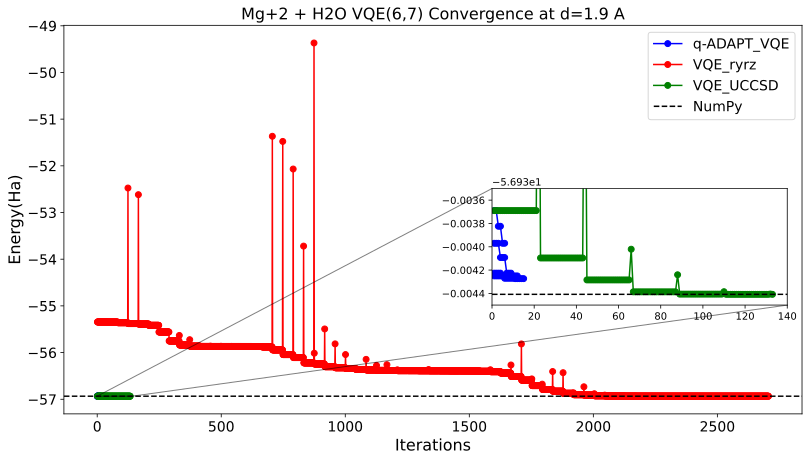

Time taken by q-ADAPT_VQE: 6.089411020278931 seconds
Total iterations by q-ADAPT_VQE: 42 iterations
Energy value reached by q-ADAPT_VQE: -56.93427325030232 Hartree


Time taken by RyRz_VQE: 74.57185196876526 seconds
Total iterations by RyRz_VQE: 2706 iterations
Energy value reached by RyRz_VQE: -56.9339119413075 Hartree


Time taken by UCCSD_VQE: 32.65448975563049 seconds
Total iterations by UCCSD_VQE: 133 iterations
Energy value reached by UCCSD_VQE: -56.93440792095965 Hartree


In [50]:
fig, ax=plt.subplots(1,1,figsize=(11,6))
fig.tight_layout()

ax.plot(interim_avqe['counts'],interim_avqe['values'], '-bo',label='q-ADAPT_VQE')
ax.plot(interim_ryrz['counts'],interim_ryrz['values'], '-ro',label='VQE_ryrz')
ax.plot(interim_uccsd['counts'],interim_uccsd['values'], '-go',label='VQE_UCCSD')

ax.axhline(y=NPresult.computed_energies[0],color='k',linestyle='--',label='NumPy')#,'--k', label='NumPy')


ax.set(xlabel='Iterations',ylabel='Energy(Ha)',title='Mg+2 + H2O VQE(6,7) Convergence at d=1.9 A')
ax.set_xlabel('Iterations',fontsize=16)
ax.set_ylabel('Energy(Ha)',fontsize=16)
ax.tick_params(axis='x',labelsize=14)
ax.tick_params(axis='y',labelsize=14)
ax.set_title('Mg+2 + H2O VQE(6,7) Convergence at d=1.9 A',fontsize=16)
ax.legend(loc='upper right',fontsize=14)


axins2 = ax.inset_axes([0.58, 0.28, 0.4, 0.3])
axins2.plot(interim_avqe['counts'],interim_avqe['values'], '-bo')
axins2.plot(interim_ryrz['counts'],interim_ryrz['values'], '-ro')
axins2.plot(interim_uccsd['counts'],interim_uccsd['values'], '-go',label='uccsd_VQE')
axins2.axhline(y=NPresult.computed_energies[0],color='k',linestyle='--',label='NumPy')

xx1, xx2, yy1, yy2 = 0,140, -56.9345, -56.9335
axins2.set_xlim(xx1, xx2)
axins2.set_ylim(yy1, yy2)

ax.indicate_inset_zoom(axins2, edgecolor="black")

plt.subplots_adjust(wspace=0.17)
plt.show()

avqe_time=interim_avqe['runtime']
avqe_tot_iter=len(interim_avqe['counts'])
avqe_final=interim_avqe['values'][-1]
print(f'Time taken by q-ADAPT_VQE: {avqe_time} seconds')
print(f'Total iterations by q-ADAPT_VQE: {avqe_tot_iter} iterations')
print(f'Energy value reached by q-ADAPT_VQE: {avqe_final} Hartree')
print('\n')
ryrz_time=interim_ryrz['runtime']
ryrz_tot_iter=len(interim_ryrz['counts'])
ryrz_final=interim_ryrz['values'][-1]
print(f'Time taken by RyRz_VQE: {ryrz_time} seconds')
print(f'Total iterations by RyRz_VQE: {ryrz_tot_iter} iterations')
print(f'Energy value reached by RyRz_VQE: {ryrz_final} Hartree')
print('\n')
uccsd_time=interim_uccsd['runtime']
uccsd_tot_iter=len(interim_uccsd['counts'])
uccsd_final=interim_uccsd['values'][-1]
print(f'Time taken by UCCSD_VQE: {uccsd_time} seconds')
print(f'Total iterations by UCCSD_VQE: {uccsd_tot_iter} iterations')
print(f'Energy value reached by UCCSD_VQE: {uccsd_final} Hartree')

fig.savefig('Plots_bitmaps/VQE_convergence.png', dpi=300,format='png',pad_inches=.2,bbox_inches='tight')

We should also take a look at the different ansatzes in the form they would be read by a quantum computer.

UCCSD ansatz:

In [35]:
provider = IBMQ.get_provider(group='deployed')
backend=provider.get_backend('ibmq_guadalupe')

transpile(UCCSD(num_spatial_orbitals=problem.num_spatial_orbitals,num_particles=problem.num_particles,qubit_converter=converter,initial_state=init_state),backend=backend,optimization_level=3).count_ops()

/opt/homebrew/Caskroom/miniforge/base/envs/qiskit-env/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/Caskroom/miniforge/base/envs/qiskit-env/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/Caskroom/miniforge/base/envs/qiskit-env/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/Caskroom/miniforge/base/envs/qiskit-env/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


OrderedDict([('cx', 1741), ('rz', 1251), ('sx', 918), ('x', 31)])

In [36]:
depth=transpile(UCCSD(num_spatial_orbitals=problem.num_spatial_orbitals,num_particles=problem.num_particles,qubit_converter=converter,initial_state=init_state),backend=backend,optimization_level=3).depth()
print(f'UCCSD_VQE ansatz depth on ibmq_guadalupe: {depth}')

UCCSD_VQE ansatz depth on ibmq_guadalupe: 2465


Heuristic RYRZ ansatz:

In [39]:
og_ansatz=EfficientSU2(num_qubits=10,su2_gates=['ry','rz'], entanglement='linear', reps=3, initial_state=init_state)
transpile(og_ansatz,backend=backend,optimization_level=3).count_ops()

OrderedDict([('rz', 125), ('sx', 80), ('cx', 27), ('x', 5)])

In [40]:
depth=transpile(og_ansatz,backend=backend).depth()
print(f'RyRz_VQE ansatz depth on ibmq_guadalupe: {depth}')

RyRz_VQE ansatz depth on ibmq_guadalupe: 35


Biggest ansatz in last ADAPT-VQE run:

In [43]:
transpile(result.raw_result.optimal_circuit,backend=backend,optimization_level=3).count_ops()


OrderedDict([('rz', 37), ('cx', 20), ('sx', 19), ('x', 1)])

In [44]:
depth=transpile(result.raw_result.optimal_circuit,backend=backend,optimization_level=3).depth()
print(f'q-ADAPT_VQE ansatz depth on ibmq_guadalupe: {depth}')

q-ADAPT_VQE ansatz depth on ibmq_guadalupe: 30


### Step 3: VQE for diffrente distances

We build a function that creates the Electronic Structrucre Problems and qubit operators for a given distance.

In [103]:
def make_driver(d):
    
    
    molecule = MoleculeInfo(
             # coordinates in Angstrom
                     symbols=['O','H','H','Mg'],
                     coords=[
                            # (d+0.504284,0.0,0.758602),
                            # (d,0.0,0.0),
                            # (d+2*0.504284,0.0,0.0),
                            # (0.0, 0.0, 0.0),
                            (0.0,0.0,0.0),
                            (-0.504284,0.0,-0.758602),
                            (0.504284,0.0,-0.758602),
                            (0.0, 0.0, d),
                            ],
                     multiplicity=1,  # = 2*spin + 1
                     charge=2,
                     units=DistanceUnit.ANGSTROM
                    )
    
    #Set driver
    #driver = PySCFDriver.from_molecule(molecule, basis="sto3g", method=MethodType.ROHF)
    #driver.xc_functional='pbe,pbe'
    driver = PySCFDriver.from_molecule(molecule, basis="6-31g*", method=MethodType.ROKS)
    driver.xc_functional='b3lyp'
    driver.conv_tol = 1e-6

    #Get properties
    problem = driver.run()
    

    return driver, problem

def make_qubit_op(d,og_problem, mapper,freeze_core):
    mol = gto.Mole()
    mol.atom = [
        # ['O',(d+0.504284,0.0,0.758602)],
        # ['H',(d,0.0,0.0),],
        # ['H',(d+2*0.504284,0.0,0.0)],
        # ['Mg',(0.0, 0.0, 0.0)]
        ['O',(0.0,0.0,0)],
        ['H',(-0.504284,0.0,-0.758602),],
        ['H',(0.504284,0.0,-0.758602)],
        ['Mg',(0.0, 0.0, d)]
        ]
    mol.charge=2
    mol.basis = '6-31g*'
    mol.spin = 0
    mol.build()
    
    #mf= scf.ROHF(mol).x2c()
    mf = dft.ROKS(mol).density_fit(auxbasis='def2-universal-jfit')
    mf.xc ='pbe,pbe'
    mf.max_cycle = 50
    mf.conv_tol = 1e-6
    
    first_run=mf.kernel()
    a = mf.stability()[0]
    if(mf.converged):
        energy=first_run
    else:
        mf.max_cycle = 80
        mf.conv_tol = 1e-6
        mf = scf.newton(mf)
        scnd_run=mf.kernel(dm0 = mf.make_rdm1(a,mf.mo_occ)) # using rdm1 constructed from stability analysis
      #mf.kernel(mf.make_rdm1()) #using the rdm from the non-converged calculation
        if(mf.converged):
            energy=scnd_run
        else:
            mf.conv_tol = 1e-6
            mf.max_cycle = 80
            mf = scf.newton(mf) #Second order solver
            energy=mf.kernel(dm0 = mf.make_rdm1())


    ao_labels = ['Mg 2p', 'O 2p']
    avas_obj = avas.AVAS(mf, ao_labels)
    avas_obj.kernel()
    weights=np.append(avas_obj.occ_weights,avas_obj.vir_weights)
    weights=(weights>0.2)*weights
    orbs=np.nonzero(weights)
    orbs=np.nonzero(weights)
    
    transformer = ActiveSpaceTransformer(
            num_electrons=(int(avas_obj.nelecas/2),int(avas_obj.nelecas/2)), #Electrons in active space
            num_spatial_orbitals=avas_obj.ncas+1, #Orbitals in active space
            active_orbitals=orbs[0].tolist().append(orbs[0][-1]+1)
        )
    # transformer = ActiveSpaceTransformer(
    #         num_electrons=(6,6), #Electrons in active space
    #         num_spatial_orbitals=7, #Orbitals in active space
    #         #active_orbitals=orbs[0].tolist().append(orbs[0][-1]+1)
    #     )
    fz_transformer=FreezeCoreTransformer(freeze_core=freeze_core)
    
    #Define the problem

    problem=transformer.transform(og_problem)
    if freeze_core==True:
        problem=fz_transformer.transform(problem)
        converter = QubitConverter(mapper)
    else:
        converter = QubitConverter(mapper,two_qubit_reduction=True, z2symmetry_reduction='auto')

    hamiltonian=problem.hamiltonian
    second_q_op = hamiltonian.second_q_op()
    
    num_spatial_orbitals = problem.num_spatial_orbitals
    num_particles = problem.num_particles
    
    qubit_op = converter.convert(second_q_op,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
    
        

    
    return qubit_op, problem,  converter, energy
    

Noise_model options for noisy simulations

In [104]:
from qiskit.providers.fake_provider import FakeManila, FakeNairobi, FakeMontreal, FakeGuadalupe

#Noisy simulator
backend_aer = AerSimulator(method='density_matrix',device='CPU')
device_backend=FakeGuadalupe()
device = AerSimulator.from_backend(device_backend)
noise_model = None
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

sim_opt=SimulatorOptions(
    noise_model=noise_model,
    seed_simulator=62,
    coupling_map=coupling_map,
    basis_gates=basis_gates
)

Qiskit Runtime Options

In [105]:
#Runtime Estimator options
ts_opt=TranspilationOptions(
    skip_transpilation=True
)

sim_opt=SimulatorOptions(
    noise_model=noise_model,
    seed_simulator=62,
    coupling_map=coupling_map,
    basis_gates=basis_gates
)
res_opt=ResilienceOptions(
    noise_factors=tuple(range(1, 6, 2)),
    noise_amplifier='LocalFoldingAmplifier',
    extrapolator='LinearExtrapolator'
)

ex_opt=ExecutionOptions(
    shots=1024
)
est_options=Options(
    resilience_level=2,
    #optimization_level=3,
    execution=ex_opt,
    resilience=res_opt,
    #simulator=sim_opt,
    #transpilation=ts_opt
)

Calculation options

In [106]:
distances = np.arange(0.3, 3.6, 0.3)
optimizer = SLSQP(maxiter=1000)
#optimizer = SPSA(maxiter=100)
mapper=ParityMapper()


seed = 62
algorithm_globals.random_seed = seed

Calculations:

In [10]:
#Local Calculations

counts = []
values = []
params = []
meta_dicts=[]


ryrz_results,ryrz_problems,dists,pyscf_energies=local_RYRZ_solver(                                               distances=distances,
                                                                          mapper=mapper,
                                                                          optimizer=optimizer,freeze_core=False)

'Evaluation: 5930, Energy: -51.17081212484191, Mean: -56.910134790002104, STD: 14.731932840873032, Metadata: {}'

In [13]:
counts = []
values = []
params = []
meta_dicts=[]


uccsd_results,vqe_problems,dists,pyscf_energies=local_UCCSD_solver(                                               distances=distances,
                                                                          mapper=mapper,
                                                                          optimizer=optimizer,freeze_core=False)

'Evaluation: 648, Energy: -51.17009064110654, Mean: -56.02046984967199, STD: 15.44961570771098, Metadata: {}'

In [107]:
#Local calculations-ADAPT VQE

counts = []
values = []
params = []
meta_dicts=[]


avqe_results,avqe_problems,dists,pyscf_energies=adapt_solver(distances=distances,
                                                                          mapper=mapper,
                                                                          optimizer=optimizer,freeze_core=False)

'Evaluation: 10, Energy: -51.170286708488014, Mean: -61.281446693718436, STD: 12.924119234824731, Metadata: {}'

We can calculate the groundstate with numpy as well. This will serve as a benchmark for the VQE.

In [15]:
classic_results,dists=classic_solver(distances=distances,
                             mapper=mapper,
                             optimizer=optimizer,
                             freeze_core=False
                            )

converged SCF energy = -233.036314605562
<class 'pyscf.df.df_jk.density_fit.<locals>.DensityFitting'> wavefunction is stable in the internal stability analysis
converged SCF energy = -268.658419761889
<class 'pyscf.df.df_jk.density_fit.<locals>.DensityFitting'> wavefunction is stable in the internal stability analysis
converged SCF energy = -273.531032202168
<class 'pyscf.df.df_jk.density_fit.<locals>.DensityFitting'> wavefunction is stable in the internal stability analysis
converged SCF energy = -275.014052803726
<class 'pyscf.df.df_jk.density_fit.<locals>.DensityFitting'> wavefunction is stable in the internal stability analysis
converged SCF energy = -275.40265068599
<class 'pyscf.df.df_jk.density_fit.<locals>.DensityFitting'> wavefunction is stable in the internal stability analysis
converged SCF energy = -275.478859766864
<class 'pyscf.df.df_jk.density_fit.<locals>.DensityFitting'> wavefunction is stable in the internal stability analysis
converged SCF energy = -275.47762165946
<

We can save results and retrieve later:

In [109]:
write_list(avqe_problems,'MG+H2O/simulations/avqe_problems')

Done writing list into a binary file


In [16]:
write_list(ryrz_results,'MG+H2O/simulations/ryrz_results')
write_list(uccsd_results,'MG+H2O/simulations/uccsd_results')
write_list(avqe_results,'MG+H2O/simulations/avqe_results')
write_list(classic_results,'MG+H2O/simulations/classic_results')
write_list(pyscf_energies,'MG+H2O/simulations/pyscf_energies')

Done writing list into a binary file
Done writing list into a binary file
Done writing list into a binary file
Done writing list into a binary file
Done writing list into a binary file


Extract the energy values from the results and plot them:

In [210]:
avqe_energies=[]
#vqe_energies=[]
classic_energies=[]
for i in range(len(dists)):
            avqe_energies.append(avqe_results[i].total_energies[0])
            #vqe_energies.append(vqe_problems[i].interpret(vqe_results[i]).total_energies[0])
            classic_energies.append(classic_results[i].total_energies[0])

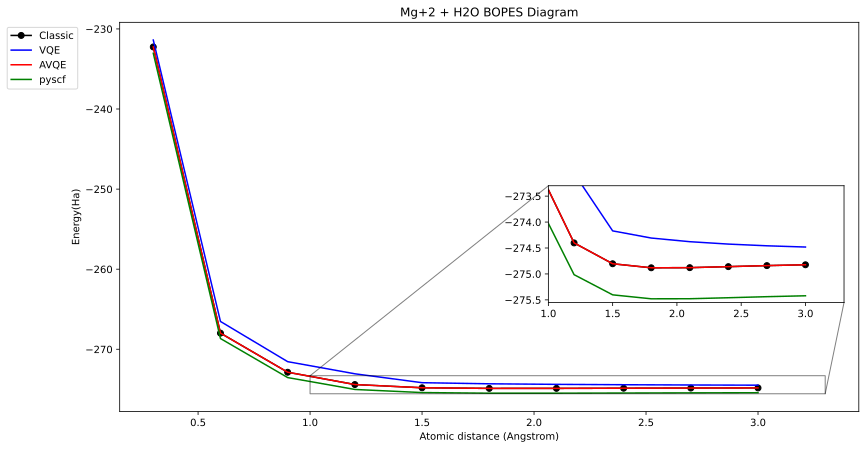

In [266]:
fig, ax=plt.subplots(1,1,figsize=(11,6))
fig.tight_layout()

ax.plot(dists,classic_energies, '-ko',label="Classic")
ax.plot(dists, vqe_energies, '-b',label="VQE")
ax.plot(dists, avqe_energies, '-r',label="AVQE")
ax.plot(dists, pyscf_energies, '-g',label="pyscf")


ax.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram')
ax.legend(bbox_to_anchor=(-.05,1))


axins2 = ax.inset_axes([0.58, 0.28, 0.4, 0.3])
axins2.plot(dists,classic_energies, '-ko',label="Classic")
axins2.plot(dists, vqe_energies, '-b',label="VQE")
axins2.plot(dists, avqe_energies, '-r',label="AVQE")
axins2.plot(dists, pyscf_energies, '-g',label="pyscf")

xx1, xx2, yy1, yy2 = 1.0,3.3, -275.55, -273.3
axins2.set_xlim(xx1, xx2)
axins2.set_ylim(yy1, yy2)

ax.indicate_inset_zoom(axins2, edgecolor="black")

plt.subplots_adjust(wspace=0.17)
plt.show()

Now we interpolate and calculate the minimum

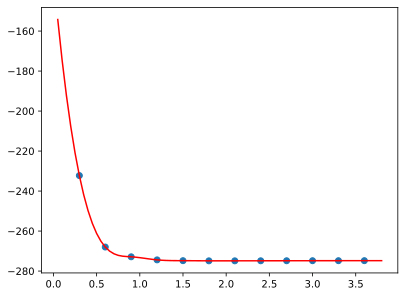

In [266]:
import scipy.interpolate as interp
from scipy.optimize import minimize_scalar

newx=dists
newy=avqe_energies

tck = interp.splrep(newx, newy, k=3)

popt = lambda x: interp.splev(x, tck)
popt_d = lambda x: interp.splev(x, tck, der=1)

result = minimize_scalar(popt)
assert result.success

min_x = result.x
min_val = result.fun
x_left = min(x_values)
x_right = max(x_values)

plt.scatter(x_values, y_values)
x = np.arange(min(x_values) - 0.25, max(x_values) + 0.25, 0.05)
plt.plot(x, popt(x), 'r-')


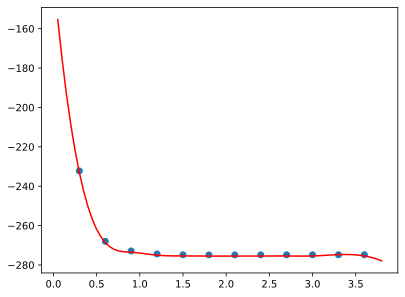

In [264]:
newx=dists
newy=pyscf_energies

tck = interp.splrep(newx, newy, k=3)

popt = lambda x: interp.splev(x, tck)
popt_d = lambda x: interp.splev(x, tck, der=1)

result = minimize_scalar(popt)
assert result.success

min_x = result.x
min_val = result.fun
x_left = min(x_values)
x_right = max(x_values)

plt.scatter(x_values, y_values)
x = np.arange(min(x_values) - 0.25, max(x_values) + 0.25, 0.05)
plt.plot(x, popt(x), 'r-')


In [265]:
min_x

1.911041578561376

In [267]:
min_x

1.9144214922198926

In [254]:
popt(x_values)

array([-232.2450494 , -267.98239318, -272.86390229, -274.40156926,
       -274.803249  , -274.88095385, -274.87850825, -274.85897318,
       -274.83915632, -274.82303931, -274.80967342, -274.80039497])

In [ ]:
#Runtime Estimator options
ts_opt=TranspilationOptions(
    skip_transpilation=True
)

sim_opt=SimulatorOptions(
    noise_model=noise_model,
    seed_simulator=62,
    coupling_map=coupling_map,
    basis_gates=basis_gates
)
res_opt=ResilienceOptions(
    noise_factors=tuple(range(1, 6, 2)),
    noise_amplifier='LocalFoldingAmplifier',
    extrapolator='LinearExtrapolator'
)

ex_opt=ExecutionOptions(
    shots=1024
)
est_options=Options(
    #resilience_level=2,
    #optimization_level=3,
    execution=ex_opt,
    #resilience=res_opt,
    #simulator=sim_opt,
    #transpilation=ts_opt
)

results,problems,dists=sim_solver(distances=distances,
                             mapper=mapper,
                             optimizer=optimizer,
                             freeze_core=False,
                             est_options=est_options,
                             mapomatic=False,
                             device='ibmq_kolkata'    
)

In [ ]:
counts = []
values = []
params = []
meta_dicts=[]


real_results,real_problems,dists=real_solver(distances=distances,
                                            mapper=mapper,
                                            optimizer=optimizer,
                                            freeze_core=False,
                                            est_options=est_options,
                                            device='ibmq_montreal'
                                          )

## Mg+2 + N2

### Step 1: Build Qubit Operator.

In [284]:
#Define Molecule
d=1.5
molecule = MoleculeInfo(
             # coordinates in Angstrom
                     symbols=['N','N','Mg'],
                     coords=[
                            (0.0,0.0,0.0),
                            (1.0977,0.0,0),
                            (d+1.0977, 0.0,0.0),
                            ],
                     multiplicity=1,  # = 2*spin + 1
                     charge=2,
                     units=DistanceUnit.ANGSTROM
                    )

#Set driver
driver = PySCFDriver.from_molecule(molecule, basis="6-31g*", method=MethodType.RKS)
driver.xc_functional='b3lyp'

#Get properties of origianl problem
og_problem = driver.run()
    
#particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
#num_a_electrons = problem.num_alpha
#num_b_electrons = propblem.num_beta
og_num_particles=og_problem.num_particles

og_num_spatial_orbitals =og_problem.num_spatial_orbitals

og_rep_energy = og_problem.nuclear_repulsion_energy
    
# Check the occupation of the spin orbitals
og_PN_property = og_problem.properties.particle_number
mol = gto.Mole()
mol.atom = [
        ['N',(0.0,0.0,0)],
        ['N',(1.0977,0.0,0.0),],
        ['Mg',(d+1.0977, 0.0, 0.0)]
        ]
mol.charge=2
mol.basis = '6-31g*'
mol.spin = 0
mol.build()

mf = scf.RKS(mol).x2c()
mf.kernel()

ao_labels = ['Mg 2p', 'N 2p']#,'H 1s']
avas_obj = avas.AVAS(mf, ao_labels)
avas_obj.kernel()
weights=np.append(avas_obj.occ_weights,avas_obj.vir_weights)
weights=(weights>0.1)*weights
orbs=np.nonzero(weights)


# Define the active space
# (selected automatically around the HOMO and LUMO, ordered by energy)
# transformer = ActiveSpaceTransformer(
#             num_electrons=(int(avas_obj.nelecas/2),int(avas_obj.nelecas/2)), #Electrons in active space
#             num_spatial_orbitals=avas_obj.ncas+1, #Orbitals in active space
#             active_orbitals=orbs[0].tolist().append(orbs[0][-1]+1)
#         )

### Uncomment below for manual selection

transformer = ActiveSpaceTransformer(
            num_electrons=(6,6), #Electrons in active space
            num_spatial_orbitals=7, #Orbitals in active space
            #active_orbitals=orbs[0].tolist().append(orbs[0][-1]+1)
        )

fz_transformer=FreezeCoreTransformer(freeze_core=True) # Freeze core transformer in case we want to freeze core electrons
    
#Define the problem

problem=transformer.transform(og_problem)

#fz_problem=fz_transformer.transform(og_problem)

#Get Hamiltonian form driver

#og_hamiltonian=og_problem.hamiltonian
#og_second_q_op = og_hamiltonian.second_q_op()
hamiltonian=problem.hamiltonian
second_q_op = hamiltonian.second_q_op()
#fz_hamiltonian=fz_problem.hamiltonian
#fz_second_q_op = fz_hamiltonian.second_q_op() 

#og_num_spatial_orbitals = og_problem.num_spatial_orbitals
#og_num_particles = og_problem.num_particles

#Get Properties of transformed problem
    
num_spatial_orbitals = problem.num_spatial_orbitals
num_particles = problem.num_particles

#fz_num_spatial_orbitals = fz_problem.num_spatial_orbitals
#fz_num_particles = fz_problem.num_particles
    
mapper=ParityMapper()

#Get Pauli OP

converter = QubitConverter(mapper,two_qubit_reduction=True, z2symmetry_reduction='auto') # Using two qubit reduction and z2. symmetries to taper off qubits.
simple_converter = QubitConverter(mapper)
    
#Final OP
#og_qubit_op = converter.convert(og_second_q_op,num_particles=og_num_particles,sector_locator=og_problem.symmetry_sector_locator)
qubit_op = converter.convert(second_q_op,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
#fz_qubit_op = converter.convert(fz_second_q_op)

converged SCF energy = -307.181689580779


Now we can check how many qubits are required for the given Active Space. Note on the code we opted for an automated method for active space selection available on PySCF, this can be done manually as well.

In [285]:
qubit_op.num_qubits

11

### Step2: VQE

With the operator constructed we do the VQE calculation:

In [290]:
#Construct the initial state for the VQE algorithm:
init_state = HartreeFock(problem.num_spatial_orbitals,problem.num_particles, converter)

#Build the ansatz based on problem properties

#ansatz = UCCSD(num_spatial_orbitals=problem.num_spatial_orbitals,num_particles=problem.num_particles,qubit_converter=converter,initial_state=init_state) # Uncomment for UCCSD ansatz

#ansatz = EfficientSU2(num_qubits=qubit_op.num_qubits,su2_gates=['ry'], entanglement='linear', reps=3, initial_state=init_state) # Uncomment for Heuristic Ansatz

#####Qubit-ADAPT-VQE ansatz

ansatz = UCCSD(num_spatial_orbitals=problem.num_spatial_orbitals,num_particles=problem.num_particles,qubit_converter=converter,initial_state=init_state)

operator_pool = []
for op in ansatz.operators:
    sop = op.primitive
    for pauli, coeff in zip(sop.paulis, sop.coeffs):
        if sum(pauli.x & pauli.z) % 2 == 0:
            continue
    operator_pool.append(PauliSumOp(coeff * SparsePauliOp(pauli)))

ansatz = EvolvedOperatorAnsatz(
        operators=operator_pool,
        initial_state=init_state,
        )

        
# Set initial parameters of the ansatz (we set zeros as we set the initial stae into the ansatz.)
initial_point=np.zeros(ansatz.num_parameters)

##Choose ooptimizer

optimizer = SLSQP(maxiter=1000)
#optimizer = SPSA(maxiter=150)

#Seed for required RNG

seed = 62
algorithm_globals.random_seed = seed

##Noise model in case we want to do noisy simulations

from qiskit.providers.fake_provider import FakeManila, FakeNairobi, FakeMontreal, FakeGuadalupe

device_backend=FakeGuadalupe()
device = AerSimulator.from_backend(device_backend)
noise_model = None
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

### Qiskit Runtime options in case we want to run anything on the cloud

ts_opt=TranspilationOptions(
    skip_transpilation=True
)

sim_opt=SimulatorOptions(
    noise_model=noise_model,
    seed_simulator=62,
    coupling_map=coupling_map,
    basis_gates=basis_gates
)
res_opt=ResilienceOptions(
    noise_factors=tuple(range(1, 6, 2)),
    noise_amplifier='LocalFoldingAmplifier',
    extrapolator='LinearExtrapolator'
)

ex_opt=ExecutionOptions(
    shots=1024
)
est_options=Options(
    #resilience_level=2,
    #optimization_level=3,
    execution=ex_opt,
    #resilience=res_opt,
    #simulator=sim_opt,
    #transpilation=ts_opt
)

#Local simulator options for local simulations

bck_opt={'method':'statevector',
         'device':'CPU',
         'precision':'double',
         'extended_stabilizer_sampling_method':'resampled_metropolis'
                }
run_opt={'shots':32,
                }

#estimator = AerEstimator([ansatz], [qubit_op],backend_options=bck_opt,run_options=run_opt) #AerSimulator, worse performnace
estimator= Estimator([ansatz],[qubit_op]) # Base terra simulator, better performnace

#####
#SETUP AND RUN VQE LOCALLY
#####
    
counts = []
values = []
params= []
deviation = []
    
vqe = VQE(estimator, ansatz, optimizer,initial_point=initial_point, callback=callback)

#### If Running ADAPT-VQE
adapt_vqe=AdaptVQE(vqe)
adapt_vqe.supports_aux_operators = lambda: False ## If set to True will measure Angular Momentum, Magnetization, Particle Number and ZDipole as well.
adapt_vqe.threshold=1e-3
adapt_vqe.max_iterations=4
adapt_vqe.delta=1e-4
#####
        
solver = GroundStateEigensolver(converter, adapt_vqe)
result = solver.solve(problem)

#result = vqe.compute_minimum_eigenvalue(qubit_op) # in case you don't want the intrepreted result.

#####
#SETUP AND RUN VQE WITH RUNTIME
#####

# with Session(service=service, backend='ibmq_qasm_simulator') as session:
#     # Prepare primitive
#     rt_estimator = RuntimeEstimator(session=session)#,options=est_options)
#     # Set up algorithm
#     custom_vqe = VQE(rt_estimator, ansatz, optimizer,initial_point=initial_point, callback=callback)
#     adapt_vqe=AdaptVQE(custom_vqe)
#     adapt_vqe.supports_aux_operators = lambda: False
#     adapt_vqe.threshold=1e-3
#     adapt_vqe.max_iterations=4
#     adapt_vqe.delta=1e-4
#     # Run algorithm
#     solver = GroundStateEigensolver(converter, custom_vqe)
#     result = solver.solve(problem)

#     #result = adapt_vqe.compute_minimum_eigenvalue(qubit_op)

'Evaluation: 35, Energy: -50.04827090417027, Mean: -50.04595911717521, STD: 0.0052579927761962, Metadata: {}'

After this we can print the interpreted result:

In [291]:
print(result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -378.050786986278
  - computed part:      -50.048270904179
  - ActiveSpaceTransformer extracted energy part: -328.002516082098
~ Nuclear repulsion energy (Hartree): 70.367386026495
> Total ground state energy (Hartree): -307.683400959782
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [73.42776521  0.0  0.0]
 


 Or get the raw_result:

In [293]:
print(result.raw_result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 35,
    'eigenvalue': -50.04827090417941,
    'final_max_gradient': -0.008488896778749259,
    'num_iterations': 4,
    'optimal_circuit': <qiskit.circuit.library.evolved_operator_ansatz.EvolvedOperatorAnsatz object at 0x393e882e0>,
    'optimal_parameters': {   ParameterVectorElement(t[0]): -1.1419404163680857,
                              ParameterVectorElement(t[2]): -0.30736134684585115,
                              ParameterVectorElement(t[3]): -0.006726690875818064,
                              ParameterVectorElement(t[1]): -0.22816652559723555},
    'optimal_point': array([-1.14194042, -0.22816653, -0.30736135, -0.00672669]),
    'optimal_value': -50.04827090417941,
    'optimizer_evals': None,
    'optimizer_result': <qiskit.algorithms.optimizers.optimizer.OptimizerResult object at 0x36aae3a90>,
    'optimizer_time': 1.6462719440460205,
    'termination_criterion': <TerminationCriterion.MAXIMUM: 'Maximum number 

Just for compariosn we can take a look at the different ansatzes in the form they would be read by a quantum computer

Full circuit ADAPT-VQE:

In [85]:
provider = IBMQ.get_provider(group='deployed')
backend=provider.get_backend('ibmq_guadalupe')

transpile(ansatz,backend=backend,optimization_level=3).count_ops()

OrderedDict([('cx', 263), ('rz', 223), ('sx', 154), ('x', 3)])

In [169]:
transpile(ansatz,backend=backend,optimization_level=3).depth()

313

Heuristic RYRZ ansatz:

In [166]:
og_ansatz=EfficientSU2(num_qubits=10,su2_gates=['ry'], entanglement='linear', reps=3)#, initial_state=init_state)
transpile(og_ansatz,backend=backend,optimization_level=3).count_ops()

OrderedDict([('sx', 80), ('rz', 80), ('cx', 27)])

In [170]:
transpile(og_ansatz,backend=backend).depth()

29

Biggest ansatz in last ADAPT-VQE run:

In [167]:
transpile(result.raw_result.optimal_circuit,backend=backend,optimization_level=3).count_ops()


OrderedDict([('rz', 28), ('sx', 15), ('cx', 10), ('x', 2)])

In [171]:
transpile(result.raw_result.optimal_circuit,backend=backend,optimization_level=3).depth()


16

### Step 3: VQE for diffrente distances

We build a function that creates the Electronic Structrucre Problems and qubit operators for a given distance.

In [110]:
def make_driver(d):
    
    
    molecule = MoleculeInfo(
             # coordinates in Angstrom
                     symbols=['N','N','Mg'],
                     coords=[
                            (0.0,0.0,0.0),
                            (1.0977,0.0,0),
                            (d+1.0977, 0.0,0.0)],
                     multiplicity=1,  # = 2*spin + 1
                     charge=2,
                     units=DistanceUnit.ANGSTROM
                    )
    
    #Set driver
    #driver = PySCFDriver.from_molecule(molecule, basis="sto3g", method=MethodType.ROHF)
    #driver.xc_functional='pbe,pbe'
    driver = PySCFDriver.from_molecule(molecule, basis="6-31g*", method=MethodType.ROKS)
    driver.xc_functional='b3lyp'
    driver.conv_tol = 1e-6

    #Get properties
    problem = driver.run()
    

    return driver, problem

def make_qubit_op(d,og_problem, mapper,freeze_core):
    mol = gto.Mole()
    mol.atom = [
        ['N',(0.0,0.0,0)],
        ['N',(1.0977,0.0,0.0),],
        ['Mg',(d+1.0977, 0.0, 0.0)]
        ]
    mol.charge=2
    mol.basis = '6-31g*'
    mol.spin = 0
    mol.build()
    
    #mf= scf.ROHF(mol).x2c()
    mf = dft.ROKS(mol).density_fit(auxbasis='def2-universal-jfit')
    mf.xc ='pbe,pbe'
    mf.max_cycle = 50
    mf.conv_tol = 1e-6
    
    first_run=mf.kernel()
    a = mf.stability()[0]
    if(mf.converged):
        energy=first_run
    else:
        mf.max_cycle = 80
        mf.conv_tol = 1e-6
        mf = scf.newton(mf)
        scnd_run=mf.kernel(dm0 = mf.make_rdm1(a,mf.mo_occ)) # using rdm1 constructed from stability analysis
      #mf.kernel(mf.make_rdm1()) #using the rdm from the non-converged calculation
        if(mf.converged):
            energy=scnd_run
        else:
            mf.conv_tol = 1e-6
            mf.max_cycle = 80
            mf = scf.newton(mf) #Second order solver
            energy=mf.kernel(dm0 = mf.make_rdm1())


    ao_labels = ['Mg 2p', 'N 2p']
    avas_obj = avas.AVAS(mf, ao_labels)
    avas_obj.kernel()
    weights=np.append(avas_obj.occ_weights,avas_obj.vir_weights)
    weights=(weights>0.2)*weights
    orbs=np.nonzero(weights)
    orbs=np.nonzero(weights)
    
    # transformer = ActiveSpaceTransformer(
    #         num_electrons=(int(avas_obj.nelecas/2),int(avas_obj.nelecas/2)), #Electrons in active space
    #         num_spatial_orbitals=avas_obj.ncas+1, #Orbitals in active space
    #         active_orbitals=orbs[0].tolist().append(orbs[0][-1]+1)
    #     )
    transformer = ActiveSpaceTransformer(
            num_electrons=(6,6), #Electrons in active space
            num_spatial_orbitals=7, #Orbitals in active space
            #active_orbitals=orbs[0].tolist().append(orbs[0][-1]+1)
        )
    fz_transformer=FreezeCoreTransformer(freeze_core=freeze_core)
    
    #Define the problem

    problem=transformer.transform(og_problem)
    if freeze_core==True:
        problem=fz_transformer.transform(problem)
        converter = QubitConverter(mapper)
    else:
        converter = QubitConverter(mapper,two_qubit_reduction=True, z2symmetry_reduction='auto')

    hamiltonian=problem.hamiltonian
    second_q_op = hamiltonian.second_q_op()
    
    num_spatial_orbitals = problem.num_spatial_orbitals
    num_particles = problem.num_particles
    
    qubit_op = converter.convert(second_q_op,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
    
        

    
    return qubit_op, problem,  converter, energy
    

Noise_model options for noisy simulations

In [23]:
from qiskit.providers.fake_provider import FakeManila, FakeNairobi, FakeMontreal, FakeGuadalupe

#Noisy simulator
backend_aer = AerSimulator(method='density_matrix',device='CPU')
device_backend=FakeGuadalupe()
device = AerSimulator.from_backend(device_backend)
noise_model = None
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

sim_opt=SimulatorOptions(
    noise_model=noise_model,
    seed_simulator=62,
    coupling_map=coupling_map,
    basis_gates=basis_gates
)

Qiskit Runtime Options

In [24]:
#Runtime Estimator options
ts_opt=TranspilationOptions(
    skip_transpilation=True
)

sim_opt=SimulatorOptions(
    noise_model=noise_model,
    seed_simulator=62,
    coupling_map=coupling_map,
    basis_gates=basis_gates
)
res_opt=ResilienceOptions(
    noise_factors=tuple(range(1, 6, 2)),
    noise_amplifier='LocalFoldingAmplifier',
    extrapolator='LinearExtrapolator'
)

ex_opt=ExecutionOptions(
    shots=1024
)
est_options=Options(
    resilience_level=2,
    #optimization_level=3,
    execution=ex_opt,
    resilience=res_opt,
    #simulator=sim_opt,
    #transpilation=ts_opt
)

Calculation options

In [25]:
distances = np.arange(0.3, 3.6, 0.3)
optimizer = SLSQP(maxiter=1000)
#optimizer = SPSA(maxiter=100)
mapper=ParityMapper()


seed = 62
algorithm_globals.random_seed = seed

Calculations:

In [26]:
#Local Calculations

counts = []
values = []
params = []
meta_dicts=[]


ryrz_results,ryrz_problems,dists,pyscf_energies=local_RYRZ_solver(                                               distances=distances,
                                                                          mapper=mapper,
                                                                          optimizer=optimizer,freeze_core=False)

'Evaluation: 1064, Energy: -44.06229102598702, Mean: -50.258827746753646, STD: 5.00488304709211, Metadata: {}'

In [27]:
counts = []
values = []
params = []
meta_dicts=[]


uccsd_results,vqe_problems,dists,pyscf_energies=local_UCCSD_solver(                                               distances=distances,
                                                                          mapper=mapper,
                                                                          optimizer=optimizer,freeze_core=False)

'Evaluation: 195, Energy: -44.24249186158734, Mean: -50.93767742273031, STD: 5.1843583560174, Metadata: {}'

In [111]:
#Local calculations-ADAPT VQE

counts = []
values = []
params = []
meta_dicts=[]


avqe_results,avqe_problems,dists,pyscf_energies=adapt_solver(distances=distances,
                                                                          mapper=mapper,
                                                                          optimizer=optimizer,freeze_core=False)

'Evaluation: 15, Energy: -44.2424374459856, Mean: -50.44707289451723, STD: 4.956936064062676, Metadata: {}'

We can calculate the groundstate with numpy as well. This will serve as a benchmark for the VQE.

In [29]:
classic_results,dists=classic_solver(distances=distances,
                             mapper=mapper,
                             optimizer=optimizer,
                             freeze_core=False
                            )

converged SCF energy = -270.330806781682
<class 'pyscf.df.df_jk.density_fit.<locals>.DensityFitting'> wavefunction is stable in the internal stability analysis
SCF not converged.
SCF energy = -302.077851387339
<class 'pyscf.df.df_jk.density_fit.<locals>.DensityFitting'> wavefunction is stable in the internal stability analysis

WARN: HOMO -0.7675990407711359 > LUMO -0.7934793059049878 was found in the canonicalized orbitals.

converged SCF energy = -302.216803580177
converged SCF energy = -306.593465892617
<class 'pyscf.df.df_jk.density_fit.<locals>.DensityFitting'> wavefunction is stable in the internal stability analysis
converged SCF energy = -307.986815727538
<class 'pyscf.df.df_jk.density_fit.<locals>.DensityFitting'> wavefunction is stable in the internal stability analysis
converged SCF energy = -308.426177172242
<class 'pyscf.df.df_jk.density_fit.<locals>.DensityFitting'> wavefunction is stable in the internal stability analysis
converged SCF energy = -308.540487078527
<class '

We can save results and retrieve later:

In [112]:
write_list(avqe_problems,'MG+N2/simulations/avqe_problems')

Done writing list into a binary file


In [30]:
write_list(ryrz_results,'MG+N2/simulations/ryrz_results')
write_list(uccsd_results,'MG+N2/simulations/uccsd_results')
write_list(avqe_results,'MG+N2/simulations/avqe_results')
write_list(classic_results,'MG+N2/simulations/classic_results')
write_list(pyscf_energies,'MG+N2/simulations/pyscf_energies')

Done writing list into a binary file
Done writing list into a binary file
Done writing list into a binary file
Done writing list into a binary file
Done writing list into a binary file


Extract the energy values from the results and plot them:

In [ ]:
avqe_energies=[]
vqe_energies=[]
classic_energies=[]
for i in range(len(dists)):
            avqe_energies.append(avqe_results[i].total_energies)
            vqe_energies.append(vqe_problems[i].interpret(vqe_results[i]).total_energies)
            classic_energies.append(classic_results[i].total_energies)

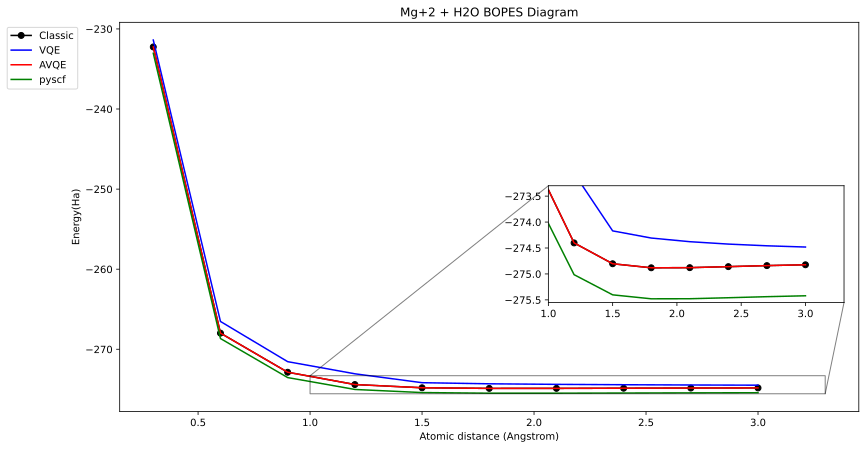

In [266]:
fig, ax=plt.subplots(1,1,figsize=(11,6))
fig.tight_layout()

ax.plot(dists,classic_energies, '-ko',label="Classic")
ax.plot(dists, vqe_energies, '-b',label="VQE")
ax.plot(dists, avqe_energies, '-r',label="AVQE")
ax.plot(dists, pyscf_energies, '-g',label="pyscf")


ax.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram')
ax.legend(bbox_to_anchor=(-.05,1))


axins2 = ax.inset_axes([0.58, 0.28, 0.4, 0.3])
axins2.plot(dists,classic_energies, '-ko',label="Classic")
axins2.plot(dists, vqe_energies, '-b',label="VQE")
axins2.plot(dists, avqe_energies, '-r',label="AVQE")
axins2.plot(dists, pyscf_energies, '-g',label="pyscf")

xx1, xx2, yy1, yy2 = 1.0,3.3, -275.55, -273.3
axins2.set_xlim(xx1, xx2)
axins2.set_ylim(yy1, yy2)

ax.indicate_inset_zoom(axins2, edgecolor="black")

plt.subplots_adjust(wspace=0.17)
plt.show()

## Mg+2 + CO2

First we do a single calculation for a given separations distance d.

### Step 1: Build Qubit Operator.

In [278]:
#Define Molecule
d=1.5
molecule = MoleculeInfo(
             # coordinates in Angstrom
                     symbols=['O','C','O','Mg'],
                     coords=[
                            (-1.1621,0.0,0.0),
                            (0.0,0.0,0),
                            (1.1621,0.0,0),
                            (d+1.1621, 0.0,0.0),
                            ],
                     multiplicity=1,  # = 2*spin + 1
                     charge=2,
                     units=DistanceUnit.ANGSTROM
                    )

#Set driver
driver = PySCFDriver.from_molecule(molecule, basis="6-31g*", method=MethodType.RKS)
driver.xc_functional='b3lyp'

#Get properties of origianl problem
og_problem = driver.run()
    
#particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
#num_a_electrons = problem.num_alpha
#num_b_electrons = propblem.num_beta
og_num_particles=og_problem.num_particles

og_num_spatial_orbitals =og_problem.num_spatial_orbitals

og_rep_energy = og_problem.nuclear_repulsion_energy
    
# Check the occupation of the spin orbitals
og_PN_property = og_problem.properties.particle_number
mol = gto.Mole()
mol.atom = [
        ['C',(0.0,0.0,0)],
        ['O',(-1.1621,0.0,0.0),],
        ['O',(1.1621,0.0,0.0)],
        ['Mg',(d+1.1621, 0.0, 0.0)]
        ]
mol.charge=2
mol.basis = '6-31g*'
mol.spin = 0
mol.build()

mf = scf.RKS(mol).x2c()
mf.kernel()

ao_labels = ['Mg 2p', 'O 2p']#,'H 1s']
avas_obj = avas.AVAS(mf, ao_labels)
avas_obj.kernel()
weights=np.append(avas_obj.occ_weights,avas_obj.vir_weights)
weights=(weights>0.1)*weights
orbs=np.nonzero(weights)


# Define the active space
# (selected automatically around the HOMO and LUMO, ordered by energy)
# transformer = ActiveSpaceTransformer(
#             num_electrons=(int(avas_obj.nelecas/2),int(avas_obj.nelecas/2)), #Electrons in active space
#             num_spatial_orbitals=avas_obj.ncas+1, #Orbitals in active space
#             active_orbitals=orbs[0].tolist().append(orbs[0][-1]+1)
#         )

### Uncomment below for manual selection

transformer = ActiveSpaceTransformer(
            num_electrons=(6,6), #Electrons in active space
            num_spatial_orbitals=7, #Orbitals in active space
            #active_orbitals=orbs[0].tolist().append(orbs[0][-1]+1)
        )

fz_transformer=FreezeCoreTransformer(freeze_core=True) # Freeze core transformer in case we want to freeze core electrons
    
#Define the problem

problem=transformer.transform(og_problem)

#fz_problem=fz_transformer.transform(og_problem)

#Get Hamiltonian form driver

#og_hamiltonian=og_problem.hamiltonian
#og_second_q_op = og_hamiltonian.second_q_op()
hamiltonian=problem.hamiltonian
second_q_op = hamiltonian.second_q_op()
#fz_hamiltonian=fz_problem.hamiltonian
#fz_second_q_op = fz_hamiltonian.second_q_op() 

#og_num_spatial_orbitals = og_problem.num_spatial_orbitals
#og_num_particles = og_problem.num_particles

#Get Properties of transformed problem
    
num_spatial_orbitals = problem.num_spatial_orbitals
num_particles = problem.num_particles

#fz_num_spatial_orbitals = fz_problem.num_spatial_orbitals
#fz_num_particles = fz_problem.num_particles
    
mapper=ParityMapper()

#Get Pauli OP

converter = QubitConverter(mapper,two_qubit_reduction=True, z2symmetry_reduction='auto') # Using two qubit reduction and z2. symmetries to taper off qubits.
simple_converter = QubitConverter(mapper)
    
#Final OP
#og_qubit_op = converter.convert(og_second_q_op,num_particles=og_num_particles,sector_locator=og_problem.symmetry_sector_locator)
qubit_op = converter.convert(second_q_op,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
#fz_qubit_op = converter.convert(fz_second_q_op)

converged SCF energy = -385.859885544267


Now we can check how many qubits are required for the given Active Space. Note on the code we opted for an automated method for active space selection available on PySCF, this can be done manually as well.

In [279]:
qubit_op.num_qubits

11

### Step2: VQE

With the operator constructed we do the VQE calculation:

In [280]:
#Construct the initial state for the VQE algorithm:
init_state = HartreeFock(problem.num_spatial_orbitals,problem.num_particles, converter)

#Build the ansatz based on problem properties

#ansatz = UCCSD(num_spatial_orbitals=problem.num_spatial_orbitals,num_particles=problem.num_particles,qubit_converter=converter,initial_state=init_state) # Uncomment for UCCSD ansatz

#ansatz = EfficientSU2(num_qubits=qubit_op.num_qubits,su2_gates=['ry'], entanglement='linear', reps=3, initial_state=init_state) # Uncomment for Heuristic Ansatz

#####Qubit-ADAPT-VQE ansatz

ansatz = UCCSD(num_spatial_orbitals=problem.num_spatial_orbitals,num_particles=problem.num_particles,qubit_converter=converter,initial_state=init_state)

operator_pool = []
for op in ansatz.operators:
    sop = op.primitive
    for pauli, coeff in zip(sop.paulis, sop.coeffs):
        if sum(pauli.x & pauli.z) % 2 == 0:
            continue
    operator_pool.append(PauliSumOp(coeff * SparsePauliOp(pauli)))

ansatz = EvolvedOperatorAnsatz(
        operators=operator_pool,
        initial_state=init_state,
        )

        
# Set initial parameters of the ansatz (we set zeros as we set the initial stae into the ansatz.)
initial_point=np.zeros(ansatz.num_parameters)

##Choose ooptimizer

optimizer = SLSQP(maxiter=150)
#optimizer = SPSA(maxiter=150)

#Seed for required RNG

seed = 62
algorithm_globals.random_seed = seed

##Noise model in case we want to do noisy simulations

from qiskit.providers.fake_provider import FakeManila, FakeNairobi, FakeMontreal, FakeGuadalupe

device_backend=FakeGuadalupe()
device = AerSimulator.from_backend(device_backend)
noise_model = None
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

### Qiskit Runtime options in case we want to run anything on the cloud

ts_opt=TranspilationOptions(
    skip_transpilation=True
)

sim_opt=SimulatorOptions(
    noise_model=noise_model,
    seed_simulator=62,
    coupling_map=coupling_map,
    basis_gates=basis_gates
)
res_opt=ResilienceOptions(
    noise_factors=tuple(range(1, 6, 2)),
    noise_amplifier='LocalFoldingAmplifier',
    extrapolator='LinearExtrapolator'
)

ex_opt=ExecutionOptions(
    shots=1024
)
est_options=Options(
    #resilience_level=2,
    #optimization_level=3,
    execution=ex_opt,
    #resilience=res_opt,
    #simulator=sim_opt,
    #transpilation=ts_opt
)

#Local simulator options for local simulations

bck_opt={'method':'statevector',
         'device':'CPU',
         'precision':'double',
         'extended_stabilizer_sampling_method':'resampled_metropolis'
                }
run_opt={'shots':32,
                }

#estimator = AerEstimator([ansatz], [qubit_op],backend_options=bck_opt,run_options=run_opt) #AerSimulator, worse performnace
estimator= Estimator([ansatz],[qubit_op]) # Base terra simulator, better performnace

#####
#SETUP AND RUN VQE LOCALLY
#####
    
counts = []
values = []
params= []
deviation = []
    
vqe = VQE(estimator, ansatz, optimizer,initial_point=initial_point, callback=callback)

#### If Running ADAPT-VQE
adapt_vqe=AdaptVQE(vqe)
adapt_vqe.supports_aux_operators = lambda: False ## If set to True will measure Angular Momentum, Magnetization, Particle Number and ZDipole as well.
adapt_vqe.threshold=1e-3
adapt_vqe.max_iterations=4
adapt_vqe.delta=1e-4
#####
        
solver = GroundStateEigensolver(converter, adapt_vqe)
result = solver.solve(problem)

#result = vqe.compute_minimum_eigenvalue(qubit_op) # in case you don't want the intrepreted result.

#####
#SETUP AND RUN VQE WITH RUNTIME
#####

# with Session(service=service, backend='ibmq_qasm_simulator') as session:
#     # Prepare primitive
#     rt_estimator = RuntimeEstimator(session=session)#,options=est_options)
#     # Set up algorithm
#     custom_vqe = VQE(rt_estimator, ansatz, optimizer,initial_point=initial_point, callback=callback)
#     adapt_vqe=AdaptVQE(custom_vqe)
#     adapt_vqe.supports_aux_operators = lambda: False
#     adapt_vqe.threshold=1e-3
#     adapt_vqe.max_iterations=4
#     adapt_vqe.delta=1e-4
#     # Run algorithm
#     solver = GroundStateEigensolver(converter, custom_vqe)
#     result = solver.solve(problem)

#     #result = adapt_vqe.compute_minimum_eigenvalue(qubit_op)

'Evaluation: 15, Energy: -41.92414035297144, Mean: -41.92405329450784, STD: 9.71175364780648e-05, Metadata: {}'

After this we can print the interpreted result:

In [162]:
print(result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -322.885981754909
  - computed part:      -58.700582408338
  - ActiveSpaceTransformer extracted energy part: -264.18539934657
~ Nuclear repulsion energy (Hartree): 49.174752294501
> Total ground state energy (Hartree): -273.711229460408
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  31.14797021]
 


 Or get the raw_result:

In [165]:
print(result.raw_result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 300,
    'eigenvalue': -58.700582408338406,
    'final_max_gradient': 0.005921072611016503,
    'num_iterations': 4,
    'optimal_circuit': <qiskit.circuit.library.evolved_operator_ansatz.EvolvedOperatorAnsatz object at 0x286aff610>,
    'optimal_parameters': {   ParameterVectorElement(t[0]): -443.91112686641355,
                              ParameterVectorElement(t[2]): -620.5679018464364,
                              ParameterVectorElement(t[3]): -138.8879729074059,
                              ParameterVectorElement(t[1]): -49.366813521780706},
    'optimal_point': array([-443.91112687,  -49.36681352, -620.56790185, -138.88797291]),
    'optimal_value': -58.700582408338406,
    'optimizer_evals': None,
    'optimizer_result': <qiskit.algorithms.optimizers.optimizer.OptimizerResult object at 0x2ee1709d0>,
    'optimizer_time': 13.35978078842163,
    'termination_criterion': <TerminationCriterion.MAXIMUM: 'Maximum numb

Just for compariosn we can take a look at the different ansatzes in the form they would be read by a quantum computer

Full circuit ADAPT-VQE:

In [85]:
provider = IBMQ.get_provider(group='deployed')
backend=provider.get_backend('ibmq_guadalupe')

transpile(ansatz,backend=backend,optimization_level=3).count_ops()

OrderedDict([('cx', 263), ('rz', 223), ('sx', 154), ('x', 3)])

In [169]:
transpile(ansatz,backend=backend,optimization_level=3).depth()

313

Heuristic RYRZ ansatz:

In [166]:
og_ansatz=EfficientSU2(num_qubits=10,su2_gates=['ry'], entanglement='linear', reps=3)#, initial_state=init_state)
transpile(og_ansatz,backend=backend,optimization_level=3).count_ops()

OrderedDict([('sx', 80), ('rz', 80), ('cx', 27)])

In [170]:
transpile(og_ansatz,backend=backend).depth()

29

Biggest ansatz in last ADAPT-VQE run:

In [167]:
transpile(result.raw_result.optimal_circuit,backend=backend,optimization_level=3).count_ops()


OrderedDict([('rz', 28), ('sx', 15), ('cx', 10), ('x', 2)])

In [171]:
transpile(result.raw_result.optimal_circuit,backend=backend,optimization_level=3).depth()


16

### Step 3: VQE for different distances

We build a function that creates the Electronic Structrucre Problems and qubit operators for a given distance.

In [113]:
def make_driver(d):
    
    
    molecule = MoleculeInfo(
             # coordinates in Angstrom
                     symbols=['O','C','O','Mg'],
                     coords=[
                            (-1.1621,0.0,0.0),
                            (0.0,0.0,0),
                            (1.1621,0.0,0),
                            (d+1.1621, 0.0,0.0),
                            ],
                     multiplicity=1,  # = 2*spin + 1
                     charge=2,
                     units=DistanceUnit.ANGSTROM
                    )
    
    #Set driver
    #driver = PySCFDriver.from_molecule(molecule, basis="sto3g", method=MethodType.ROHF)
    #driver.xc_functional='pbe,pbe'
    driver = PySCFDriver.from_molecule(molecule, basis="6-31g*", method=MethodType.ROKS)
    driver.xc_functional='b3lyp'
    driver.conv_tol = 1e-6

    #Get properties
    problem = driver.run()
    

    return driver, problem

def make_qubit_op(d,og_problem, mapper,freeze_core):
    mol = gto.Mole()
    mol.atom = [
        ['C',(0.0,0.0,0)],
        ['O',(-1.1621,0.0,0.0),],
        ['O',(1.1621,0.0,0.0)],
        ['Mg',(d+1.1621, 0.0, 0.0)]
        ]
    mol.charge=2
    mol.basis = '6-31g*'
    mol.spin = 0
    mol.build()
    
    #mf= scf.ROHF(mol).x2c()
    mf = dft.ROKS(mol).density_fit(auxbasis='def2-universal-jfit')
    mf.xc ='pbe,pbe'
    mf.max_cycle = 50
    mf.conv_tol = 1e-6
    
    first_run=mf.kernel()
    a = mf.stability()[0]
    if(mf.converged):
        energy=first_run
    else:
        mf.max_cycle = 80
        mf.conv_tol = 1e-6
        mf = scf.newton(mf)
        scnd_run=mf.kernel(dm0 = mf.make_rdm1(a,mf.mo_occ)) # using rdm1 constructed from stability analysis
      #mf.kernel(mf.make_rdm1()) #using the rdm from the non-converged calculation
        if(mf.converged):
            energy=scnd_run
        else:
            mf.conv_tol = 1e-6
            mf.max_cycle = 80
            mf = scf.newton(mf) #Second order solver
            energy=mf.kernel(dm0 = mf.make_rdm1())


    ao_labels = ['Mg 2p', 'O 2p']
    avas_obj = avas.AVAS(mf, ao_labels)
    avas_obj.kernel()
    weights=np.append(avas_obj.occ_weights,avas_obj.vir_weights)
    weights=(weights>0.2)*weights
    orbs=np.nonzero(weights)
    orbs=np.nonzero(weights)
    
    # transformer = ActiveSpaceTransformer(
    #         num_electrons=(int(avas_obj.nelecas/2),int(avas_obj.nelecas/2)), #Electrons in active space
    #         num_spatial_orbitals=avas_obj.ncas+1, #Orbitals in active space
    #         active_orbitals=orbs[0].tolist().append(orbs[0][-1]+1)
    #     )
    transformer = ActiveSpaceTransformer(
            num_electrons=(6,6), #Electrons in active space
            num_spatial_orbitals=7, #Orbitals in active space
            #active_orbitals=orbs[0].tolist().append(orbs[0][-1]+1)
        )
    fz_transformer=FreezeCoreTransformer(freeze_core=freeze_core)
    
    #Define the problem

    problem=transformer.transform(og_problem)
    if freeze_core==True:
        problem=fz_transformer.transform(problem)
        converter = QubitConverter(mapper)
    else:
        converter = QubitConverter(mapper,two_qubit_reduction=True, z2symmetry_reduction='auto')

    hamiltonian=problem.hamiltonian
    second_q_op = hamiltonian.second_q_op()
    
    num_spatial_orbitals = problem.num_spatial_orbitals
    num_particles = problem.num_particles
    
    qubit_op = converter.convert(second_q_op,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
    
        

    
    return qubit_op, problem,  converter, energy
    

Noise_model options for noisy simulations

In [32]:
from qiskit.providers.fake_provider import FakeManila, FakeNairobi, FakeMontreal, FakeGuadalupe

#Noisy simulator
backend_aer = AerSimulator(method='density_matrix',device='CPU')
device_backend=FakeGuadalupe()
device = AerSimulator.from_backend(device_backend)
noise_model = None
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

sim_opt=SimulatorOptions(
    noise_model=noise_model,
    seed_simulator=62,
    coupling_map=coupling_map,
    basis_gates=basis_gates
)

Qiskit Runtime Options

In [33]:
#Runtime Estimator options
ts_opt=TranspilationOptions(
    skip_transpilation=True
)

sim_opt=SimulatorOptions(
    noise_model=noise_model,
    seed_simulator=62,
    coupling_map=coupling_map,
    basis_gates=basis_gates
)
res_opt=ResilienceOptions(
    noise_factors=tuple(range(1, 6, 2)),
    noise_amplifier='LocalFoldingAmplifier',
    extrapolator='LinearExtrapolator'
)

ex_opt=ExecutionOptions(
    shots=1024
)
est_options=Options(
    resilience_level=2,
    #optimization_level=3,
    execution=ex_opt,
    resilience=res_opt,
    #simulator=sim_opt,
    #transpilation=ts_opt
)

Calculation options

In [ ]:
distances = np.arange(0.3, 3.6, 0.3)
optimizer = SLSQP(maxiter=1000)
#optimizer = SPSA(maxiter=100)
mapper=ParityMapper()


seed = 62
algorithm_globals.random_seed = seed

Calculations:

In [35]:
#Local Calculations

counts = []
values = []
params = []
meta_dicts=[]


ryrz_results,ryrz_problems,dists,pyscf_energies=local_RYRZ_solver(                                               distances=distances,
                                                                          mapper=mapper,
                                                                          optimizer=optimizer,freeze_core=False)

'Evaluation: 490, Energy: -38.91812580453342, Mean: -39.998409513515554, STD: 1.8440621476789196, Metadata: {}'

In [36]:
counts = []
values = []
params = []
meta_dicts=[]


uccsd_results,vqe_problems,dists,pyscf_energies=local_UCCSD_solver(                                               distances=distances,
                                                                          mapper=mapper,
                                                                          optimizer=optimizer,freeze_core=False)

'Evaluation: 689, Energy: -39.044289996135845, Mean: -40.097224644582475, STD: 1.4680837623143375, Metadata: {}'

In [114]:
#Local calculations-ADAPT VQE

counts = []
values = []
params = []
meta_dicts=[]


avqe_results,avqe_problems,dists,pyscf_energies=adapt_solver(distances=distances,
                                                                          mapper=mapper,
                                                                          optimizer=optimizer,freeze_core=False)

'Evaluation: 15, Energy: -38.26191577107048, Mean: -40.721682798737774, STD: 1.5376436096149457, Metadata: {}'

We can calculate the groundstate with numpy as well. This will serve as a benchmark for the VQE.

In [38]:
classic_results,dists=classic_solver(distances=distances,
                             mapper=mapper,
                             optimizer=optimizer,
                             freeze_core=False
                            )

converged SCF energy = -345.240851499329
<class 'pyscf.df.df_jk.density_fit.<locals>.DensityFitting'> wavefunction is stable in the internal stability analysis
converged SCF energy = -380.777428667623
<class 'pyscf.df.df_jk.density_fit.<locals>.DensityFitting'> wavefunction is stable in the internal stability analysis
converged SCF energy = -385.644331602944
<class 'pyscf.df.df_jk.density_fit.<locals>.DensityFitting'> wavefunction is stable in the internal stability analysis
converged SCF energy = -387.115324624701
<class 'pyscf.df.df_jk.density_fit.<locals>.DensityFitting'> wavefunction is stable in the internal stability analysis
converged SCF energy = -387.495742139599
<class 'pyscf.df.df_jk.density_fit.<locals>.DensityFitting'> wavefunction is stable in the internal stability analysis
converged SCF energy = -387.569653071942
<class 'pyscf.df.df_jk.density_fit.<locals>.DensityFitting'> wavefunction is stable in the internal stability analysis
converged SCF energy = -387.568941057696

We can save results and retrieve later:

In [115]:
write_list(avqe_problems,'MG+CO2/simulations/avqe_problems')

Done writing list into a binary file


In [39]:
write_list(ryrz_results,'MG+CO2/simulations/ryrz_results')
write_list(uccsd_results,'MG+CO2/simulations/uccsd_results')
write_list(avqe_results,'MG+CO2/simulations/avqe_results')
write_list(classic_results,'MG+CO2/simulations/classic_results')
write_list(pyscf_energies,'MG+CO2/simulations/pyscf_energies')

Done writing list into a binary file
Done writing list into a binary file
Done writing list into a binary file
Done writing list into a binary file
Done writing list into a binary file


Extract the energy values from the results and plot them:

In [ ]:
avqe_energies=[]
vqe_energies=[]
classic_energies=[]
for i in range(len(dists)):
            avqe_energies.append(avqe_results[i].total_energies)
            vqe_energies.append(vqe_problems[i].interpret(vqe_results[i]).total_energies)
            classic_energies.append(classic_results[i].total_energies)

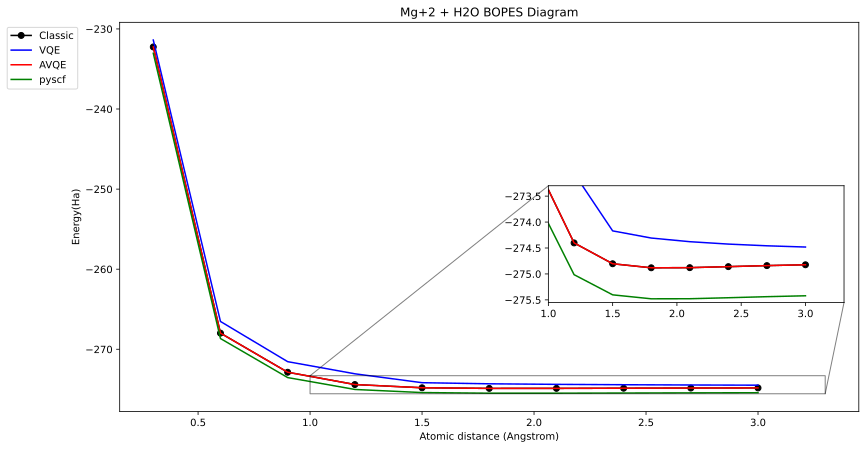

In [266]:
fig, ax=plt.subplots(1,1,figsize=(11,6))
fig.tight_layout()

ax.plot(dists,classic_energies, '-ko',label="Classic")
ax.plot(dists, vqe_energies, '-b',label="VQE")
ax.plot(dists, avqe_energies, '-r',label="AVQE")
ax.plot(dists, pyscf_energies, '-g',label="pyscf")


ax.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram')
ax.legend(bbox_to_anchor=(-.05,1))


axins2 = ax.inset_axes([0.58, 0.28, 0.4, 0.3])
axins2.plot(dists,classic_energies, '-ko',label="Classic")
axins2.plot(dists, vqe_energies, '-b',label="VQE")
axins2.plot(dists, avqe_energies, '-r',label="AVQE")
axins2.plot(dists, pyscf_energies, '-g',label="pyscf")

xx1, xx2, yy1, yy2 = 1.0,3.3, -275.55, -273.3
axins2.set_xlim(xx1, xx2)
axins2.set_ylim(yy1, yy2)

ax.indicate_inset_zoom(axins2, edgecolor="black")

plt.subplots_adjust(wspace=0.17)
plt.show()

## Zn+2 + H2O

First we do a single calculation for a given separations distance d.

### Step 1: Build Qubit Operator.

In [116]:
#Define Molecule
d=1.5
molecule = MoleculeInfo(
             # coordinates in Angstrom
                     symbols=['O','H','H','Zn'],
                     coords=[
                            # (d+0.504284,0.0,0.758602),
                            # (d,0.0,0.0),
                            # (d+2*0.504284,0.0,0.0),
                            # (0.0, 0.0, 0.0),
                            (0.0,0.0,0.0),
                            (-0.504284,0.0,-0.758602),
                            (0.504284,0.0,-0.758602),
                            (0.0, 0.0, d),
                            ],
                     multiplicity=1,  # = 2*spin + 1
                     charge=2,
                     units=DistanceUnit.ANGSTROM
                    )

#Set driver
driver = PySCFDriver.from_molecule(molecule, basis="6-31g*", method=MethodType.RKS)
driver.xc_functional='b3lyp'

#Get properties of origianl problem
og_problem = driver.run()
    
#particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
#num_a_electrons = problem.num_alpha
#num_b_electrons = propblem.num_beta
og_num_particles=og_problem.num_particles

og_num_spatial_orbitals =og_problem.num_spatial_orbitals

og_rep_energy = og_problem.nuclear_repulsion_energy
    
# Check the occupation of the spin orbitals
og_PN_property = og_problem.properties.particle_number
mol = gto.Mole()
mol.atom = [
        # ['O',(d+0.504284,0.0,0.758602)],
        # ['H',(d,0.0,0.0),],
        # ['H',(d+2*0.504284,0.0,0.0)],
        # ['Mg',(0.0, 0.0, 0.0)]
        ['O',(0.0,0.0,0)],
        ['H',(-0.504284,0.0,-0.758602),],
        ['H',(0.504284,0.0,-0.758602)],
        ['Zn',(0.0, 0.0, d)]
        ]
mol.charge=2
mol.basis = '6-31g*'
mol.spin = 0
mol.build()

mf = scf.RKS(mol).x2c()
mf.kernel()

ao_labels = ['Zn 3d', 'O 2p']#,'H 1s']
avas_obj = avas.AVAS(mf, ao_labels)
avas_obj.kernel()
weights=np.append(avas_obj.occ_weights,avas_obj.vir_weights)
weights=(weights>0.1)*weights
orbs=np.nonzero(weights)


#Define the active space
#(selected automatically around the HOMO and LUMO, ordered by energy)
transformer = ActiveSpaceTransformer(
            num_electrons=(int(avas_obj.nelecas/2),int(avas_obj.nelecas/2)), #Electrons in active space
            num_spatial_orbitals=avas_obj.ncas+1, #Orbitals in active space
            active_orbitals=orbs[0].tolist().append(orbs[0][-1]+1)
        )

### Uncomment below for manual selection

# transformer = ActiveSpaceTransformer(
#             num_electrons=(3,3), #Electrons in active space
#             num_spatial_orbitals=4, #Orbitals in active space
#             #active_orbitals=orbs[0].tolist().append(orbs[0][-1]+1)
#         )

fz_transformer=FreezeCoreTransformer(freeze_core=True) # Freeze core transformer in case we want to freeze core electrons
    
#Define the problem

problem=transformer.transform(og_problem)

fz_problem=fz_transformer.transform(og_problem)

#Get Hamiltonian form driver

#og_hamiltonian=og_problem.hamiltonian
#og_second_q_op = og_hamiltonian.second_q_op()
hamiltonian=problem.hamiltonian
second_q_op = hamiltonian.second_q_op()
#fz_hamiltonian=fz_problem.hamiltonian
#fz_second_q_op = fz_hamiltonian.second_q_op() 

#og_num_spatial_orbitals = og_problem.num_spatial_orbitals
#og_num_particles = og_problem.num_particles

#Get Properties of transformed problem
    
num_spatial_orbitals = problem.num_spatial_orbitals
num_particles = problem.num_particles

#fz_num_spatial_orbitals = fz_problem.num_spatial_orbitals
#fz_num_particles = fz_problem.num_particles
    
mapper=ParityMapper()

#Get Pauli OP

converter = QubitConverter(mapper,two_qubit_reduction=True, z2symmetry_reduction='auto') # Using two qubit reduction and z2. symmetries to taper off qubits.
simple_converter = QubitConverter(mapper)
    
#Final OP
#og_qubit_op = converter.convert(og_second_q_op,num_particles=og_num_particles,sector_locator=og_problem.symmetry_sector_locator)
qubit_op = converter.convert(second_q_op,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
#fz_qubit_op = converter.convert(fz_second_q_op)

converged SCF energy = -1864.27141987367


Now we can check how many qubits are required for the given Active Space. Note on the code we opted for an automated method for active space selection available on PySCF, this can be done manually as well.

In [91]:
qubit_op.num_qubits

14

### Step2: VQE

With the operator constructed we do the VQE calculation:

In [89]:
#Construct the initial state for the VQE algorithm:
init_state = HartreeFock(problem.num_spatial_orbitals,problem.num_particles, converter)

#Build the ansatz based on problem properties

#ansatz = UCCSD(num_spatial_orbitals=problem.num_spatial_orbitals,num_particles=problem.num_particles,qubit_converter=converter,initial_state=init_state) # Uncomment for UCCSD ansatz

#ansatz = EfficientSU2(num_qubits=qubit_op.num_qubits,su2_gates=['ry'], entanglement='linear', reps=3, initial_state=init_state) # Uncomment for Heuristic Ansatz

#####Qubit-ADAPT-VQE ansatz

ansatz = UCCSD(num_spatial_orbitals=problem.num_spatial_orbitals,num_particles=problem.num_particles,qubit_converter=converter,initial_state=init_state)

operator_pool = []
for op in ansatz.operators:
    sop = op.primitive
    for pauli, coeff in zip(sop.paulis, sop.coeffs):
        if sum(pauli.x & pauli.z) % 2 == 0:
            continue
    operator_pool.append(PauliSumOp(coeff * SparsePauliOp(pauli)))

ansatz = EvolvedOperatorAnsatz(
        operators=operator_pool,
        initial_state=init_state,
        )

        
# Set initial parameters of the ansatz (we set zeros as we set the initial stae into the ansatz.)
initial_point=np.zeros(ansatz.num_parameters)

##Choose ooptimizer

optimizer = SLSQP(maxiter=150)
#optimizer = SPSA(maxiter=150)

#Seed for required RNG

seed = 62
algorithm_globals.random_seed = seed

##Noise model in case we want to do noisy simulations

from qiskit.providers.fake_provider import FakeManila, FakeNairobi, FakeMontreal, FakeGuadalupe

device_backend=FakeGuadalupe()
device = AerSimulator.from_backend(device_backend)
noise_model = None
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

### Qiskit Runtime options in case we want to run anything on the cloud

ts_opt=TranspilationOptions(
    skip_transpilation=True
)

sim_opt=SimulatorOptions(
    noise_model=noise_model,
    seed_simulator=62,
    coupling_map=coupling_map,
    basis_gates=basis_gates
)
res_opt=ResilienceOptions(
    noise_factors=tuple(range(1, 6, 2)),
    noise_amplifier='LocalFoldingAmplifier',
    extrapolator='LinearExtrapolator'
)

ex_opt=ExecutionOptions(
    shots=1024
)
est_options=Options(
    #resilience_level=2,
    #optimization_level=3,
    execution=ex_opt,
    #resilience=res_opt,
    #simulator=sim_opt,
    #transpilation=ts_opt
)

#Local simulator options for local simulations

bck_opt={'method':'statevector',
         'device':'CPU',
         'precision':'double',
         'extended_stabilizer_sampling_method':'resampled_metropolis'
                }
run_opt={'shots':32,
                }

#estimator = AerEstimator([ansatz], [qubit_op],backend_options=bck_opt,run_options=run_opt) #AerSimulator, worse performnace
estimator= Estimator([ansatz],[qubit_op]) # Base terra simulator, better performnace

#####
#SETUP AND RUN VQE LOCALLY
#####
    
counts = []
values = []
params= []
deviation = []
    
vqe = VQE(estimator, ansatz, optimizer,initial_point=initial_point, callback=callback)

#### If Running ADAPT-VQE
adapt_vqe=AdaptVQE(vqe)
adapt_vqe.supports_aux_operators = lambda: False ## If set to True will measure Angular Momentum, Magnetization, Particle Number and ZDipole as well.
adapt_vqe.threshold=1e-3
adapt_vqe.max_iterations=4
adapt_vqe.delta=1e-4
#####
        
solver = GroundStateEigensolver(converter, adapt_vqe)
result = solver.solve(problem)

#result = vqe.compute_minimum_eigenvalue(qubit_op) # in case you don't want the intrepreted result.

#####
#SETUP AND RUN VQE WITH RUNTIME
#####

# with Session(service=service, backend='ibmq_qasm_simulator') as session:
#     # Prepare primitive
#     rt_estimator = RuntimeEstimator(session=session)#,options=est_options)
#     # Set up algorithm
#     custom_vqe = VQE(rt_estimator, ansatz, optimizer,initial_point=initial_point, callback=callback)
#     adapt_vqe=AdaptVQE(custom_vqe)
#     adapt_vqe.supports_aux_operators = lambda: False
#     adapt_vqe.threshold=1e-3
#     adapt_vqe.max_iterations=4
#     adapt_vqe.delta=1e-4
#     # Run algorithm
#     solver = GroundStateEigensolver(converter, custom_vqe)
#     result = solver.solve(problem)

#     #result = adapt_vqe.compute_minimum_eigenvalue(qubit_op)

KeyboardInterrupt: 

After this we can print the interpreted result:

In [ ]:
print(result)

 Or get the raw_result:

In [55]:
print(result.raw_result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 16,
    'eigenvalue': -15.68756979278509,
    'final_max_gradient': -0.0029904933765982447,
    'num_iterations': 4,
    'optimal_circuit': <qiskit.circuit.library.evolved_operator_ansatz.EvolvedOperatorAnsatz object at 0x2874fddc0>,
    'optimal_parameters': {   ParameterVectorElement(t[0]): 0.1208584561094227,
                              ParameterVectorElement(t[1]): 0.11752923145808884,
                              ParameterVectorElement(t[3]): -0.019012394224115173,
                              ParameterVectorElement(t[2]): -0.050179405948350714},
    'optimal_point': array([ 0.12085846,  0.11752923, -0.05017941, -0.01901239]),
    'optimal_value': -15.68756979278509,
    'optimizer_evals': None,
    'optimizer_result': <qiskit.algorithms.optimizers.optimizer.OptimizerResult object at 0x28f754c10>,
    'optimizer_time': 0.1738271713256836,
    'termination_criterion': <TerminationCriterion.MAXIMUM: 'Maximum number 

Just for compariosn we can take a look at the different ansatzes in the form they would be read by a quantum computer

Full circuit ADAPT-VQE:

In [56]:
provider = IBMQ.get_provider(group='deployed')
backend=provider.get_backend('ibmq_guadalupe')

transpile(ansatz,backend=backend,optimization_level=3).count_ops()

OrderedDict([('rz', 24), ('cx', 23), ('sx', 14), ('x', 2)])

In [57]:
transpile(ansatz,backend=backend,optimization_level=3).depth()

37

Heuristic RYRZ ansatz:

In [58]:
og_ansatz=EfficientSU2(num_qubits=10,su2_gates=['ry'], entanglement='linear', reps=3)#, initial_state=init_state)
transpile(og_ansatz,backend=backend,optimization_level=3).count_ops()

OrderedDict([('sx', 80), ('rz', 80), ('cx', 27)])

In [59]:
transpile(og_ansatz,backend=backend).depth()

29

Biggest ansatz in last ADAPT-VQE run:

In [60]:
transpile(result.raw_result.optimal_circuit,backend=backend,optimization_level=3).count_ops()


OrderedDict([('rz', 24), ('cx', 21), ('sx', 14), ('x', 1)])

In [61]:
transpile(result.raw_result.optimal_circuit,backend=backend,optimization_level=3).depth()


33

### Step 3: VQE for diffrente distances

We build a function that creates the Electronic Structrucre Problems and qubit operators for a given distance.

In [123]:
def make_driver(d):
    
    
    molecule = MoleculeInfo(
             # coordinates in Angstrom
                     symbols=['O','H','H','Zn'],
                     coords=[
                            # (d+0.504284,0.0,0.758602),
                            # (d,0.0,0.0),
                            # (d+2*0.504284,0.0,0.0),
                            # (0.0, 0.0, 0.0),
                            (0.0,0.0,0.0),
                            (-0.504284,0.0,-0.758602),
                            (0.504284,0.0,-0.758602),
                            (0.0, 0.0, d),
                            ],
                     multiplicity=1,  # = 2*spin + 1
                     charge=2,
                     units=DistanceUnit.ANGSTROM
                    )
    
    #Set driver
    #driver = PySCFDriver.from_molecule(molecule, basis="sto3g", method=MethodType.ROHF)
    #driver.xc_functional='pbe,pbe'
    driver = PySCFDriver.from_molecule(molecule, basis="6-31g*", method=MethodType.ROKS)
    driver.xc_functional='b3lyp'
    driver.conv_tol = 1e-6

    #Get properties
    problem = driver.run()
    

    return driver, problem

def make_qubit_op(d,og_problem, mapper,freeze_core):
    mol = gto.Mole()
    mol.atom = [
        # ['O',(d+0.504284,0.0,0.758602)],
        # ['H',(d,0.0,0.0),],
        # ['H',(d+2*0.504284,0.0,0.0)],
        # ['Mg',(0.0, 0.0, 0.0)]
        ['O',(0.0,0.0,0)],
        ['H',(-0.504284,0.0,-0.758602),],
        ['H',(0.504284,0.0,-0.758602)],
        ['Zn',(0.0, 0.0, d)]
        ]
    mol.charge=2
    mol.basis = '6-31g*'
    mol.spin = 0
    mol.build()
    
    #mf= scf.ROHF(mol).x2c()
    mf = dft.ROKS(mol).density_fit(auxbasis='def2-universal-jfit')
    mf.xc ='pbe,pbe'
    mf.max_cycle = 50
    mf.conv_tol = 1e-6
    
    first_run=mf.kernel()
    a = mf.stability()[0]
    if(mf.converged):
        energy=first_run
    else:
        mf.max_cycle = 80
        mf.conv_tol = 1e-6
        mf = scf.newton(mf)
        scnd_run=mf.kernel(dm0 = mf.make_rdm1(a,mf.mo_occ)) # using rdm1 constructed from stability analysis
      #mf.kernel(mf.make_rdm1()) #using the rdm from the non-converged calculation
        if(mf.converged):
            energy=scnd_run
        else:
            mf.conv_tol = 1e-6
            mf.max_cycle = 80
            mf = scf.newton(mf) #Second order solver
            energy=mf.kernel(dm0 = mf.make_rdm1())


    ao_labels = ['Zn 3d', 'O 2p']
    avas_obj = avas.AVAS(mf, ao_labels)
    avas_obj.kernel()
    weights=np.append(avas_obj.occ_weights,avas_obj.vir_weights)
    weights=(weights>0.2)*weights
    orbs=np.nonzero(weights)
    orbs=np.nonzero(weights)
    
    # transformer = ActiveSpaceTransformer(
    #         num_electrons=(int(avas_obj.nelecas/2),int(avas_obj.nelecas/2)), #Electrons in active space
    #         num_spatial_orbitals=avas_obj.ncas+1, #Orbitals in active space
    #         active_orbitals=orbs[0].tolist().append(orbs[0][-1]+1)
    #     )
    transformer = ActiveSpaceTransformer(
            num_electrons=(6,6), #Electrons in active space
            num_spatial_orbitals=7, #Orbitals in active space
            #active_orbitals=orbs[0].tolist().append(orbs[0][-1]+1)
        )
    fz_transformer=FreezeCoreTransformer(freeze_core=freeze_core)
    
    #Define the problem

    problem=transformer.transform(og_problem)
    if freeze_core==True:
        problem=fz_transformer.transform(problem)
        converter = QubitConverter(mapper)
    else:
        converter = QubitConverter(mapper,two_qubit_reduction=True, z2symmetry_reduction='auto')

    hamiltonian=problem.hamiltonian
    second_q_op = hamiltonian.second_q_op()
    
    num_spatial_orbitals = problem.num_spatial_orbitals
    num_particles = problem.num_particles
    
    qubit_op = converter.convert(second_q_op,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
    
        

    
    return qubit_op, problem,  converter, energy
    

Noise_model options for noisy simulations

In [124]:
from qiskit.providers.fake_provider import FakeManila, FakeNairobi, FakeMontreal, FakeGuadalupe

#Noisy simulator
backend_aer = AerSimulator(method='density_matrix',device='CPU')
device_backend=FakeGuadalupe()
device = AerSimulator.from_backend(device_backend)
noise_model = None
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

sim_opt=SimulatorOptions(
    noise_model=noise_model,
    seed_simulator=62,
    coupling_map=coupling_map,
    basis_gates=basis_gates
)

Qiskit Runtime Options

In [125]:
#Runtime Estimator options
ts_opt=TranspilationOptions(
    skip_transpilation=True
)

sim_opt=SimulatorOptions(
    noise_model=noise_model,
    seed_simulator=62,
    coupling_map=coupling_map,
    basis_gates=basis_gates
)
res_opt=ResilienceOptions(
    noise_factors=tuple(range(1, 6, 2)),
    noise_amplifier='LocalFoldingAmplifier',
    extrapolator='LinearExtrapolator'
)

ex_opt=ExecutionOptions(
    shots=1024
)
est_options=Options(
    resilience_level=2,
    #optimization_level=3,
    execution=ex_opt,
    resilience=res_opt,
    #simulator=sim_opt,
    #transpilation=ts_opt
)

Calculation options

In [126]:
distances = np.arange(0.3, 3.6, 0.3)
optimizer = SLSQP(maxiter=100)
#optimizer = SPSA(maxiter=100)
mapper=ParityMapper()


seed = 62
algorithm_globals.random_seed = seed

Calculations:

In [127]:
#Local Calculations

counts = []
values = []
params = []
meta_dicts=[]


ryrz_results,ryrz_problems,dists,pyscf_energies=local_RYRZ_solver(                                               distances=distances,
                                                                          mapper=mapper,
                                                                          optimizer=optimizer,freeze_core=False)

'Evaluation: 3408, Energy: -45.29862232554407, Mean: -50.683511723578334, STD: 8.188899733922693, Metadata: {}'

In [ ]:
counts = []
values = []
params = []
meta_dicts=[]


uccsd_results,vqe_problems,dists,pyscf_energies=local_UCCSD_solver(                                               distances=distances,
                                                                          mapper=mapper,
                                                                          optimizer=optimizer,freeze_core=False)

'Evaluation: 984, Energy: -45.35563404640823, Mean: -49.40714959148016, STD: 6.751799381862474, Metadata: {}'

In [ ]:
#Local calculations-ADAPT VQE

counts = []
values = []
params = []
meta_dicts=[]


avqe_results,avqe_problems,dists,pyscf_energies=adapt_solver(distances=distances,
                                                                          mapper=mapper,
                                                                          optimizer=optimizer,freeze_core=False)

'Evaluation: 90, Energy: -45.14395432921952, Mean: -53.201520617615856, STD: 8.210336249769842, Metadata: {}'

We can calculate the groundstate with numpy as well. This will serve as a benchmark for the VQE.

In [ ]:
classic_results,dists=classic_solver(distances=distances,
                             mapper=mapper,
                             optimizer=optimizer,
                             freeze_core=False
                            )

converged SCF energy = -1773.49377669689
<class 'pyscf.df.df_jk.density_fit.<locals>.DensityFitting'> wavefunction is stable in the internal stability analysis
converged SCF energy = -1843.21424117046
<class 'pyscf.df.df_jk.density_fit.<locals>.DensityFitting'> wavefunction is stable in the internal stability analysis
converged SCF energy = -1851.82663161982
<class 'pyscf.df.df_jk.density_fit.<locals>.DensityFitting'> wavefunction is stable in the internal stability analysis
converged SCF energy = -1853.73190819404
<class 'pyscf.df.df_jk.density_fit.<locals>.DensityFitting'> wavefunction is stable in the internal stability analysis
converged SCF energy = -1854.14672146153
<class 'pyscf.df.df_jk.density_fit.<locals>.DensityFitting'> wavefunction is stable in the internal stability analysis
converged SCF energy = -1854.20978969304
<class 'pyscf.df.df_jk.density_fit.<locals>.DensityFitting'> wavefunction is stable in the internal stability analysis
converged SCF energy = -1854.19498119603

We can save results and retrieve later:

In [ ]:
write_list(avqe_problems,'Zn+H2O/simulations/avqe_problems')

Done writing list into a binary file


In [ ]:
write_list(ryrz_results,'Zn+H2O/simulations/ryrz_results')
write_list(uccsd_results,'Zn+H2O/simulations/uccsd_results')
write_list(avqe_results,'Zn+H2O/simulations/avqe_results')
write_list(classic_results,'Zn+H2O/simulations/classic_results')
write_list(pyscf_energies,'Zn+H2O/simulations/pyscf_energies')

Done writing list into a binary file
Done writing list into a binary file
Done writing list into a binary file
Done writing list into a binary file
Done writing list into a binary file


In [392]:
write_list(avqe_results,'test.py')

Done writing list into a binary file


In [394]:
test=read('test.py')

In [398]:
print(test[0].raw_result)

{   'aux_operators_evaluated': {   'AngularMomentum': (   0.012936874673912427,
                                                          {}),
                                   'Magnetization': (   1.3710462538063517e-06,
                                                        {}),
                                   'ParticleNumber': (11.999986572090553, {}),
                                   'ZDipole': (0.006907172430952263, {})},
    'cost_function_evals': 57,
    'eigenvalue': -82.43954654007587,
    'final_max_gradient': 0.025266721474452192,
    'num_iterations': 4,
    'optimal_circuit': <qiskit.circuit.library.evolved_operator_ansatz.EvolvedOperatorAnsatz object at 0x16bdc3280>,
    'optimal_parameters': {   ParameterVectorElement(t[1]): 0.007998787200850576,
                              ParameterVectorElement(t[2]): -3.368037726890511,
                              ParameterVectorElement(t[3]): 0.45500850220927225,
                              ParameterVectorElement(t[0]): 

We can calculate the groundstate with numpy as well. This will serve as a benchmark for the VQE.

In [ ]:
classic_results,dists=classic_solver(distances=distances,
                             mapper=mapper,
                             optimizer=optimizer,
                             freeze_core=False
                            )

Extract the energy values from the results and plot them:

In [184]:
avqe_energies=[]
#vqe_energies=[]
classic_energies=[]
for i in range(len(dists)):
            avqe_energies.append(avqe_results[i].total_energies)
            #vqe_energies.append(vqe_problems[i].interpret(vqe_results[i]).total_energies)
            classic_energies.append(classic_results[i].total_energies)

NameError: name 'classic_results' is not defined

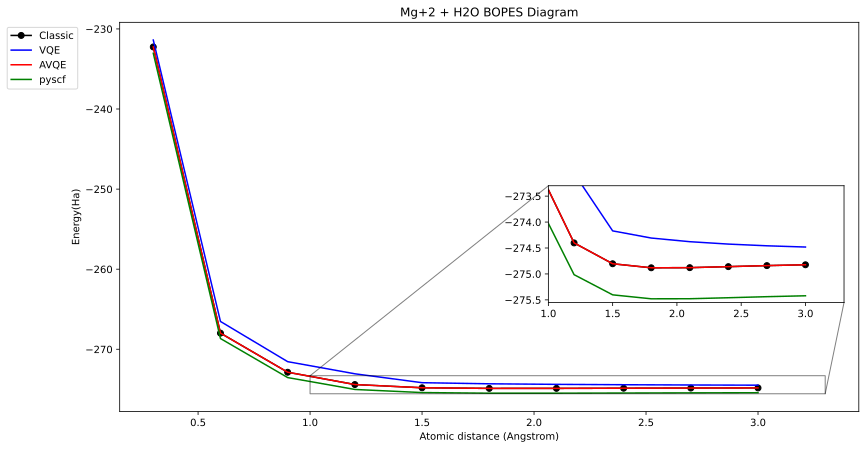

In [266]:
fig, ax=plt.subplots(1,1,figsize=(11,6))
fig.tight_layout()

ax.plot(dists,classic_energies, '-ko',label="Classic")
ax.plot(dists, vqe_energies, '-b',label="VQE")
ax.plot(dists, avqe_energies, '-r',label="AVQE")
ax.plot(dists, pyscf_energies, '-g',label="pyscf")


ax.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram')
ax.legend(bbox_to_anchor=(-.05,1))


axins2 = ax.inset_axes([0.58, 0.28, 0.4, 0.3])
axins2.plot(dists,classic_energies, '-ko',label="Classic")
axins2.plot(dists, vqe_energies, '-b',label="VQE")
axins2.plot(dists, avqe_energies, '-r',label="AVQE")
axins2.plot(dists, pyscf_energies, '-g',label="pyscf")

xx1, xx2, yy1, yy2 = 1.0,3.3, -275.55, -273.3
axins2.set_xlim(xx1, xx2)
axins2.set_ylim(yy1, yy2)

ax.indicate_inset_zoom(axins2, edgecolor="black")

plt.subplots_adjust(wspace=0.17)
plt.show()

In [38]:
write_list(vqe_energies,'VQE_MG+H2O_2')

Done writing list into a binary file


In [58]:
write_list(pyscf_energies,'PySCF_MG+H2O')

Done writing list into a binary file


In [ ]:
print(problems[0].interpret(results[0]))

In [ ]:
#Runtime Estimator options
ts_opt=TranspilationOptions(
    skip_transpilation=True
)

sim_opt=SimulatorOptions(
    noise_model=noise_model,
    seed_simulator=62,
    coupling_map=coupling_map,
    basis_gates=basis_gates
)
res_opt=ResilienceOptions(
    noise_factors=tuple(range(1, 6, 2)),
    noise_amplifier='LocalFoldingAmplifier',
    extrapolator='LinearExtrapolator'
)

ex_opt=ExecutionOptions(
    shots=1024
)
est_options=Options(
    #resilience_level=2,
    #optimization_level=3,
    execution=ex_opt,
    #resilience=res_opt,
    #simulator=sim_opt,
    #transpilation=ts_opt
)

results,problems,dists=sim_solver(distances=distances,
                             mapper=mapper,
                             optimizer=optimizer,
                             freeze_core=False,
                             est_options=est_options,
                             mapomatic=False,
                             device='ibmq_kolkata'    
)

In [ ]:
counts = []
values = []
params = []
meta_dicts=[]


real_results,real_problems,dists=real_solver(distances=distances,
                                            mapper=mapper,
                                            optimizer=optimizer,
                                            freeze_core=False,
                                            est_options=est_options,
                                            device='ibmq_montreal'
                                          )

In [405]:
write_list(vqe_results,f'../VQE_problems/MG+H2O_guad_vqe_results_ {distances[0]}')

Done writing list into a binary file


In [402]:
distances

array([0.3, 0.7, 1.1, 1.5, 1.9, 2.3, 2.7, 3.1])

## Zn+2 + N2

### Step 1: Build Qubit Operator.

In [ ]:
#Define Molecule
d=1.5
molecule = MoleculeInfo(
             # coordinates in Angstrom
                     symbols=['N','N','Zn'],
                     coords=[
                            (0.0,0.0,0.0),
                            (1.0977,0.0,0),
                            (d+1.0977, 0.0,0.0),
                            ],
                     multiplicity=1,  # = 2*spin + 1
                     charge=2,
                     units=DistanceUnit.ANGSTROM
                    )

#Set driver
driver = PySCFDriver.from_molecule(molecule, basis="6-31g*", method=MethodType.RKS)
driver.xc_functional='b3lyp'

#Get properties of origianl problem
og_problem = driver.run()
    
#particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
#num_a_electrons = problem.num_alpha
#num_b_electrons = propblem.num_beta
og_num_particles=og_problem.num_particles

og_num_spatial_orbitals =og_problem.num_spatial_orbitals

og_rep_energy = og_problem.nuclear_repulsion_energy
    
# Check the occupation of the spin orbitals
og_PN_property = og_problem.properties.particle_number
mol = gto.Mole()
mol.atom = [
        ['N',(0.0,0.0,0)],
        ['N',(1.0977,0.0,0.0),],
        ['Zn',(d+1.0977, 0.0, 0.0)]
        ]
mol.charge=2
mol.basis = '6-31g*'
mol.spin = 0
mol.build()

mf = scf.RKS(mol).x2c()
mf.kernel()

ao_labels = ['Zn 2p', 'N 2p']#,'H 1s']
avas_obj = avas.AVAS(mf, ao_labels)
avas_obj.kernel()
weights=np.append(avas_obj.occ_weights,avas_obj.vir_weights)
weights=(weights>0.1)*weights
orbs=np.nonzero(weights)


# Define the active space
# (selected automatically around the HOMO and LUMO, ordered by energy)
transformer = ActiveSpaceTransformer(
            num_electrons=(int(avas_obj.nelecas/2),int(avas_obj.nelecas/2)), #Electrons in active space
            num_spatial_orbitals=avas_obj.ncas+1, #Orbitals in active space
            active_orbitals=orbs[0].tolist().append(orbs[0][-1]+1)
        )

### Uncomment below for manual selection

# transformer = ActiveSpaceTransformer(
#             num_electrons=(3,3), #Electrons in active space
#             num_spatial_orbitals=4, #Orbitals in active space
#             #active_orbitals=orbs[0].tolist().append(orbs[0][-1]+1)
#         )

fz_transformer=FreezeCoreTransformer(freeze_core=True) # Freeze core transformer in case we want to freeze core electrons
    
#Define the problem

problem=transformer.transform(og_problem)

fz_problem=fz_transformer.transform(og_problem)

#Get Hamiltonian form driver

#og_hamiltonian=og_problem.hamiltonian
#og_second_q_op = og_hamiltonian.second_q_op()
hamiltonian=problem.hamiltonian
second_q_op = hamiltonian.second_q_op()
fz_hamiltonian=fz_problem.hamiltonian
fz_second_q_op = fz_hamiltonian.second_q_op() 

#og_num_spatial_orbitals = og_problem.num_spatial_orbitals
#og_num_particles = og_problem.num_particles

#Get Properties of transformed problem
    
num_spatial_orbitals = problem.num_spatial_orbitals
num_particles = problem.num_particles

fz_num_spatial_orbitals = fz_problem.num_spatial_orbitals
fz_num_particles = fz_problem.num_particles
    
mapper=ParityMapper()

#Get Pauli OP

converter = QubitConverter(mapper,two_qubit_reduction=True, z2symmetry_reduction='auto') # Using two qubit reduction and z2. symmetries to taper off qubits.
simple_converter = QubitConverter(mapper)
    
#Final OP
#og_qubit_op = converter.convert(og_second_q_op,num_particles=og_num_particles,sector_locator=og_problem.symmetry_sector_locator)
qubit_op = converter.convert(second_q_op,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
#fz_qubit_op = converter.convert(fz_second_q_op)

Now we can check how many qubits are required for the given Active Space. Note on the code we opted for an automated method for active space selection available on PySCF, this can be done manually as well.

In [83]:
qubit_op.num_qubits

10

### Step2: VQE

With the operator constructed we do the VQE calculation:

In [154]:
#Construct the initial state for the VQE algorithm:
init_state = HartreeFock(problem.num_spatial_orbitals,problem.num_particles, converter)

#Build the ansatz based on problem properties

#ansatz = UCCSD(num_spatial_orbitals=problem.num_spatial_orbitals,num_particles=problem.num_particles,qubit_converter=converter,initial_state=init_state) # Uncomment for UCCSD ansatz

#ansatz = EfficientSU2(num_qubits=qubit_op.num_qubits,su2_gates=['ry'], entanglement='linear', reps=3, initial_state=init_state) # Uncomment for Heuristic Ansatz

#####Qubit-ADAPT-VQE ansatz

ansatz = UCCSD(num_spatial_orbitals=problem.num_spatial_orbitals,num_particles=problem.num_particles,qubit_converter=converter,initial_state=init_state)

operator_pool = []
for op in ansatz.operators:
    sop = op.primitive
    for pauli, coeff in zip(sop.paulis, sop.coeffs):
        if sum(pauli.x & pauli.z) % 2 == 0:
            continue
    operator_pool.append(PauliSumOp(coeff * SparsePauliOp(pauli)))

ansatz = EvolvedOperatorAnsatz(
        operators=operator_pool,
        initial_state=init_state,
        )

        
# Set initial parameters of the ansatz (we set zeros as we set the initial stae into the ansatz.)
initial_point=np.zeros(ansatz.num_parameters)

##Choose ooptimizer

#optimizer = SLSQP(maxiter=150)
optimizer = SPSA(maxiter=150)

#Seed for required RNG

seed = 62
algorithm_globals.random_seed = seed

##Noise model in case we want to do noisy simulations

from qiskit.providers.fake_provider import FakeManila, FakeNairobi, FakeMontreal, FakeGuadalupe

device_backend=FakeGuadalupe()
device = AerSimulator.from_backend(device_backend)
noise_model = None
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

### Qiskit Runtime options in case we want to run anything on the cloud

ts_opt=TranspilationOptions(
    skip_transpilation=True
)

sim_opt=SimulatorOptions(
    noise_model=noise_model,
    seed_simulator=62,
    coupling_map=coupling_map,
    basis_gates=basis_gates
)
res_opt=ResilienceOptions(
    noise_factors=tuple(range(1, 6, 2)),
    noise_amplifier='LocalFoldingAmplifier',
    extrapolator='LinearExtrapolator'
)

ex_opt=ExecutionOptions(
    shots=1024
)
est_options=Options(
    #resilience_level=2,
    #optimization_level=3,
    execution=ex_opt,
    #resilience=res_opt,
    #simulator=sim_opt,
    #transpilation=ts_opt
)

#Local simulator options for local simulations

bck_opt={'method':'statevector',
         'device':'CPU',
         'precision':'double',
         'extended_stabilizer_sampling_method':'resampled_metropolis'
                }
run_opt={'shots':32,
                }

#estimator = AerEstimator([ansatz], [qubit_op],backend_options=bck_opt,run_options=run_opt) #AerSimulator, worse performnace
estimator= Estimator([ansatz],[qubit_op]) # Base terra simulator, better performnace

#####
#SETUP AND RUN VQE LOCALLY
#####
    
counts = []
values = []
params= []
deviation = []
    
vqe = VQE(estimator, ansatz, optimizer,initial_point=initial_point, callback=callback)

#### If Running ADAPT-VQE
adapt_vqe=AdaptVQE(vqe)
adapt_vqe.supports_aux_operators = lambda: False ## If set to True will measure Angular Momentum, Magnetization, Particle Number and ZDipole as well.
adapt_vqe.threshold=1e-3
adapt_vqe.max_iterations=4
adapt_vqe.delta=1e-4
#####
        
solver = GroundStateEigensolver(converter, adapt_vqe)
result = solver.solve(problem)

#result = vqe.compute_minimum_eigenvalue(qubit_op) # in case you don't want the intrepreted result.

#####
#SETUP AND RUN VQE WITH RUNTIME
#####

# with Session(service=service, backend='ibmq_qasm_simulator') as session:
#     # Prepare primitive
#     rt_estimator = RuntimeEstimator(session=session)#,options=est_options)
#     # Set up algorithm
#     custom_vqe = VQE(rt_estimator, ansatz, optimizer,initial_point=initial_point, callback=callback)
#     adapt_vqe=AdaptVQE(custom_vqe)
#     adapt_vqe.supports_aux_operators = lambda: False
#     adapt_vqe.threshold=1e-3
#     adapt_vqe.max_iterations=4
#     adapt_vqe.delta=1e-4
#     # Run algorithm
#     solver = GroundStateEigensolver(converter, custom_vqe)
#     result = solver.solve(problem)

#     #result = adapt_vqe.compute_minimum_eigenvalue(qubit_op)

'Evaluation: 351, Energy: -58.700582408338406, Mean: -59.20120424364559, STD: 1.018117517799415, Metadata: {}'

After this we can print the interpreted result:

In [162]:
print(result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -322.885981754909
  - computed part:      -58.700582408338
  - ActiveSpaceTransformer extracted energy part: -264.18539934657
~ Nuclear repulsion energy (Hartree): 49.174752294501
> Total ground state energy (Hartree): -273.711229460408
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  31.14797021]
 


 Or get the raw_result:

In [165]:
print(result.raw_result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 300,
    'eigenvalue': -58.700582408338406,
    'final_max_gradient': 0.005921072611016503,
    'num_iterations': 4,
    'optimal_circuit': <qiskit.circuit.library.evolved_operator_ansatz.EvolvedOperatorAnsatz object at 0x286aff610>,
    'optimal_parameters': {   ParameterVectorElement(t[0]): -443.91112686641355,
                              ParameterVectorElement(t[2]): -620.5679018464364,
                              ParameterVectorElement(t[3]): -138.8879729074059,
                              ParameterVectorElement(t[1]): -49.366813521780706},
    'optimal_point': array([-443.91112687,  -49.36681352, -620.56790185, -138.88797291]),
    'optimal_value': -58.700582408338406,
    'optimizer_evals': None,
    'optimizer_result': <qiskit.algorithms.optimizers.optimizer.OptimizerResult object at 0x2ee1709d0>,
    'optimizer_time': 13.35978078842163,
    'termination_criterion': <TerminationCriterion.MAXIMUM: 'Maximum numb

Just for compariosn we can take a look at the different ansatzes in the form they would be read by a quantum computer

Full circuit ADAPT-VQE:

In [85]:
provider = IBMQ.get_provider(group='deployed')
backend=provider.get_backend('ibmq_guadalupe')

transpile(ansatz,backend=backend,optimization_level=3).count_ops()

OrderedDict([('cx', 263), ('rz', 223), ('sx', 154), ('x', 3)])

In [169]:
transpile(ansatz,backend=backend,optimization_level=3).depth()

313

Heuristic RYRZ ansatz:

In [166]:
og_ansatz=EfficientSU2(num_qubits=10,su2_gates=['ry'], entanglement='linear', reps=3)#, initial_state=init_state)
transpile(og_ansatz,backend=backend,optimization_level=3).count_ops()

OrderedDict([('sx', 80), ('rz', 80), ('cx', 27)])

In [170]:
transpile(og_ansatz,backend=backend).depth()

29

Biggest ansatz in last ADAPT-VQE run:

In [167]:
transpile(result.raw_result.optimal_circuit,backend=backend,optimization_level=3).count_ops()


OrderedDict([('rz', 28), ('sx', 15), ('cx', 10), ('x', 2)])

In [171]:
transpile(result.raw_result.optimal_circuit,backend=backend,optimization_level=3).depth()


16

### Step 3: VQE for diffrente distances

We build a function that creates the Electronic Structrucre Problems and qubit operators for a given distance.

In [ ]:
def make_driver(d):
    
    
    molecule = MoleculeInfo(
             # coordinates in Angstrom
                     symbols=['N','N','Zn'],
                     coords=[
                            (0.0,0.0,0.0),
                            (1.0977,0.0,0),
                            (d+1.0977, 0.0,0.0),
                            ],
                     multiplicity=1,  # = 2*spin + 1
                     charge=2,
                     units=DistanceUnit.ANGSTROM
                    )
    
    #Set driver
    #driver = PySCFDriver.from_molecule(molecule, basis="sto3g", method=MethodType.ROHF)
    #driver.xc_functional='pbe,pbe'
    driver = PySCFDriver.from_molecule(molecule, basis="6-31g*", method=MethodType.ROKS)
    driver.xc_functional='b3lyp'
    driver.conv_tol = 1e-6

    #Get properties
    problem = driver.run()
    

    return driver, problem

def make_qubit_op(d,og_problem, mapper,freeze_core):
    mol = gto.Mole()
    mol.atom = [
        ['N',(0.0,0.0,0)],
        ['N',(1.0977,0.0,0.0),],
        ['Zn',(d+1.0977, 0.0, 0.0)]
        ]
    mol.charge=2
    mol.basis = '6-31g*'
    mol.spin = 0
    mol.build()
    
    #mf= scf.ROHF(mol).x2c()
    mf = dft.ROKS(mol).density_fit(auxbasis='def2-universal-jfit')
    mf.xc ='pbe,pbe'
    mf.max_cycle = 50
    mf.conv_tol = 1e-6
    
    first_run=mf.kernel()
    a = mf.stability()[0]
    if(mf.converged):
        energy=first_run
    else:
        mf.max_cycle = 80
        mf.conv_tol = 1e-6
        mf = scf.newton(mf)
        scnd_run=mf.kernel(dm0 = mf.make_rdm1(a,mf.mo_occ)) # using rdm1 constructed from stability analysis
      #mf.kernel(mf.make_rdm1()) #using the rdm from the non-converged calculation
        if(mf.converged):
            energy=scnd_run
        else:
            mf.conv_tol = 1e-6
            mf.max_cycle = 80
            mf = scf.newton(mf) #Second order solver
            energy=mf.kernel(dm0 = mf.make_rdm1())


    ao_labels = ['Zn 3d', 'N 2p']
    avas_obj = avas.AVAS(mf, ao_labels)
    avas_obj.kernel()
    weights=np.append(avas_obj.occ_weights,avas_obj.vir_weights)
    weights=(weights>0.2)*weights
    orbs=np.nonzero(weights)
    orbs=np.nonzero(weights)
    
    # transformer = ActiveSpaceTransformer(
    #         num_electrons=(int(avas_obj.nelecas/2),int(avas_obj.nelecas/2)), #Electrons in active space
    #         num_spatial_orbitals=avas_obj.ncas+1, #Orbitals in active space
    #         active_orbitals=orbs[0].tolist().append(orbs[0][-1]+1)
    #     )
    transformer = ActiveSpaceTransformer(
            num_electrons=(6,6), #Electrons in active space
            num_spatial_orbitals=7, #Orbitals in active space
            #active_orbitals=orbs[0].tolist().append(orbs[0][-1]+1)
        )
    fz_transformer=FreezeCoreTransformer(freeze_core=freeze_core)
    
    #Define the problem

    problem=transformer.transform(og_problem)
    if freeze_core==True:
        problem=fz_transformer.transform(problem)
        converter = QubitConverter(mapper)
    else:
        converter = QubitConverter(mapper,two_qubit_reduction=True, z2symmetry_reduction='auto')

    hamiltonian=problem.hamiltonian
    second_q_op = hamiltonian.second_q_op()
    
    num_spatial_orbitals = problem.num_spatial_orbitals
    num_particles = problem.num_particles
    
    qubit_op = converter.convert(second_q_op,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
    
        

    
    return qubit_op, problem,  converter, energy
    

Noise_model options for noisy simulations

In [ ]:
from qiskit.providers.fake_provider import FakeManila, FakeNairobi, FakeMontreal, FakeGuadalupe

#Noisy simulator
backend_aer = AerSimulator(method='density_matrix',device='CPU')
device_backend=FakeGuadalupe()
device = AerSimulator.from_backend(device_backend)
noise_model = None
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

sim_opt=SimulatorOptions(
    noise_model=noise_model,
    seed_simulator=62,
    coupling_map=coupling_map,
    basis_gates=basis_gates
)

Qiskit Runtime Options

In [ ]:
#Runtime Estimator options
ts_opt=TranspilationOptions(
    skip_transpilation=True
)

sim_opt=SimulatorOptions(
    noise_model=noise_model,
    seed_simulator=62,
    coupling_map=coupling_map,
    basis_gates=basis_gates
)
res_opt=ResilienceOptions(
    noise_factors=tuple(range(1, 6, 2)),
    noise_amplifier='LocalFoldingAmplifier',
    extrapolator='LinearExtrapolator'
)

ex_opt=ExecutionOptions(
    shots=1024
)
est_options=Options(
    resilience_level=2,
    #optimization_level=3,
    execution=ex_opt,
    resilience=res_opt,
    #simulator=sim_opt,
    #transpilation=ts_opt
)

Calculation options

In [ ]:
distances = np.arange(0.3, 3.6, 0.3)
optimizer = SLSQP(maxiter=100)
#optimizer = SPSA(maxiter=100)
mapper=ParityMapper()


seed = 62
algorithm_globals.random_seed = seed

Calculations:

In [ ]:
#Local Calculations

counts = []
values = []
params = []
meta_dicts=[]


ryrz_results,ryrz_problems,dists,pyscf_energies=local_RYRZ_solver(                                               distances=distances,
                                                                          mapper=mapper,
                                                                          optimizer=optimizer,freeze_core=False)

'Evaluation: 5184, Energy: -37.90854552702569, Mean: -45.36358552743701, STD: 6.45102526286492, Metadata: {}'

In [ ]:
counts = []
values = []
params = []
meta_dicts=[]


uccsd_results,vqe_problems,dists,pyscf_energies=local_UCCSD_solver(                                               distances=distances,
                                                                          mapper=mapper,
                                                                          optimizer=optimizer,freeze_core=False)

'Evaluation: 225, Energy: -37.90891421272142, Mean: -44.91901724309451, STD: 5.5369995365409785, Metadata: {}'

In [ ]:
#Local calculations-ADAPT VQE

counts = []
values = []
params = []
meta_dicts=[]


avqe_results,avqe_problems,dists,pyscf_energies=adapt_solver(distances=distances,
                                                                          mapper=mapper,
                                                                          optimizer=optimizer,freeze_core=False)

'Evaluation: 15, Energy: -37.90869581179285, Mean: -45.018783964804975, STD: 5.593326811279365, Metadata: {}'

We can calculate the groundstate with numpy as well. This will serve as a benchmark for the VQE.

In [ ]:
classic_results,dists=classic_solver(distances=distances,
                             mapper=mapper,
                             optimizer=optimizer,
                             freeze_core=False
                            )

SCF not converged.
SCF energy = -1816.43098165115
<class 'pyscf.df.df_jk.density_fit.<locals>.DensityFitting'> wavefunction has an internal instability.

WARN: HOMO -0.7906876449099897 > LUMO -0.8196481025079064 was found in the canonicalized orbitals.

converged SCF energy = -1816.43830978176
converged SCF energy = -1877.44786434916
<class 'pyscf.df.df_jk.density_fit.<locals>.DensityFitting'> wavefunction is stable in the internal stability analysis
converged SCF energy = -1885.11317159913
<class 'pyscf.df.df_jk.density_fit.<locals>.DensityFitting'> wavefunction is stable in the internal stability analysis
converged SCF energy = -1886.80642548075
<class 'pyscf.df.df_jk.density_fit.<locals>.DensityFitting'> wavefunction is stable in the internal stability analysis
converged SCF energy = -1887.21268830501
<class 'pyscf.df.df_jk.density_fit.<locals>.DensityFitting'> wavefunction is stable in the internal stability analysis
converged SCF energy = -1887.29252722219
<class 'pyscf.df.df_jk.d

We can save results and retrieve later:

In [ ]:
write_list(avqe_problems,'Zn+N2/simulations/avqe_problems')

Done writing list into a binary file


In [ ]:
write_list(ryrz_results,'Zn+N2/simulations/ryrz_results')
write_list(uccsd_results,'Zn+N2/simulations/uccsd_results')
write_list(avqe_results,'Zn+N2/simulations/avqe_results')
write_list(classic_results,'Zn+N2/simulations/classic_results')
write_list(pyscf_energies,'Zn+N2/simulations/pyscf_energies')

Done writing list into a binary file
Done writing list into a binary file
Done writing list into a binary file
Done writing list into a binary file
Done writing list into a binary file


In [392]:
write_list(avqe_results,'test.py')

Done writing list into a binary file


In [394]:
test=read('test.py')

In [398]:
print(test[0].raw_result)

{   'aux_operators_evaluated': {   'AngularMomentum': (   0.012936874673912427,
                                                          {}),
                                   'Magnetization': (   1.3710462538063517e-06,
                                                        {}),
                                   'ParticleNumber': (11.999986572090553, {}),
                                   'ZDipole': (0.006907172430952263, {})},
    'cost_function_evals': 57,
    'eigenvalue': -82.43954654007587,
    'final_max_gradient': 0.025266721474452192,
    'num_iterations': 4,
    'optimal_circuit': <qiskit.circuit.library.evolved_operator_ansatz.EvolvedOperatorAnsatz object at 0x16bdc3280>,
    'optimal_parameters': {   ParameterVectorElement(t[1]): 0.007998787200850576,
                              ParameterVectorElement(t[2]): -3.368037726890511,
                              ParameterVectorElement(t[3]): 0.45500850220927225,
                              ParameterVectorElement(t[0]): 

We can calculate the groundstate with numpy as well. This will serve as a benchmark for the VQE.

In [ ]:
classic_results,dists=classic_solver(distances=distances,
                             mapper=mapper,
                             optimizer=optimizer,
                             freeze_core=False
                            )

Extract the energy values from the results and plot them:

In [ ]:
avqe_energies=[]
vqe_energies=[]
classic_energies=[]
for i in range(len(dists)):
            avqe_energies.append(avqe_results[i].total_energies)
            vqe_energies.append(vqe_problems[i].interpret(vqe_results[i]).total_energies)
            classic_energies.append(classic_results[i].total_energies)

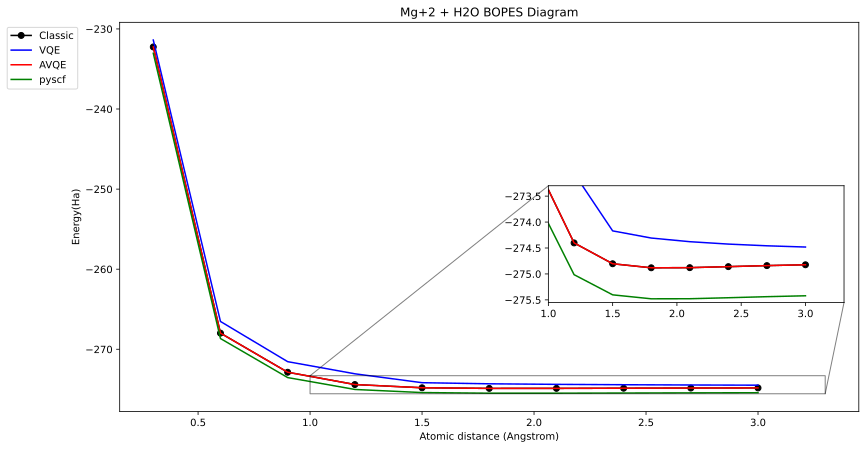

In [266]:
fig, ax=plt.subplots(1,1,figsize=(11,6))
fig.tight_layout()

ax.plot(dists,classic_energies, '-ko',label="Classic")
ax.plot(dists, vqe_energies, '-b',label="VQE")
ax.plot(dists, avqe_energies, '-r',label="AVQE")
ax.plot(dists, pyscf_energies, '-g',label="pyscf")


ax.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Zn+2 + H2O BOPES Diagram')
ax.legend(bbox_to_anchor=(-.05,1))


axins2 = ax.inset_axes([0.58, 0.28, 0.4, 0.3])
axins2.plot(dists,classic_energies, '-ko',label="Classic")
axins2.plot(dists, vqe_energies, '-b',label="VQE")
axins2.plot(dists, avqe_energies, '-r',label="AVQE")
axins2.plot(dists, pyscf_energies, '-g',label="pyscf")

xx1, xx2, yy1, yy2 = 1.0,3.3, -275.55, -273.3
axins2.set_xlim(xx1, xx2)
axins2.set_ylim(yy1, yy2)

ax.indicate_inset_zoom(axins2, edgecolor="black")

plt.subplots_adjust(wspace=0.17)
plt.show()

First we do a single calculation for a given separations distance d.

## Zn+2 + CO2

First we do a single calculation for a given separations distance d.

### Step 1: Build Qubit Operator.

In [ ]:
#Define Molecule
d=1.5
molecule = MoleculeInfo(
             # coordinates in Angstrom
                     symbols=['O','C','O','Zn'],
                     coords=[
                            (-1.1621,0.0,0.0),
                            (0.0,0.0,0),
                            (1.1621,0.0,0),
                            (d+1.1621, 0.0,0.0),
                            ],
                     multiplicity=1,  # = 2*spin + 1
                     charge=2,
                     units=DistanceUnit.ANGSTROM
                    )

#Set driver
driver = PySCFDriver.from_molecule(molecule, basis="6-31g*", method=MethodType.RKS)
driver.xc_functional='b3lyp'

#Get properties of origianl problem
og_problem = driver.run()
    
#particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
#num_a_electrons = problem.num_alpha
#num_b_electrons = propblem.num_beta
og_num_particles=og_problem.num_particles

og_num_spatial_orbitals =og_problem.num_spatial_orbitals

og_rep_energy = og_problem.nuclear_repulsion_energy
    
# Check the occupation of the spin orbitals
og_PN_property = og_problem.properties.particle_number
mol = gto.Mole()
mol.atom = [
        ['C',(0.0,0.0,0)],
        ['O',(-1.1621,0.0,0.0),],
        ['O',(1.1621,0.0,0.0)],
        ['Zn',(d+1.1621, 0.0, 0.0)]
        ]
mol.charge=2
mol.basis = '6-31g*'
mol.spin = 0
mol.build()

mf = scf.RKS(mol).x2c()
mf.kernel()

ao_labels = ['Zn 2p', 'O 2p']#,'H 1s']
avas_obj = avas.AVAS(mf, ao_labels)
avas_obj.kernel()
weights=np.append(avas_obj.occ_weights,avas_obj.vir_weights)
weights=(weights>0.1)*weights
orbs=np.nonzero(weights)


# Define the active space
# (selected automatically around the HOMO and LUMO, ordered by energy)
transformer = ActiveSpaceTransformer(
            num_electrons=(int(avas_obj.nelecas/2),int(avas_obj.nelecas/2)), #Electrons in active space
            num_spatial_orbitals=avas_obj.ncas+1, #Orbitals in active space
            active_orbitals=orbs[0].tolist().append(orbs[0][-1]+1)
        )

### Uncomment below for manual selection

# transformer = ActiveSpaceTransformer(
#             num_electrons=(3,3), #Electrons in active space
#             num_spatial_orbitals=4, #Orbitals in active space
#             #active_orbitals=orbs[0].tolist().append(orbs[0][-1]+1)
#         )

fz_transformer=FreezeCoreTransformer(freeze_core=True) # Freeze core transformer in case we want to freeze core electrons
    
#Define the problem

problem=transformer.transform(og_problem)

#fz_problem=fz_transformer.transform(og_problem)

#Get Hamiltonian form driver

#og_hamiltonian=og_problem.hamiltonian
#og_second_q_op = og_hamiltonian.second_q_op()
hamiltonian=problem.hamiltonian
second_q_op = hamiltonian.second_q_op()
#fz_hamiltonian=fz_problem.hamiltonian
#fz_second_q_op = fz_hamiltonian.second_q_op() 

#og_num_spatial_orbitals = og_problem.num_spatial_orbitals
#og_num_particles = og_problem.num_particles

#Get Properties of transformed problem
    
num_spatial_orbitals = problem.num_spatial_orbitals
num_particles = problem.num_particles

#fz_num_spatial_orbitals = fz_problem.num_spatial_orbitals
#fz_num_particles = fz_problem.num_particles
    
mapper=ParityMapper()

#Get Pauli OP

converter = QubitConverter(mapper,two_qubit_reduction=True, z2symmetry_reduction='auto') # Using two qubit reduction and z2. symmetries to taper off qubits.
simple_converter = QubitConverter(mapper)
    
#Final OP
#og_qubit_op = converter.convert(og_second_q_op,num_particles=og_num_particles,sector_locator=og_problem.symmetry_sector_locator)
qubit_op = converter.convert(second_q_op,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
#fz_qubit_op = converter.convert(fz_second_q_op)

Now we can check how many qubits are required for the given Active Space. Note on the code we opted for an automated method for active space selection available on PySCF, this can be done manually as well.

In [83]:
qubit_op.num_qubits

10

### Step2: VQE

With the operator constructed we do the VQE calculation:

In [154]:
#Construct the initial state for the VQE algorithm:
init_state = HartreeFock(problem.num_spatial_orbitals,problem.num_particles, converter)

#Build the ansatz based on problem properties

#ansatz = UCCSD(num_spatial_orbitals=problem.num_spatial_orbitals,num_particles=problem.num_particles,qubit_converter=converter,initial_state=init_state) # Uncomment for UCCSD ansatz

#ansatz = EfficientSU2(num_qubits=qubit_op.num_qubits,su2_gates=['ry'], entanglement='linear', reps=3, initial_state=init_state) # Uncomment for Heuristic Ansatz

#####Qubit-ADAPT-VQE ansatz

ansatz = UCCSD(num_spatial_orbitals=problem.num_spatial_orbitals,num_particles=problem.num_particles,qubit_converter=converter,initial_state=init_state)

operator_pool = []
for op in ansatz.operators:
    sop = op.primitive
    for pauli, coeff in zip(sop.paulis, sop.coeffs):
        if sum(pauli.x & pauli.z) % 2 == 0:
            continue
    operator_pool.append(PauliSumOp(coeff * SparsePauliOp(pauli)))

ansatz = EvolvedOperatorAnsatz(
        operators=operator_pool,
        initial_state=init_state,
        )

        
# Set initial parameters of the ansatz (we set zeros as we set the initial stae into the ansatz.)
initial_point=np.zeros(ansatz.num_parameters)

##Choose ooptimizer

#optimizer = SLSQP(maxiter=150)
optimizer = SPSA(maxiter=150)

#Seed for required RNG

seed = 62
algorithm_globals.random_seed = seed

##Noise model in case we want to do noisy simulations

from qiskit.providers.fake_provider import FakeManila, FakeNairobi, FakeMontreal, FakeGuadalupe

device_backend=FakeGuadalupe()
device = AerSimulator.from_backend(device_backend)
noise_model = None
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

### Qiskit Runtime options in case we want to run anything on the cloud

ts_opt=TranspilationOptions(
    skip_transpilation=True
)

sim_opt=SimulatorOptions(
    noise_model=noise_model,
    seed_simulator=62,
    coupling_map=coupling_map,
    basis_gates=basis_gates
)
res_opt=ResilienceOptions(
    noise_factors=tuple(range(1, 6, 2)),
    noise_amplifier='LocalFoldingAmplifier',
    extrapolator='LinearExtrapolator'
)

ex_opt=ExecutionOptions(
    shots=1024
)
est_options=Options(
    #resilience_level=2,
    #optimization_level=3,
    execution=ex_opt,
    #resilience=res_opt,
    #simulator=sim_opt,
    #transpilation=ts_opt
)

#Local simulator options for local simulations

bck_opt={'method':'statevector',
         'device':'CPU',
         'precision':'double',
         'extended_stabilizer_sampling_method':'resampled_metropolis'
                }
run_opt={'shots':32,
                }

#estimator = AerEstimator([ansatz], [qubit_op],backend_options=bck_opt,run_options=run_opt) #AerSimulator, worse performnace
estimator= Estimator([ansatz],[qubit_op]) # Base terra simulator, better performnace

#####
#SETUP AND RUN VQE LOCALLY
#####
    
counts = []
values = []
params= []
deviation = []
    
vqe = VQE(estimator, ansatz, optimizer,initial_point=initial_point, callback=callback)

#### If Running ADAPT-VQE
adapt_vqe=AdaptVQE(vqe)
adapt_vqe.supports_aux_operators = lambda: False ## If set to True will measure Angular Momentum, Magnetization, Particle Number and ZDipole as well.
adapt_vqe.threshold=1e-3
adapt_vqe.max_iterations=4
adapt_vqe.delta=1e-4
#####
        
solver = GroundStateEigensolver(converter, adapt_vqe)
result = solver.solve(problem)

#result = vqe.compute_minimum_eigenvalue(qubit_op) # in case you don't want the intrepreted result.

#####
#SETUP AND RUN VQE WITH RUNTIME
#####

# with Session(service=service, backend='ibmq_qasm_simulator') as session:
#     # Prepare primitive
#     rt_estimator = RuntimeEstimator(session=session)#,options=est_options)
#     # Set up algorithm
#     custom_vqe = VQE(rt_estimator, ansatz, optimizer,initial_point=initial_point, callback=callback)
#     adapt_vqe=AdaptVQE(custom_vqe)
#     adapt_vqe.supports_aux_operators = lambda: False
#     adapt_vqe.threshold=1e-3
#     adapt_vqe.max_iterations=4
#     adapt_vqe.delta=1e-4
#     # Run algorithm
#     solver = GroundStateEigensolver(converter, custom_vqe)
#     result = solver.solve(problem)

#     #result = adapt_vqe.compute_minimum_eigenvalue(qubit_op)

'Evaluation: 351, Energy: -58.700582408338406, Mean: -59.20120424364559, STD: 1.018117517799415, Metadata: {}'

After this we can print the interpreted result:

In [162]:
print(result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -322.885981754909
  - computed part:      -58.700582408338
  - ActiveSpaceTransformer extracted energy part: -264.18539934657
~ Nuclear repulsion energy (Hartree): 49.174752294501
> Total ground state energy (Hartree): -273.711229460408
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  31.14797021]
 


 Or get the raw_result:

In [165]:
print(result.raw_result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 300,
    'eigenvalue': -58.700582408338406,
    'final_max_gradient': 0.005921072611016503,
    'num_iterations': 4,
    'optimal_circuit': <qiskit.circuit.library.evolved_operator_ansatz.EvolvedOperatorAnsatz object at 0x286aff610>,
    'optimal_parameters': {   ParameterVectorElement(t[0]): -443.91112686641355,
                              ParameterVectorElement(t[2]): -620.5679018464364,
                              ParameterVectorElement(t[3]): -138.8879729074059,
                              ParameterVectorElement(t[1]): -49.366813521780706},
    'optimal_point': array([-443.91112687,  -49.36681352, -620.56790185, -138.88797291]),
    'optimal_value': -58.700582408338406,
    'optimizer_evals': None,
    'optimizer_result': <qiskit.algorithms.optimizers.optimizer.OptimizerResult object at 0x2ee1709d0>,
    'optimizer_time': 13.35978078842163,
    'termination_criterion': <TerminationCriterion.MAXIMUM: 'Maximum numb

Just for compariosn we can take a look at the different ansatzes in the form they would be read by a quantum computer

Full circuit ADAPT-VQE:

In [85]:
provider = IBMQ.get_provider(group='deployed')
backend=provider.get_backend('ibmq_guadalupe')

transpile(ansatz,backend=backend,optimization_level=3).count_ops()

OrderedDict([('cx', 263), ('rz', 223), ('sx', 154), ('x', 3)])

In [169]:
transpile(ansatz,backend=backend,optimization_level=3).depth()

313

Heuristic RYRZ ansatz:

In [166]:
og_ansatz=EfficientSU2(num_qubits=10,su2_gates=['ry'], entanglement='linear', reps=3)#, initial_state=init_state)
transpile(og_ansatz,backend=backend,optimization_level=3).count_ops()

OrderedDict([('sx', 80), ('rz', 80), ('cx', 27)])

In [170]:
transpile(og_ansatz,backend=backend).depth()

29

Biggest ansatz in last ADAPT-VQE run:

In [167]:
transpile(result.raw_result.optimal_circuit,backend=backend,optimization_level=3).count_ops()


OrderedDict([('rz', 28), ('sx', 15), ('cx', 10), ('x', 2)])

In [171]:
transpile(result.raw_result.optimal_circuit,backend=backend,optimization_level=3).depth()


16

### Step 3: VQE for diffrente distances

We build a function that creates the Electronic Structrucre Problems and qubit operators for a given distance.

In [ ]:
def make_driver(d):
    
    
    molecule = MoleculeInfo(
             # coordinates in Angstrom
                     symbols=['O','C','O','Zn'],
                     coords=[
                            (-1.1621,0.0,0.0),
                            (0.0,0.0,0),
                            (1.1621,0.0,0),
                            (d+1.1621, 0.0,0.0),
                            ],
                     multiplicity=1,  # = 2*spin + 1
                     charge=2,
                     units=DistanceUnit.ANGSTROM
                    )
    
    #Set driver
    #driver = PySCFDriver.from_molecule(molecule, basis="sto3g", method=MethodType.ROHF)
    #driver.xc_functional='pbe,pbe'
    driver = PySCFDriver.from_molecule(molecule, basis="6-31g*", method=MethodType.ROKS)
    driver.xc_functional='b3lyp'
    driver.conv_tol = 1e-6

    #Get properties
    problem = driver.run()
    

    return driver, problem

def make_qubit_op(d,og_problem, mapper,freeze_core):
    mol = gto.Mole()
    mol.atom = [
        ['C',(0.0,0.0,0)],
        ['O',(-1.1621,0.0,0.0),],
        ['O',(1.1621,0.0,0.0)],
        ['Zn',(d+1.1621, 0.0, 0.0)]
        ]
    mol.charge=2
    mol.basis = '6-31g*'
    mol.spin = 0
    mol.build()
    
    #mf= scf.ROHF(mol).x2c()
    mf = dft.ROKS(mol).density_fit(auxbasis='def2-universal-jfit')
    mf.xc ='pbe,pbe'
    mf.max_cycle = 50
    mf.conv_tol = 1e-6
    
    first_run=mf.kernel()
    a = mf.stability()[0]
    if(mf.converged):
        energy=first_run
    else:
        mf.max_cycle = 80
        mf.conv_tol = 1e-6
        mf = scf.newton(mf)
        scnd_run=mf.kernel(dm0 = mf.make_rdm1(a,mf.mo_occ)) # using rdm1 constructed from stability analysis
      #mf.kernel(mf.make_rdm1()) #using the rdm from the non-converged calculation
        if(mf.converged):
            energy=scnd_run
        else:
            mf.conv_tol = 1e-6
            mf.max_cycle = 80
            mf = scf.newton(mf) #Second order solver
            energy=mf.kernel(dm0 = mf.make_rdm1())


    ao_labels = ['Zn 3d', 'O 2p']
    avas_obj = avas.AVAS(mf, ao_labels)
    avas_obj.kernel()
    weights=np.append(avas_obj.occ_weights,avas_obj.vir_weights)
    weights=(weights>0.2)*weights
    orbs=np.nonzero(weights)
    orbs=np.nonzero(weights)
    
    # transformer = ActiveSpaceTransformer(
    #         num_electrons=(int(avas_obj.nelecas/2),int(avas_obj.nelecas/2)), #Electrons in active space
    #         num_spatial_orbitals=avas_obj.ncas+1, #Orbitals in active space
    #         active_orbitals=orbs[0].tolist().append(orbs[0][-1]+1)
    #     )
    transformer = ActiveSpaceTransformer(
            num_electrons=(6,6), #Electrons in active space
            num_spatial_orbitals=7, #Orbitals in active space
            #active_orbitals=orbs[0].tolist().append(orbs[0][-1]+1)
        )
    fz_transformer=FreezeCoreTransformer(freeze_core=freeze_core)
    
    #Define the problem

    problem=transformer.transform(og_problem)
    if freeze_core==True:
        problem=fz_transformer.transform(problem)
        converter = QubitConverter(mapper)
    else:
        converter = QubitConverter(mapper,two_qubit_reduction=True, z2symmetry_reduction='auto')

    hamiltonian=problem.hamiltonian
    second_q_op = hamiltonian.second_q_op()
    
    num_spatial_orbitals = problem.num_spatial_orbitals
    num_particles = problem.num_particles
    
    qubit_op = converter.convert(second_q_op,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
    
        

    
    return qubit_op, problem,  converter, energy
    

Noise_model options for noisy simulations

In [ ]:
from qiskit.providers.fake_provider import FakeManila, FakeNairobi, FakeMontreal, FakeGuadalupe

#Noisy simulator
backend_aer = AerSimulator(method='density_matrix',device='CPU')
device_backend=FakeGuadalupe()
device = AerSimulator.from_backend(device_backend)
noise_model = None
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

sim_opt=SimulatorOptions(
    noise_model=noise_model,
    seed_simulator=62,
    coupling_map=coupling_map,
    basis_gates=basis_gates
)

Qiskit Runtime Options

In [ ]:
#Runtime Estimator options
ts_opt=TranspilationOptions(
    skip_transpilation=True
)

sim_opt=SimulatorOptions(
    noise_model=noise_model,
    seed_simulator=62,
    coupling_map=coupling_map,
    basis_gates=basis_gates
)
res_opt=ResilienceOptions(
    noise_factors=tuple(range(1, 6, 2)),
    noise_amplifier='LocalFoldingAmplifier',
    extrapolator='LinearExtrapolator'
)

ex_opt=ExecutionOptions(
    shots=1024
)
est_options=Options(
    resilience_level=2,
    #optimization_level=3,
    execution=ex_opt,
    resilience=res_opt,
    #simulator=sim_opt,
    #transpilation=ts_opt
)

Calculation options

In [ ]:
distances = np.arange(0.3, 3.6, 0.3)
optimizer = SLSQP(maxiter=100)
#optimizer = SPSA(maxiter=100)
mapper=ParityMapper()


seed = 62
algorithm_globals.random_seed = seed

Calculations:

In [ ]:
#Local Calculations

counts = []
values = []
params = []
meta_dicts=[]


ryrz_results,ryrz_problems,dists,pyscf_energies=local_RYRZ_solver(                                               distances=distances,
                                                                          mapper=mapper,
                                                                          optimizer=optimizer,freeze_core=False)

'Evaluation: 5366, Energy: -38.718897420935626, Mean: -37.868849351802936, STD: 2.698982890411235, Metadata: {}'

In [ ]:
counts = []
values = []
params = []
meta_dicts=[]


uccsd_results,vqe_problems,dists,pyscf_energies=local_UCCSD_solver(                                               distances=distances,
                                                                          mapper=mapper,
                                                                          optimizer=optimizer,freeze_core=False)

'Evaluation: 305, Energy: -38.72092479649816, Mean: -39.20386655500299, STD: 0.4481916965952616, Metadata: {}'

In [ ]:
#Local calculations-ADAPT VQE

counts = []
values = []
params = []
meta_dicts=[]


avqe_results,avqe_problems,dists,pyscf_energies=adapt_solver(distances=distances,
                                                                          mapper=mapper,
                                                                          optimizer=optimizer,freeze_core=False)

'Evaluation: 20, Energy: -38.357167413038646, Mean: -39.19796619108332, STD: 0.5828017666068408, Metadata: {}'

We can calculate the groundstate with numpy as well. This will serve as a benchmark for the VQE.

In [ ]:
classic_results,dists=classic_solver(distances=distances,
                             mapper=mapper,
                             optimizer=optimizer,
                             freeze_core=False
                            )

converged SCF energy = -1886.00308528113
<class 'pyscf.df.df_jk.density_fit.<locals>.DensityFitting'> wavefunction is stable in the internal stability analysis
converged SCF energy = -1955.3742103116
<class 'pyscf.df.df_jk.density_fit.<locals>.DensityFitting'> wavefunction is stable in the internal stability analysis
converged SCF energy = -1963.94918606297
<class 'pyscf.df.df_jk.density_fit.<locals>.DensityFitting'> wavefunction is stable in the internal stability analysis
converged SCF energy = -1965.83570285222
<class 'pyscf.df.df_jk.density_fit.<locals>.DensityFitting'> wavefunction is stable in the internal stability analysis
converged SCF energy = -1966.24035172308
<class 'pyscf.df.df_jk.density_fit.<locals>.DensityFitting'> wavefunction is stable in the internal stability analysis
converged SCF energy = -1966.30038614182
<class 'pyscf.df.df_jk.density_fit.<locals>.DensityFitting'> wavefunction is stable in the internal stability analysis
converged SCF energy = -1966.28509508314


We can save results and retrieve later:

In [ ]:
write_list(avqe_problems,'Zn+CO2/simulations/avqe_problems')

Done writing list into a binary file


In [ ]:
write_list(ryrz_results,'Zn+CO2/simulations/ryrz_results')
write_list(uccsd_results,'Zn+CO2/simulations/uccsd_results')
write_list(avqe_results,'Zn+CO2/simulations/avqe_results')
write_list(classic_results,'Zn+CO2/simulations/classic_results')
write_list(pyscf_energies,'Zn+CO2/simulations/pyscf_energies')

Done writing list into a binary file
Done writing list into a binary file
Done writing list into a binary file
Done writing list into a binary file
Done writing list into a binary file


In [392]:
write_list(avqe_results,'test.py')

Done writing list into a binary file


In [394]:
test=read('test.py')

In [398]:
print(test[0].raw_result)

{   'aux_operators_evaluated': {   'AngularMomentum': (   0.012936874673912427,
                                                          {}),
                                   'Magnetization': (   1.3710462538063517e-06,
                                                        {}),
                                   'ParticleNumber': (11.999986572090553, {}),
                                   'ZDipole': (0.006907172430952263, {})},
    'cost_function_evals': 57,
    'eigenvalue': -82.43954654007587,
    'final_max_gradient': 0.025266721474452192,
    'num_iterations': 4,
    'optimal_circuit': <qiskit.circuit.library.evolved_operator_ansatz.EvolvedOperatorAnsatz object at 0x16bdc3280>,
    'optimal_parameters': {   ParameterVectorElement(t[1]): 0.007998787200850576,
                              ParameterVectorElement(t[2]): -3.368037726890511,
                              ParameterVectorElement(t[3]): 0.45500850220927225,
                              ParameterVectorElement(t[0]): 

We can calculate the groundstate with numpy as well. This will serve as a benchmark for the VQE.

In [ ]:
classic_results,dists=classic_solver(distances=distances,
                             mapper=mapper,
                             optimizer=optimizer,
                             freeze_core=False
                            )

Extract the energy values from the results and plot them:

In [ ]:
avqe_energies=[]
vqe_energies=[]
classic_energies=[]
for i in range(len(dists)):
            avqe_energies.append(avqe_results[i].total_energies)
            vqe_energies.append(vqe_problems[i].interpret(vqe_results[i]).total_energies)
            classic_energies.append(classic_results[i].total_energies)

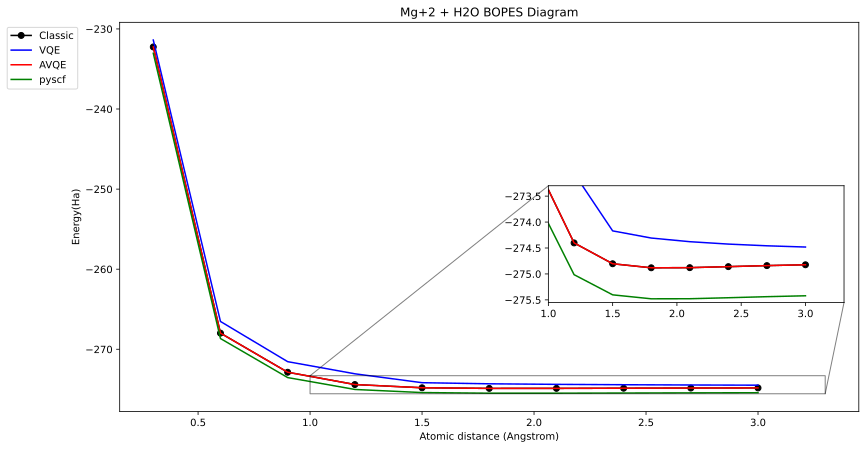

In [266]:
fig, ax=plt.subplots(1,1,figsize=(11,6))
fig.tight_layout()

ax.plot(dists,classic_energies, '-ko',label="Classic")
ax.plot(dists, vqe_energies, '-b',label="VQE")
ax.plot(dists, avqe_energies, '-r',label="AVQE")
ax.plot(dists, pyscf_energies, '-g',label="pyscf")


ax.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Zn+2 + H2O BOPES Diagram')
ax.legend(bbox_to_anchor=(-.05,1))


axins2 = ax.inset_axes([0.58, 0.28, 0.4, 0.3])
axins2.plot(dists,classic_energies, '-ko',label="Classic")
axins2.plot(dists, vqe_energies, '-b',label="VQE")
axins2.plot(dists, avqe_energies, '-r',label="AVQE")
axins2.plot(dists, pyscf_energies, '-g',label="pyscf")

xx1, xx2, yy1, yy2 = 1.0,3.3, -275.55, -273.3
axins2.set_xlim(xx1, xx2)
axins2.set_ylim(yy1, yy2)

ax.indicate_inset_zoom(axins2, edgecolor="black")

plt.subplots_adjust(wspace=0.17)
plt.show()

# Version

In [188]:
import qiskit.tools.jupyter
%qiskit_version_table

# Draft

In [95]:
# This code is part of Qiskit.
#
# (C) Copyright IBM 2022.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

"""The variational quantum eigensolver algorithm."""

from __future__ import annotations

import logging
from time import time
from collections.abc import Callable, Sequence
from typing import Any

import numpy as np

from qiskit.algorithms.gradients import BaseEstimatorGradient
from qiskit.circuit import QuantumCircuit
from qiskit.opflow import PauliSumOp
from qiskit.primitives import BaseEstimator
from qiskit.quantum_info.operators.base_operator import BaseOperator

from qiskit.algorithms.exceptions import AlgorithmError
from qiskit.algorithms.list_or_dict import ListOrDict
from qiskit.algorithms.optimizers import Optimizer, Minimizer, OptimizerResult
from qiskit.algorithms.variational_algorithm import VariationalAlgorithm, VariationalResult
from qiskit.algorithms.minimum_eigensolvers import MinimumEigensolver, MinimumEigensolverResult
from qiskit.algorithms.observables_evaluator import estimate_observables
from qiskit.algorithms.utils import validate_initial_point, validate_bounds

# private function as we expect this to be updated in the next released
from qiskit.algorithms.utils.set_batching import _set_default_batchsize

logger = logging.getLogger(__name__)


class CustomVQE(VariationalAlgorithm, MinimumEigensolver):
    r"""The variational quantum eigensolver (VQE) algorithm.
    VQE is a hybrid quantum-classical algorithm that uses a variational technique to find the
    minimum eigenvalue of a given Hamiltonian operator :math:`H`.
    The ``VQE`` algorithm is executed using an :attr:`estimator` primitive, which computes
    expectation values of operators (observables).
    An instance of ``VQE`` also requires an :attr:`ansatz`, a parameterized
    :class:`.QuantumCircuit`, to prepare the trial state :math:`|\psi(\vec\theta)\rangle`. It also
    needs a classical :attr:`optimizer` which varies the circuit parameters :math:`\vec\theta` such
    that the expectation value of the operator on the corresponding state approaches a minimum,
    .. math::
        \min_{\vec\theta} \langle\psi(\vec\theta)|H|\psi(\vec\theta)\rangle.
    The :attr:`estimator` is used to compute this expectation value for every optimization step.
    The optimizer can either be one of Qiskit's optimizers, such as
    :class:`~qiskit.algorithms.optimizers.SPSA` or a callable with the following signature:
    .. code-block:: python
        from qiskit.algorithms.optimizers import OptimizerResult
        def my_minimizer(fun, x0, jac=None, bounds=None) -> OptimizerResult:
            # Note that the callable *must* have these argument names!
            # Args:
            #     fun (callable): the function to minimize
            #     x0 (np.ndarray): the initial point for the optimization
            #     jac (callable, optional): the gradient of the objective function
            #     bounds (list, optional): a list of tuples specifying the parameter bounds
            result = OptimizerResult()
            result.x = # optimal parameters
            result.fun = # optimal function value
            return result
    The above signature also allows one to use any SciPy minimizer, for instance as
    .. code-block:: python
        from functools import partial
        from scipy.optimize import minimize
        optimizer = partial(minimize, method="L-BFGS-B")
    The following attributes can be set via the initializer but can also be read and updated once
    the VQE object has been constructed.
    Attributes:
        estimator (BaseEstimator): The estimator primitive to compute the expectation value of the
            Hamiltonian operator.
        ansatz (QuantumCircuit): A parameterized quantum circuit to prepare the trial state.
        optimizer (Optimizer | Minimizer): A classical optimizer to find the minimum energy. This
            can either be a Qiskit :class:`.Optimizer` or a callable implementing the
            :class:`.Minimizer` protocol.
        gradient (BaseEstimatorGradient | None): An optional estimator gradient to be used with the
            optimizer.
        callback (Callable[[int, np.ndarray, float, dict[str, Any]], None] | None): A callback that
            can access the intermediate data at each optimization step. These data are: the
            evaluation count, the optimizer parameters for the ansatz, the evaluated mean, and the
            metadata dictionary.
    References:
        [1]: Peruzzo, A., et al, "A variational eigenvalue solver on a quantum processor"
            `arXiv:1304.3061 <https://arxiv.org/abs/1304.3061>`__
    """

    def __init__(
        self,
        estimator: BaseEstimator,
        ansatz: QuantumCircuit,
        optimizer: Optimizer | Minimizer,
        *,
        gradient: BaseEstimatorGradient | None = None,
        initial_point: Sequence[float] | None = None,
        callback: Callable[[int, np.ndarray, float, dict[str, Any]], None] | None = None,
        max_retries:Optional[int]=None
    ) -> None:
        r"""
        Args:
            estimator: The estimator primitive to compute the expectation value of the
                Hamiltonian operator.
            ansatz: A parameterized quantum circuit to prepare the trial state.
            optimizer: A classical optimizer to find the minimum energy. This can either be a
                Qiskit :class:`.Optimizer` or a callable implementing the :class:`.Minimizer`
                protocol.
            gradient: An optional estimator gradient to be used with the optimizer.
            initial_point: An optional initial point (i.e. initial parameter values) for the
                optimizer. The length of the initial point must match the number of :attr:`ansatz`
                parameters. If ``None``, a random point will be generated within certain parameter
                bounds. ``VQE`` will look to the ansatz for these bounds. If the ansatz does not
                specify bounds, bounds of :math:`-2\pi`, :math:`2\pi` will be used.
            callback: A callback that can access the intermediate data at each optimization step.
                These data are: the evaluation count, the optimizer parameters for the ansatz, the
                estimated value, and the metadata dictionary.
        """
        super().__init__()

        self.estimator = estimator
        self.ansatz = ansatz
        self.optimizer = optimizer
        self.gradient = gradient
        # this has to go via getters and setters due to the VariationalAlgorithm interface
        self.initial_point = initial_point
        self.callback = callback
        self.max_retries=max_retries

    @property
    def initial_point(self) -> Sequence[float] | None:
        return self._initial_point

    @initial_point.setter
    def initial_point(self, value: Sequence[float] | None) -> None:
        self._initial_point = value

    def compute_minimum_eigenvalue(
        self,
        operator: BaseOperator | PauliSumOp,
        aux_operators: ListOrDict[BaseOperator | PauliSumOp] | None = None,
    ) -> VQEResult:
        self._check_operator_ansatz(operator)

        initial_point = validate_initial_point(self.initial_point, self.ansatz)

        bounds = validate_bounds(self.ansatz)

        start_time = time()

        evaluate_energy = self._get_evaluate_energy(self.ansatz, operator)

        if self.gradient is not None:
            evaluate_gradient = self._get_evaluate_gradient(self.ansatz, operator)
        else:
            evaluate_gradient = None

        # perform optimization
        if callable(self.optimizer):
            optimizer_result = retry(self.optimizer(
                fun=evaluate_energy, x0=initial_point, jac=evaluate_gradient, bounds=bounds
            ),self.max_retries)
        else:
            # we always want to submit as many estimations per job as possible for minimal
            # overhead on the hardware
            was_updated = _set_default_batchsize(self.optimizer)

            optimizer_result = retry(self.optimizer.minimize(
                fun=evaluate_energy, x0=initial_point, jac=evaluate_gradient, bounds=bounds
            ),self.max_retries)

            # reset to original value
            if was_updated:
                self.optimizer.set_max_evals_grouped(None)

        optimizer_time = time() - start_time

        logger.info(
            "Optimization complete in %s seconds.\nFound optimal point %s",
            optimizer_time,
            optimizer_result.x,
        )

        if aux_operators is not None:
            aux_operators_evaluated = estimate_observables(
                self.estimator, self.ansatz, aux_operators, optimizer_result.x
            )
        else:
            aux_operators_evaluated = None

        return self._build_vqe_result(
            self.ansatz, optimizer_result, aux_operators_evaluated, optimizer_time
        )

    @classmethod
    def supports_aux_operators(cls) -> bool:
        return True

    def _get_evaluate_energy(
        self,
        ansatz: QuantumCircuit,
        operator: BaseOperator | PauliSumOp,
    ) -> Callable[[np.ndarray], np.ndarray | float]:
        """Returns a function handle to evaluate the energy at given parameters for the ansatz.
        This is the objective function to be passed to the optimizer that is used for evaluation.
        Args:
            ansatz: The ansatz preparing the quantum state.
            operator: The operator whose energy to evaluate.
        Returns:
            A callable that computes and returns the energy of the hamiltonian of each parameter.
        Raises:
            AlgorithmError: If the primitive job to evaluate the energy fails.
        """
        num_parameters = ansatz.num_parameters

        # avoid creating an instance variable to remain stateless regarding results
        eval_count = 0

        def evaluate_energy(parameters: np.ndarray) -> np.ndarray | float:
            nonlocal eval_count

            # handle broadcasting: ensure parameters is of shape [array, array, ...]
            parameters = np.reshape(parameters, (-1, num_parameters)).tolist()
            batch_size = len(parameters)

            try:
                job = self.estimator.run(batch_size * [ansatz], batch_size * [operator], parameters)
                estimator_result = job.result()
            except Exception as exc:
                raise AlgorithmError("The primitive job to evaluate the energy failed!") from exc

            values = estimator_result.values

            if self.callback is not None:
                metadata = estimator_result.metadata
                for params, value, meta in zip(parameters, values, metadata):
                    eval_count += 1
                    self.callback(eval_count, params, value, meta)

            energy = values[0] if len(values) == 1 else values

            return energy

        return evaluate_energy

    def _get_evaluate_gradient(
        self,
        ansatz: QuantumCircuit,
        operator: BaseOperator | PauliSumOp,
    ) -> Callable[[np.ndarray], np.ndarray]:
        """Get a function handle to evaluate the gradient at given parameters for the ansatz.
        Args:
            ansatz: The ansatz preparing the quantum state.
            operator: The operator whose energy to evaluate.
        Returns:
            A function handle to evaluate the gradient at given parameters for the ansatz.
        Raises:
            AlgorithmError: If the primitive job to evaluate the gradient fails.
        """

        def evaluate_gradient(parameters: np.ndarray) -> np.ndarray:
            # broadcasting not required for the estimator gradients
            try:
                job = self.gradient.run([ansatz], [operator], [parameters])
                gradients = job.result().gradients
            except Exception as exc:
                raise AlgorithmError("The primitive job to evaluate the gradient failed!") from exc

            return gradients[0]

        return evaluate_gradient

    def _check_operator_ansatz(self, operator: BaseOperator | PauliSumOp):
        """Check that the number of qubits of operator and ansatz match and that the ansatz is
        parameterized.
        """
        if operator.num_qubits != self.ansatz.num_qubits:
            try:
                logger.info(
                    "Trying to resize ansatz to match operator on %s qubits.", operator.num_qubits
                )
                self.ansatz.num_qubits = operator.num_qubits
            except AttributeError as error:
                raise AlgorithmError(
                    "The number of qubits of the ansatz does not match the "
                    "operator, and the ansatz does not allow setting the "
                    "number of qubits using `num_qubits`."
                ) from error

        if self.ansatz.num_parameters == 0:
            raise AlgorithmError("The ansatz must be parameterized, but has no free parameters.")

    def _build_vqe_result(
        self,
        ansatz: QuantumCircuit,
        optimizer_result: OptimizerResult,
        aux_operators_evaluated: ListOrDict[tuple[complex, tuple[complex, int]]],
        optimizer_time: float,
    ) -> VQEResult:
        result = VQEResult()
        result.optimal_circuit = ansatz.copy()
        result.eigenvalue = optimizer_result.fun
        result.cost_function_evals = optimizer_result.nfev
        result.optimal_point = optimizer_result.x
        result.optimal_parameters = dict(zip(self.ansatz.parameters, optimizer_result.x))
        result.optimal_value = optimizer_result.fun
        result.optimizer_time = optimizer_time
        result.aux_operators_evaluated = aux_operators_evaluated
        result.optimizer_result = optimizer_result
        return result


class VQEResult(VariationalResult, MinimumEigensolverResult):
    """Variational quantum eigensolver result."""

    def __init__(self) -> None:
        super().__init__()
        self._cost_function_evals = None

    @property
    def cost_function_evals(self) -> int | None:
        """The number of cost optimizer evaluations."""
        return self._cost_function_evals

    @cost_function_evals.setter
    def cost_function_evals(self, value: int) -> None:
        self._cost_function_evals = value

In [59]:
from qiskit_ibm_runtime import Estimator as RuntimeEstimator
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.opflow import PauliSumOp
from qiskit.quantum_info.operators.base_operator import BaseOperator
from qiskit.providers.options import Options as TerraOptions
from qiskit.primitives import BaseEstimator, EstimatorResult
from qiskit_ibm_runtime.ibm_backend import IBMBackend
from qiskit_ibm_runtime.runtime_job import RuntimeJob
from qiskit_ibm_runtime.options import Options
from qiskit_ibm_runtime.constants import DEFAULT_DECODERS
from typing import Iterable, Optional, Dict, Sequence, Any, Union
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger('retry')

def retry(func, max_retry=10):
    """
    @param func: The function that needs to be retry
    @param max_retry: Maximum retry of `func` function, default is `10`
    @return: func
    @raise: RetryException if retries exceeded than max_retry
    """
    for retry in range(1, max_retry + 1):
        try:
            return func()
        except Exception:
            logger.info('Failed to call in retry({}/{})'.format(
                                                           retry, max_retry))

class CustomEstimator(RuntimeEstimator):
    def __init__(self,
        circuits: Optional[Union[QuantumCircuit, Iterable[QuantumCircuit]]] = None,
        observables: Optional[Iterable[SparsePauliOp]] = None,
        parameters: Optional[Iterable[Iterable[Parameter]]] = None,
        service: Optional[QiskitRuntimeService] = None,
        session: Optional[Union[Session, str, IBMBackend]] = None,
        options: Optional[Union[Dict, Options]] = None,
        skip_transpilation: Optional[bool] = False,
        max_retries: Optional[int]=None
    ):
        # super().__init__(circuits)
        # super().__init__(observables)
        # super().__init__(parameters)
        # super().__init__(service)
        # super().__init__(session)
        # super().__init__(options)
        # super().__init__(skip_transpialtion)
        super().__init__()
        self.max_retries = max_retries
        
    def run(  # pylint: disable=arguments-differ
        self,
        circuits: Union[QuantumCircuit,Sequence[QuantumCircuit]],
        observables: Union[BaseOperator,PauliSumOp,Sequence[Union[BaseOperator,PauliSumOp]]],
        parameter_values: Union[Sequence[float],Sequence[Sequence[float]],None] = None ,
        **kwargs: Any,
    ) -> RuntimeJob:
        """Submit a request to the estimator primitive program.
        Args:
            circuits: a (parameterized) :class:`~qiskit.circuit.QuantumCircuit` or
                a list of (parameterized) :class:`~qiskit.circuit.QuantumCircuit`.
            observables: Observable objects.
            parameter_values: Concrete parameters to be bound.
            **kwargs: Individual options to overwrite the default primitive options.
                These include the runtime options in :class:`qiskit_ibm_runtime.RuntimeOptions`.
        Returns:
            Submitted job.
            The result of the job is an instance of :class:`qiskit.primitives.EstimatorResult`.
        Raises:
            ValueError: Invalid arguments are given.
        """
        # To bypass base class merging of options.
        user_kwargs = {"_user_kwargs": kwargs}
        return retry(super().run(
            circuits=circuits,
            observables=observables,
            parameter_values=parameter_values,
            **user_kwargs,
        ),self.max_retries)
    
    def _run(  # pylint: disable=arguments-differ
        self,
        circuits: Sequence[QuantumCircuit],
        observables: Union[Sequence[Union[BaseOperator,PauliSumOp]]],
        parameter_values: Sequence[Sequence[float]],
        **kwargs: Any,
    ) -> RuntimeJob:
        """Submit a request to the estimator primitive program.
        Args:
            circuits: a (parameterized) :class:`~qiskit.circuit.QuantumCircuit` or
                a list of (parameterized) :class:`~qiskit.circuit.QuantumCircuit`.
            observables: A list of observable objects.
            parameter_values: An optional list of concrete parameters to be bound.
            **kwargs: Individual options to overwrite the default primitive options.
                These include the runtime options in :class:`~qiskit_ibm_runtime.RuntimeOptions`.
        Returns:
            Submitted job
        """
        # TODO: Re-enable data caching when ntc 1748 is fixed
        # circuits_map = {}
        # circuit_ids = []
        # for circuit in circuits:
        #     circuit_id = _hash(json.dumps(_circuit_key(circuit), cls=RuntimeEncoder))
        #     circuit_ids.append(circuit_id)
        #     if circuit_id in self._session._circuits_map:
        #         continue
        #     self._session._circuits_map[circuit_id] = circuit
        #     circuits_map[circuit_id] = circuit

        # if self._first_run:
        #     self._first_run = False
        #     circuits_map.update(self._circuits_map)

        # inputs = {
        #     "circuits": circuits_map,
        #     "circuit_ids": circuit_ids,
        #     "observables": observables,
        #     "observable_indices": list(range(len(observables))),
        #     "parameter_values": parameter_values,
        # }
        inputs = {
            "circuits": circuits,
            "circuit_indices": list(range(len(circuits))),
            "observables": observables,
            "observable_indices": list(range(len(observables))),
            "parameters": [circ.parameters for circ in circuits],
            "parameter_values": parameter_values,
        }

        #combined = Options._merge_options(self._options, kwargs.get("_user_kwargs", {}))
        #logger.info("Submitting job using options %s", combined)
        #inputs.update(Options._get_program_inputs(combined))

        return retry(self._session.run(
            program_id=self._PROGRAM_ID,
            inputs=inputs,
            options=Options._get_runtime_options(self._options),
            callback=self._options.get("environment", {}).get("callback", None),
            result_decoder=DEFAULT_DECODERS.get(self._PROGRAM_ID),
        ).result(),self.max_retries)

    
    

In [65]:
from qiskit_ibm_runtime import Estimator as RuntimeEstimator
from qiskit_ibm_runtime import Session
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.opflow import PauliSumOp
from qiskit.quantum_info.operators.base_operator import BaseOperator
from qiskit.providers.options import Options as TerraOptions
from qiskit.primitives import BaseEstimator, EstimatorResult
from qiskit_ibm_runtime.ibm_backend import IBMBackend
from qiskit_ibm_runtime.runtime_job import RuntimeJob
from qiskit_ibm_runtime.options import Options
from qiskit_ibm_runtime.constants import DEFAULT_DECODERS
from qiskit_ibm_runtime.runtime_program import ParameterNamespace
from qiskit_ibm_runtime.program.result_decoder import ResultDecoder
from typing import Iterable, Optional, Dict, Sequence, Any, Union, Callable, Type
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger('retry')

def retry(func, max_retry=10):
    """
    @param func: The function that needs to be retry
    @param max_retry: Maximum retry of `func` function, default is `10`
    @return: func
    @raise: RetryException if retries exceeded than max_retry
    """
    for retry in range(1, max_retry + 1):
        try:
            return func()
        except Exception:
            logger.info('Failed to call in retry({}/{})'.format(
                                                           retry, max_retry))

class CustomSession(Session):
    def __init__(
        self,
        service: Optional[QiskitRuntimeService] = None,
        backend: Optional[Union[str, IBMBackend]] = None,
        max_time: Optional[Union[int, str]] = None,
        max_retries: Optional[int]=None
    ):
        # super().__init__(circuits)
        # super().__init__(observables)
        # super().__init__(parameters)
        # super().__init__(service)
        # super().__init__(session)
        # super().__init__(options)
        # super().__init__(skip_transpialtion)
        super().__init__()
        self.max_retries = max_retries
        
    def run(
        self,
        program_id: str,
        inputs: Union[Dict, ParameterNamespace],
        options: Optional[Dict] = None,
        callback: Optional[Callable] = None,
        result_decoder: Optional[Type[ResultDecoder]] = None,
    ) -> RuntimeJob:
        """Run a program in the session.
        Args:
            program_id: Program ID.
            inputs: Program input parameters. These input values are passed
                to the runtime program.
            options: Runtime options that control the execution environment.
                See :class:`qiskit_ibm_runtime.RuntimeOptions` for all available options,
                EXCEPT ``backend``, which should be specified during session initialization.
            callback: Callback function to be invoked for any interim results and final result.
        Returns:
            Submitted job.
        Raises:
            IBMInputValueError: If a backend is passed in through options that does not match
                the current session backend.
        """

        options = options or {}
        if "backend" in options:
            issue_deprecation_msg(
                "'backend' is no longer a supported option within a session",
                "0.9",
                "Instead, specify a backend when creating a Session instance.",
                3,
            )
            if self._backend and options["backend"] != self._backend:
                raise IBMInputValueError(
                    f"The backend '{options['backend']}' is different from",
                    f"the session backend '{self._backend}'",
                )
        else:
            options["backend"] = self._backend

        if not self._session_id:
            # TODO: What happens if session max time != first job max time?
            # Use session max time if this is first job.
            options["max_execution_time"] = self._max_time

        job = retry(self._service.run(
            program_id=program_id,
            options=options,
            inputs=inputs,
            session_id=self._session_id,
            start_session=self._session_id is None,
            callback=callback,
            result_decoder=result_decoder,
        ),self.max_retries)

        if self._session_id is None:
            self._session_id = job.job_id()

        if self._backend is None:
            self._backend = job.backend().name

        return job
    

In [77]:
# This code is part of Qiskit.
#
# (C) Copyright IBM 2022.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

"""Qiskit Runtime flexible session."""

from typing import Dict, Optional, Type, Union, Callable
from types import TracebackType
from functools import wraps

from qiskit.circuit import QuantumCircuit

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.runtime_job import RuntimeJob
from qiskit_ibm_runtime.runtime_program import ParameterNamespace
from qiskit_ibm_runtime.program.result_decoder import ResultDecoder
from qiskit_ibm_runtime.ibm_backend import IBMBackend
from qiskit_ibm_runtime.utils.converters import hms_to_seconds
from qiskit_ibm_runtime.utils.deprecation import issue_deprecation_msg
from qiskit_ibm_runtime.exceptions import IBMInputValueError


def _active_session(func):  # type: ignore
    """Decorator used to ensure the session is active."""

    @wraps(func)
    def _wrapper(self, *args, **kwargs):  # type: ignore
        if not self._active:
            raise RuntimeError("The session is closed.")
        return func(self, *args, **kwargs)

    return _wrapper


class Session:
    """Class for creating a flexible Qiskit Runtime session.
    A Qiskit Runtime ``session`` allows you to group a collection of iterative calls to
    the quantum computer. A session is started when the first job within the session
    is started. Subsequent jobs within the session are prioritized by the scheduler.
    Data used within a session, such as transpiled circuits, is also cached to avoid
    unnecessary overhead.
    You can open a Qiskit Runtime session using this ``Session`` class and submit jobs
    to one or more primitives.
    For example::
        from qiskit.test.reference_circuits import ReferenceCircuits
        from qiskit_ibm_runtime import Sampler, Session, Options
        options = Options(optimization_level=3)
        with Session(backend="ibmq_qasm_simulator") as session:
            sampler = Sampler(session=session, options=options)
            job = sampler.run(circ)
            print(f"Sampler job ID: {job.job_id()}")
            print(f"Sampler job result:" {job.result()})
            # Close the session only if all jobs are finished and
            # you don't need to run more in the session.
            session.close()
    """

    def __init__(
        self,
        service: Optional[QiskitRuntimeService] = None,
        backend: Optional[Union[str, IBMBackend]] = None,
        max_time: Optional[Union[int, str]] = None,
        max_retries: Optional[int] = None
    ):  # pylint: disable=line-too-long
        """Session constructor.
        Args:
            service: Optional instance of the ``QiskitRuntimeService`` class.
                If ``None``, the service associated with the backend, if known, is used.
                Otherwise ``QiskitRuntimeService()`` is used to initialize
                your default saved account.
            backend: Optional instance of :class:`qiskit_ibm_runtime.IBMBackend` class or
                string name of backend. An instance of :class:`qiskit_ibm_provider.IBMBackend` will not work.
                If not specified, a backend will be selected automatically (IBM Cloud channel only).
            max_time: (EXPERIMENTAL setting, can break between releases without warning)
                Maximum amount of time, a runtime session can be open before being
                forcibly closed. Can be specified as seconds (int) or a string like "2h 30m 40s".
                This value must be in between 300 seconds and the
                `system imposed maximum
                <https://qiskit.org/documentation/partners/qiskit_ibm_runtime/faqs/max_execution_time.html>`_.
        Raises:
            ValueError: If an input value is invalid.
        """

        if service is None:
            self._service = (
                backend.service
                if isinstance(backend, IBMBackend)
                else QiskitRuntimeService()
            )
        else:
            self._service = service

        if self._service.channel == "ibm_quantum" and not backend:
            raise ValueError('"backend" is required for ``ibm_quantum`` channel.')
        if isinstance(backend, IBMBackend):
            backend = backend.name
        self._backend = backend

        self._session_id: Optional[str] = None
        self._active = True

        self._circuits_map: Dict[str, QuantumCircuit] = {}

        self._max_time = (
            max_time
            if max_time is None or isinstance(max_time, int)
            else hms_to_seconds(max_time, "Invalid max_time value: ")
        )
        
        self.max_retries=max_retries

    @_active_session
    def run(
        self,
        program_id: str,
        inputs: Union[Dict, ParameterNamespace],
        options: Optional[Dict] = None,
        callback: Optional[Callable] = None,
        result_decoder: Optional[Type[ResultDecoder]] = None,
    ) -> RuntimeJob:
        """Run a program in the session.
        Args:
            program_id: Program ID.
            inputs: Program input parameters. These input values are passed
                to the runtime program.
            options: Runtime options that control the execution environment.
                See :class:`qiskit_ibm_runtime.RuntimeOptions` for all available options,
                EXCEPT ``backend``, which should be specified during session initialization.
            callback: Callback function to be invoked for any interim results and final result.
        Returns:
            Submitted job.
        Raises:
            IBMInputValueError: If a backend is passed in through options that does not match
                the current session backend.
        """

        options = options or {}
        if "backend" in options:
            issue_deprecation_msg(
                "'backend' is no longer a supported option within a session",
                "0.9",
                "Instead, specify a backend when creating a Session instance.",
                3,
            )
            if self._backend and options["backend"] != self._backend:
                raise IBMInputValueError(
                    f"The backend '{options['backend']}' is different from",
                    f"the session backend '{self._backend}'",
                )
        else:
            options["backend"] = self._backend

        if not self._session_id:
            # TODO: What happens if session max time != first job max time?
            # Use session max time if this is first job.
            options["max_execution_time"] = self._max_time

        job = retry(self._service.run(
            program_id=program_id,
            options=options,
            inputs=inputs,
            session_id=self._session_id,
            start_session=self._session_id is None,
            callback=callback,
            result_decoder=result_decoder,
        ),self.max_retries)

        if self._session_id is None:
            self._session_id = job.job_id()

        if self._backend is None:
            self._backend = job.backend().name

        return job

    def close(self) -> None:
        """Close the session."""
        self._active = False
        if self._session_id:
            self._service._api_client.close_session(self._session_id)

    def backend(self) -> Optional[str]:
        """Return backend for this session.
        Returns:
            Backend for this session. None if unknown.
        """
        return self._backend

    @property
    def session_id(self) -> str:
        """Return the session ID.
        Returns:
            Session ID. None until a job runs in the session.
        """
        return self._session_id

    @property
    def service(self) -> QiskitRuntimeService:
        """Return service associated with this session.
        Returns:
            :class:`qiskit_ibm_runtime.QiskitRuntimeService` associated with this session.
        """
        return self._service

    def __enter__(self) -> "Session":
        set_cm_session(self)
        return self

    def __exit__(
        self,
        exc_type: Optional[Type[BaseException]],
        exc_val: Optional[BaseException],
        exc_tb: Optional[TracebackType],
    ) -> None:
        set_cm_session(None)


# Default session
_DEFAULT_SESSION: Optional[Session] = None
_IN_SESSION_CM = False


def set_cm_session(session: Optional[Session]) -> None:
    """Set the context manager session."""
    global _DEFAULT_SESSION  # pylint: disable=global-statement
    global _IN_SESSION_CM  # pylint: disable=global-statement
    _DEFAULT_SESSION = session
    _IN_SESSION_CM = session is not None


def get_default_session(
    service: Optional[QiskitRuntimeService] = None,
    backend: Optional[Union[str, IBMBackend]] = None,
) -> Session:
    """Return the default session.
    Args:
        service: Service to use to create a default session.
        backend: Backend for the default session.
    """
    backend_name = backend.name if isinstance(backend, IBMBackend) else backend

    global _DEFAULT_SESSION  # pylint: disable=global-statement
    session = _DEFAULT_SESSION
    if (  # pylint: disable=too-many-boolean-expressions
        _DEFAULT_SESSION is None
        or not _DEFAULT_SESSION._active
        or (backend_name is not None and _DEFAULT_SESSION._backend != backend_name)
        or (service is not None and _DEFAULT_SESSION.service.channel != service.channel)
    ):
        # Create a new session if one doesn't exist, or if the user wants to switch backend/channel.
        # Close the session only if all jobs are finished and you don't need to run more in the session.
        if _DEFAULT_SESSION and not _IN_SESSION_CM and _DEFAULT_SESSION._active:
            _DEFAULT_SESSION.close()
        if service is None:
            service = (
                backend.service
                if isinstance(backend, IBMBackend)
                else QiskitRuntimeService()
            )
        session = Session(service=service, backend=backend)
        if not _IN_SESSION_CM:
            _DEFAULT_SESSION = session
    return session

In [27]:
def make_driver(d):
    
    
    molecule = MoleculeInfo(
             # coordinates in Angstrom
                     symbols=['O','H','H','Mg'],
                     coords=[
                            # (d+0.504284,0.0,0.758602),
                            # (d,0.0,0.0),
                            # (d+2*0.504284,0.0,0.0),
                            # (0.0, 0.0, 0.0),
                            (0.0,0.0,0.0),
                            (-0.504284,0.0,-0.758602),
                            (0.504284,0.0,-0.758602),
                            (0.0, 0.0, d),
                            ],
                     multiplicity=1,  # = 2*spin + 1
                     charge=2,
                     units=DistanceUnit.ANGSTROM
                    )
    
    #Set driver
    #driver = PySCFDriver.from_molecule(molecule, basis="sto3g", method=MethodType.ROHF)
    #driver.xc_functional='pbe,pbe'
    driver = PySCFDriver.from_molecule(molecule, basis="6-31g*", method=MethodType.ROKS)
    driver.xc_functional='b3lyp'
    driver.conv_tol = 1e-6

    #Get properties
    problem = driver.run()
    

    return driver, problem

def make_qubit_op(d,og_problem, mapper,freeze_core):
    mol = gto.Mole()
    mol.atom = [
        # ['O',(d+0.504284,0.0,0.758602)],
        # ['H',(d,0.0,0.0),],
        # ['H',(d+2*0.504284,0.0,0.0)],
        # ['Mg',(0.0, 0.0, 0.0)]
        ['O',(0.0,0.0,0)],
        ['H',(-0.504284,0.0,-0.758602),],
        ['H',(0.504284,0.0,-0.758602)],
        ['Mg',(0.0, 0.0, d)]
        ]
    mol.charge=2
    mol.basis = '6-31g*'
    mol.spin = 0
    mol.build()
    
    #mf= scf.ROHF(mol).x2c()
    mf = dft.ROKS(mol).density_fit(auxbasis='def2-universal-jfit')
    mf.xc ='pbe,pbe'
    mf.max_cycle = 50
    mf.conv_tol = 1e-6
    
    first_run=mf.kernel()
    a = mf.stability()[0]
    if(mf.converged):
        energy=first_run
    else:
        mf.max_cycle = 80
        mf.conv_tol = 1e-6
        mf = scf.newton(mf)
        scnd_run=mf.kernel(dm0 = mf.make_rdm1(a,mf.mo_occ)) # using rdm1 constructed from stability analysis
      #mf.kernel(mf.make_rdm1()) #using the rdm from the non-converged calculation
        if(mf.converged):
            energy=scnd_run
        else:
            mf.conv_tol = 1e-6
            mf.max_cycle = 80
            mf = scf.newton(mf) #Second order solver
            energy=mf.kernel(dm0 = mf.make_rdm1())


    ao_labels = ['Mg 2p', 'O 2p']
    avas_obj = avas.AVAS(mf, ao_labels)
    avas_obj.kernel()
    weights=np.append(avas_obj.occ_weights,avas_obj.vir_weights)
    weights=(weights>0.2)*weights
    orbs=np.nonzero(weights)
    orbs=np.nonzero(weights)
    
    # transformer = ActiveSpaceTransformer(
    #         num_electrons=(int(avas_obj.nelecas/2),int(avas_obj.nelecas/2)), #Electrons in active space
    #         num_spatial_orbitals=avas_obj.ncas+1, #Orbitals in active space
    #         active_orbitals=orbs[0].tolist().append(orbs[0][-1]+1)
    #     )
    transformer = ActiveSpaceTransformer(
            num_electrons=(6,6), #Electrons in active space
            num_spatial_orbitals=7, #Orbitals in active space
            #active_orbitals=orbs[0].tolist().append(orbs[0][-1]+1)
        )
    fz_transformer=FreezeCoreTransformer(freeze_core=freeze_core)
    
    #Define the problem

    problem=transformer.transform(og_problem)
    if freeze_core==True:
        problem=fz_transformer.transform(problem)
        converter = QubitConverter(mapper)
    else:
        converter = QubitConverter(mapper,two_qubit_reduction=True, z2symmetry_reduction='auto')

    hamiltonian=problem.hamiltonian
    second_q_op = hamiltonian.second_q_op()
    
    num_spatial_orbitals = problem.num_spatial_orbitals
    num_particles = problem.num_particles
    
    qubit_op = converter.convert(second_q_op,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
    
        

    
    return qubit_op, problem,  converter, energy
    

Noise_model options for noisy simulations

In [7]:
from qiskit.providers.fake_provider import FakeManila, FakeNairobi, FakeMontreal, FakeGuadalupe

#Noisy simulator
backend_aer = AerSimulator(method='density_matrix',device='CPU')
device_backend=FakeGuadalupe()
device = AerSimulator.from_backend(device_backend)
noise_model = None
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

sim_opt=SimulatorOptions(
    noise_model=noise_model,
    seed_simulator=62,
    coupling_map=coupling_map,
    basis_gates=basis_gates
)

Qiskit Runtime Options

In [8]:
#Runtime Estimator options
ts_opt=TranspilationOptions(
    skip_transpilation=True
)

sim_opt=SimulatorOptions(
    noise_model=noise_model,
    seed_simulator=62,
    coupling_map=coupling_map,
    basis_gates=basis_gates
)
res_opt=ResilienceOptions(
    noise_factors=tuple(range(1, 6, 2)),
    noise_amplifier='LocalFoldingAmplifier',
    extrapolator='LinearExtrapolator'
)

ex_opt=ExecutionOptions(
    shots=1024
)
est_options=Options(
    resilience_level=2,
    #optimization_level=3,
    execution=ex_opt,
    resilience=res_opt,
    #simulator=sim_opt,
    #transpilation=ts_opt
)

Calculation options

In [9]:
distances = np.arange(0.3, 3.6, 0.3)
optimizer = SLSQP(maxiter=1000)
#optimizer = SPSA(maxiter=100)
mapper=ParityMapper()


seed = 62
algorithm_globals.random_seed = seed

In [96]:
from qiskit_ibm_runtime import Session
counts = []
values = []
params = []
meta_dicts=[]


real_results,real_problems,dists=sim_solver(distances=distances,
                                            mapper=mapper,
                                            optimizer=optimizer,
                                            freeze_core=False,
                                            est_options=est_options,
                                            mapomatic=False,
                                            device='ibmq_montreal'
                                          )

INFO:qiskit_nature.second_q.drivers.pyscfd.pyscfdriver:PySCF kernel() converged: True, e(hf): -233.15348804905776
INFO:qiskit_nature.second_q.drivers.pyscfd.pyscfdriver:HF Electronic dipole moment: [ 0.          0.         -3.87538457]
INFO:qiskit_nature.second_q.drivers.pyscfd.pyscfdriver:Nuclear dipole moment: [0.         0.         3.93591401]
INFO:qiskit_nature.second_q.drivers.pyscfd.pyscfdriver:Total dipole moment: [0.         0.         0.06052944]


converged SCF energy = -233.036314605562
<class 'pyscf.df.df_jk.density_fit.<locals>.DensityFitting'> wavefunction is stable in the internal stability analysis


INFO:qiskit.algorithms.minimum_eigensolvers.adapt_vqe:--- Iteration #1 ---
estimator._run:INFO:2023-03-06 21:24:03,511: Submitting job using options {'optimization_level': 1, 'resilience_level': 2, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None}, 'resilience': {'noise_amplifier': 'LocalFoldingAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator'}, 'execution': {'shots': 1024, 'init_qubits': True}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}
INFO:websocket:Websocket connected


AlgorithmError: 'The primitive job failed!'

In [71]:
service.channel

'ibm_quantum'